In [1]:
from astropy.io import fits
from astropy.wcs import WCS as wcs
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import astropy
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.modeling.models import Gaussian2D
from reproject import reproject_interp
from astropy.wcs import WCS
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from matplotlib.patches import Circle, Rectangle, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
ned_pa = 133+15-10
file = np.array(['ch2_mosaic.fits','ngc1808_8_Kane.fits','ngc1808_70.fits','ngc1808_100.fits','ngc1808_160_v1.fits','ngc1808_160.fits','ngc1808_250.fits','ngc1808_350.fits','ngc1808_500.fits','NGC1808_fuv.fits','NGC1808_nuv.fits','ngc1808_xmm_pn.fits','ngc1808_xmm_mos1.fits','ngc1808_xmm_mos2.fits','ngc1808_chandra_acis.fits',
                'mos1_1.fits','mos1_2.fits','mos1_3.fits','mos1_4.fits','mos1_5.fits','mos2_1.fits','mos2_2.fits','mos2_3.fits','mos2_4.fits','mos2_5.fits','pn_1.fits','pn_2.fits','pn_3.fits','pn_4.fits','pn_5.fits'])
sky_4pt5 = -9.62e-3#-1.93e-3
sky_8 = 1.492e-2#3.949e-2#-0.0798/10
sky_70 = -8e-5#-1.7e-4
sky_100 = 5.7e-4#6e-4#3.7e-4
sky_160_v1 = -4.7e-4#-6e-4#-4.5e-4
sky_160_v2 = -7.4e-4#-6.2e-4#-5.2e-4
sky_250 = -7.6e-4#1.25e-4
sky_350 = -1.19e-3#2.6e-4
sky_500 = -1.0e-4#3.4e-4
sky_fuv = 3.1e-4
sky_nuv = 2.55e-3
sky_xmm_pn = 0
sky_xmm_mos1 = 0
sky_xmm_mos2 = 0
sky_chandra = 0

fwhm_4pt5 = 1.78
fwhm_8 = 3.16
fwhm_70 = 5.6
fwhm_100 = 6.8
fwhm_160 = 11.3
fwhm_250 = 21.3
fwhm_350 = 28.3
fwhm_500 = 39.8
fwhm_fuv = 4
fwhm_nuv = 5.6
fwhm_xmm_pn = 6
fwhm_xmm_mos1 = 6
fwhm_xmm_mos2 = 6
fwhm_chandra = 0.4

sky = np.array([sky_4pt5,sky_8,sky_70,sky_100,sky_160_v1,sky_160_v2,sky_250,sky_350,sky_500,sky_fuv,sky_nuv,sky_xmm_pn,sky_xmm_mos1,sky_xmm_mos2,sky_chandra,
               0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
fwhm = np.array([fwhm_4pt5,fwhm_8,fwhm_70,fwhm_100,fwhm_160,fwhm_160,fwhm_250,fwhm_350,fwhm_500,fwhm_fuv,fwhm_nuv,fwhm_xmm_pn,fwhm_xmm_mos1,fwhm_xmm_mos2,fwhm_chandra,
                6,6,6,6,6,6,6,6,6,6,6,6,6,6,6])
obs_table = {'Instrument': ['Spitzer IRAS 4.5 µm','Spitzer IRAS 8 µm','Herschel PACS 70 µm','Herschel PACS 100 µm','Herschel PACS 160 µm','Herschel SPIRE 250 µm','Herschel SPIRE 350 µm','Herschel SPIRE 500 µm','GALEX FUV','GALEX NUV','XMM-Newton Epic-pn','XMM-Newton Epic-MOS1','XMM-Newton Epic-MOS2','Chandra HRC-1'],
            'Observer': ['D. Fisher','D. Fisher','E. Sturm','E. Sturm','E. Sturm','E. Sturm','E. Sturm','E. Sturm','N/A','N/A','F. Jansen','F. Jansen','F. Jansen','N. Murray'],
            'OBSID/AORKey': ['18284800','18284800','1342204260','1342204262','1342204263','1342203633','1342203633','1342203633','NGS','NGS','0110980801','0110980801','0110980801','01700134'], #NGS-2504214835575652352
            'Exposure Time (s)': [2072,2072,626,626,626,1086,1086,1086,2769.2,7729.6,43606,43606,43606,42.88],
            #'Background Value': [sky_4pt5,sky_8,sky_70,sky_100,sky_160,sky_250,sky_350,sky_500,sky_fuv,sky_nuv,sky_xmm_pn,sky_xmm_mos1,sky_xmm_mos2,sky_chandra],
            'Beam FWHM (arcsec)': [fwhm_4pt5,fwhm_8,fwhm_70,fwhm_100,fwhm_160,fwhm_250,fwhm_350,fwhm_500,fwhm_fuv,fwhm_nuv,fwhm_xmm_pn,fwhm_xmm_mos1,fwhm_xmm_mos2,fwhm_chandra]}
pd.DataFrame(obs_table)#['Exposure Time (s)']

Instrument   Observer OBSID/AORKey  Exposure Time (s)  \
0     Spitzer IRAS 4.5 µm  D. Fisher     18284800            2072.00   
1       Spitzer IRAS 8 µm  D. Fisher     18284800            2072.00   
2     Herschel PACS 70 µm   E. Sturm   1342204260             626.00   
3    Herschel PACS 100 µm   E. Sturm   1342204262             626.00   
4    Herschel PACS 160 µm   E. Sturm   1342204263             626.00   
5   Herschel SPIRE 250 µm   E. Sturm   1342203633            1086.00   
6   Herschel SPIRE 350 µm   E. Sturm   1342203633            1086.00   
7   Herschel SPIRE 500 µm   E. Sturm   1342203633            1086.00   
8               GALEX FUV        N/A          NGS            2769.20   
9               GALEX NUV        N/A          NGS            7729.60   
10     XMM-Newton Epic-pn  F. Jansen   0110980801           43606.00   
11   XMM-Newton Epic-MOS1  F. Jansen   0110980801           43606.00   
12   XMM-Newton Epic-MOS2  F. Jansen   0110980801           43606.00   
13          Chandra HRC-1  N. Murray     01700134              42.88   

    Beam FWHM (arcsec)  
0                 1.78  
1                 3.16  
2                 5.60  
3                 6.80  
4                11.30  
5                21.30  
6                28.30  
7                39.80  
8                 4.00  
9                 5.60  
10                6.00  
11                6.00  
12                6.00  
13                0.40

In [ ]:
np.log10(8e-5)

In [227]:
def background(data,xc,yc,a,b,theta):
    footprint = np.zeros((data.shape),dtype=int)
    zone = np.array([],dtype=float)
    for y in range(yc-int(1.1*b),yc+int(1.1*b)):
        for x in range(xc-int(1.1*a),xc+int(1.1*a)):
            A = theta*np.pi/180
            if (((x-xc)*np.cos(A)+(y-yc)*np.sin(A))/a)**2+(((x-xc)*np.sin(A)-(y-yc)*np.cos(A))/b)**2<1:
                zone = np.append(zone,np.nan_to_num(data[y,x]))
                footprint[y,x] = 1
    ellipse = Ellipse((xc,yc),2*a,2*b,theta,fill=False,color='w',linewidth=1.5)
    
    '''i=0
    sky2 = 0
    side=10
    corners = np.array([xc-a,xc+a,yc-b,yc+b])
    while i < 10:
        yx = np.random.randint(np.amin(corners),np.amax(corners),(1,2))[0]
        y = yx[0]
        x = yx[1]
        if (((x-xc)*np.cos(A)+(y-yc)*np.sin(A))/a)**2+(((x-xc)*np.sin(A)-(y-yc)*np.cos(A))/b)**2<1:
            box = data[y-side:y+(side+1),x-side:x+(side+1)]
            footprint[y-side:y+(side+1),x-side:x+(side+1)] = 2
            plt.figure(1)
            plt.plot([x-side,x+(side+1)],[y-side,y-side],'k')
            plt.plot([x-side,x+(side+1)],[y+(side+1),y+(side+1)],'k')
            plt.plot([x-side,x-side],[y-side,y+(side+1)],'k')
            plt.plot([x+(side+1),x+(side+1)],[y-side,y+(side+1)],'k')
            sky2 = sky2 + np.median(box)
            i+=1
    print(np.median(zone)-sky2/i)'''
            
    return np.mean(zone),np.sum(footprint),ellipse

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log10
/opt/anaconda

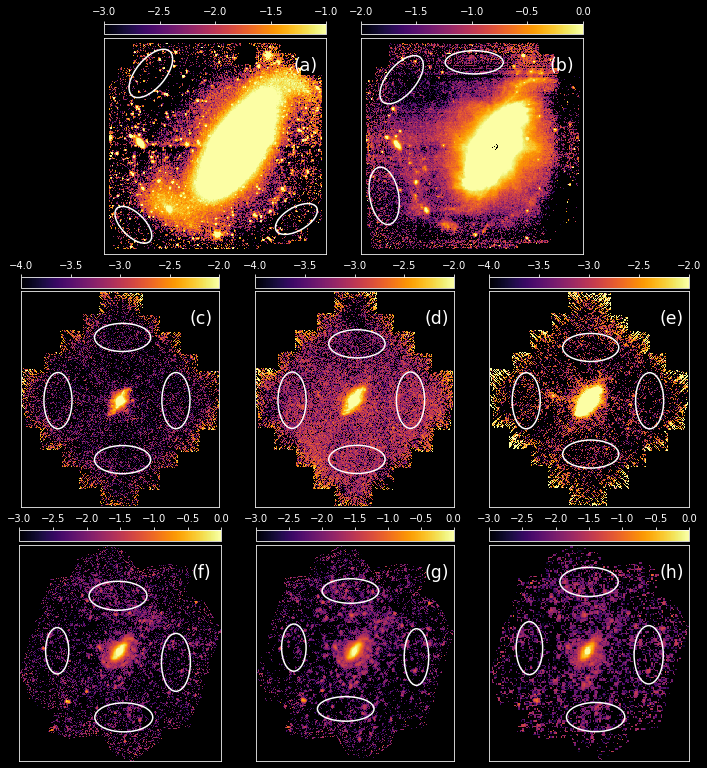

In [238]:
def ax_cbar(img,ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top",size="5%", pad=0.05)
    fig.colorbar(img, cax,orientation='horizontal')
    cax.xaxis.set_ticks_position('top')

#fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(nrows=3,ncols=3,figsize=(12,12))
fig = plt.figure(figsize=(3.1,3.2))

ax1 = fig.add_axes([0.5-.075,2.2,1,1])
data = fits.getdata('ch2_mosaic.fits')
img1 = ax1.imshow(np.log10(data),vmin=-3,vmax=-1,cmap='inferno')#,aspect='auto')
ax_cbar(img1,ax1)
sky1,w1,ellipse1 = background(data,80,310,25,50,-40)
sky2,w2,ellipse2 = background(data,50,50,20,40,45)
sky3,w3,ellipse3 = background(data,330,60,40,20,30)
ax1.add_patch(ellipse1)
ax1.add_patch(ellipse2)
ax1.add_patch(ellipse3)
ax1.text(data.shape[1]*.85,data.shape[0]*.85,'(a)',fontsize='xx-large')#,fontweight='bold')
ax1.set_ylim(0,data.shape[0])
ax1.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax2 = fig.add_axes([1.5+.075,2.2,1,1])
data = fits.getdata('ngc1808_8_Kane.fits')
img2 = ax2.imshow(np.log10(data),vmin=-2,vmax=0,cmap='inferno')#,aspect='auto')
ax_cbar(img2,ax2)
sky1,w1,ellipse1 = background(data,195,330,50,20,0)
sky2,w2,ellipse2 = background(data,70,300,25,50,-40)
sky3,w3,ellipse3 = background(data,40,130-30,20+5,40+10,10)
ax2.add_patch(ellipse1)
ax2.add_patch(ellipse2)
ax2.add_patch(ellipse3)
ax2.text(data.shape[1]*.85,data.shape[0]*.85,'(b)',fontsize='xx-large')#,fontweight='bold')
ax2.set_ylim(0,data.shape[0])
ax2.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax3 = fig.add_axes([0,1.1,1,1])
data = fits.getdata('ngc1808_70.fits')
img3 = ax3.imshow(np.log10(data),vmin=-4,vmax=-2,cmap='inferno')#,aspect='auto')
ax_cbar(img3,ax3)
sky1,w1,ellipse1 = background(data,360,630-25,100,50,0)
sky2,w2,ellipse2 = background(data,130,380,50,100,0)
sky3,w3,ellipse3 = background(data,360,170,100,50,0)
sky4,w4,ellipse4 = background(data,550,380,50,100,0)
ax3.add_patch(ellipse1)
ax3.add_patch(ellipse2)
ax3.add_patch(ellipse3)
ax3.add_patch(ellipse4)
ax3.text(data.shape[1]*.85,data.shape[0]*.85,'(c)',fontsize='xx-large')
ax3.set_ylim(0,data.shape[0])
ax3.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax4 = fig.add_axes([1.05,1.1,1,1])
data = fits.getdata('ngc1808_100.fits')
img4 = ax4.imshow(np.log10(data),vmin=-4,vmax=-2,cmap='inferno')#,aspect='auto')
ax_cbar(img4,ax4)
sky1,w1,ellipse1 = background(data,360,580,100,50,0)#,ls='-.'
sky2,w2,ellipse2 = background(data,130,380,50,100,0)
sky3,w3,ellipse3 = background(data,360,170,100,50,0)
sky4,w4,ellipse4 = background(data,550,380,50,100,0)
ax4.add_patch(ellipse1)
ax4.add_patch(ellipse2)
ax4.add_patch(ellipse3)
ax4.add_patch(ellipse4)
ax4.text(data.shape[1]*.85,data.shape[0]*.85,'(d)',fontsize='xx-large')
ax4.set_ylim(0,data.shape[0])
ax4.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax5 = fig.add_axes([2.1,1.1,1,1])
data = fits.getdata('ngc1808_160.fits')
img5 = ax5.imshow(np.log10(data),vmin=-4,vmax=-2,cmap='inferno')#,aspect='auto')
ax_cbar(img5,ax5)
sky1,w1,ellipse1 = background(data,180,315-30,50,25,0)
sky2,w2,ellipse2 = background(data,65,190,25,50,0)
sky3,w3,ellipse3 = background(data,180,95,50,25,0)
sky4,w4,ellipse4 = background(data,285,190,25,50,0)
ax5.add_patch(ellipse1)
ax5.add_patch(ellipse2)
ax5.add_patch(ellipse3)
ax5.add_patch(ellipse4)
ax5.text(data.shape[1]*.85,data.shape[0]*.85,'(e)',fontsize='xx-large')
ax5.set_ylim(0,data.shape[0])
ax5.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax6 = fig.add_axes([0,0,1,1])
data = fits.getdata('ngc1808_250.fits')
img6 = ax6.imshow(np.log10(data),vmin=-3,vmax=0,cmap='inferno')#,aspect='auto')
ax_cbar(img6,ax6)
sky1,w1,ellipse1 = background(data,170,285,50,25,0)
sky2,w2,ellipse2 = background(data,65,190,20,40,0)
sky3,w3,ellipse3 = background(data,180,75,50,25,0)
sky4,w4,ellipse4 = background(data,270,170,25,50,0)
ax6.add_patch(ellipse1)
ax6.add_patch(ellipse2)
ax6.add_patch(ellipse3)
ax6.add_patch(ellipse4)
ax6.text(data.shape[1]*.85,data.shape[0]*.85,'(f)',fontsize='xx-large')
ax6.set_ylim(0,data.shape[0])
ax6.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax7 = fig.add_axes([1.05,0,1,1])
data = fits.getdata('ngc1808_350.fits')
img7 = ax7.imshow(np.log10(data),vmin=-3,vmax=0,cmap='inferno')#,aspect='auto')
ax_cbar(img7,ax7)
sky1,w1,ellipse1 = background(data,100,180,30,13,0)
sky2,w2,ellipse2 = background(data,40,120,13,25,0)
sky3,w3,ellipse3 = background(data,95,55,30,13,0)
sky4,w4,ellipse4 = background(data,170,110,13,30,0)
ax7.add_patch(ellipse1)
ax7.add_patch(ellipse2)
ax7.add_patch(ellipse3)
ax7.add_patch(ellipse4)
ax7.text(data.shape[1]*.85,data.shape[0]*.85,'(g)',fontsize='xx-large')
ax7.set_ylim(0,data.shape[0])
ax7.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

ax8 = fig.add_axes([2.1,0,1,1])
data = fits.getdata('ngc1808_500.fits')
img8 = ax8.imshow(np.log10(data),vmin=-3,vmax=0,cmap='inferno')#,aspect='auto')
ax_cbar(img8,ax8)
sky1,w1,ellipse1 = background(data,75,135,22,11,0)
sky2,w2,ellipse2 = background(data,30,85,10,20,0)
sky3,w3,ellipse3 = background(data,80,33,22,11,0)
sky4,w4,ellipse4 = background(data,120,80,11,22,0)
ax8.add_patch(ellipse1)
ax8.add_patch(ellipse2)
ax8.add_patch(ellipse3)
ax8.add_patch(ellipse4)
ax8.text(data.shape[1]*.85,data.shape[0]*.85,'(h)',fontsize='xx-large')
ax8.set_ylim(0,data.shape[0])
ax8.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('skyzones.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [ ]:
plt.style.use('dark_background')
#ax = plt.axes
#ax.set_facecolor('black')
plt.figure(facecolor='white')
grid = plt.GridSpec(6,6,wspace=0,hspace=0)

plt.subplot(grid[0:2,1:3],facecolor='black')
data = fits.getdata('ch2_mosaic.fits')
plt.imshow(np.log10(data),vmin=-3,vmax=-1,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,80,310,25,50,-40)
sky2,w2,ellipse2 = background(data,50,50,20,40,45)
sky3,w3,ellipse3 = background(data,330,60,40,20,30)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(a)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3)
print('4.5 µm sky: ',(sky1*w1+sky2*w2+sky3*w3)/(w1+w2+w3))

plt.subplot(grid[0:2,3:5],facecolor='black')
data = fits.getdata('ngc1808_8_Kane.fits')
plt.imshow(np.log10(data),vmin=-2,vmax=0,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,195,330,50,20,0)
sky2,w2,ellipse2 = background(data,70,300,25,50,-40)
sky3,w3,ellipse3 = background(data,40,130-30,20+5,40+10,10)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(b)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3)#,'\n',sky4)
print('8 µm sky: ',(sky1*w1+sky2*w2+sky3*w3)/(w1+w2+w3))

plt.subplot(grid[2:4,0:2])
data = fits.getdata('ngc1808_70.fits')
plt.imshow(np.log10(data),vmin=-4,vmax=-2,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,360,630-25,100/5,50/5,0)
sky2,w2,ellipse2 = background(data,130,380,50/5,100/5,0)
sky3,w3,ellipse3 = background(data,360,170,100/5,50/5,0)
sky4,w4,ellipse4 = background(data,550,380,50/5,100/5,0)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.gca().add_patch(ellipse4)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(c)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3,'\t',sky4)
print('70 µm sky: ',(sky1*w1+sky2*w2+sky3*w3+sky4*w4)/(w1+w2+w3+w4))

plt.subplot(grid[2:4,2:4])
data = fits.getdata('ngc1808_100.fits')
plt.imshow(np.log10(data),vmin=-4,vmax=-2,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,360,580,100,50,0)#,ls='-.'
sky2,w2,ellipse2 = background(data,130,380,50,100,0)
sky3,w3,ellipse3 = background(data,360,170,100,50,0)
sky4,w4,ellipse4 = background(data,550,380,50,100,0)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.gca().add_patch(ellipse4)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(d)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3,'\t',sky4)
print('100 µm sky: ',(sky1*w1+sky2*w2+sky3*w3+sky4*w4)/(w1+w2+w3+w4))

plt.subplot(grid[2:4,4:])
data = fits.getdata('ngc1808_160.fits')
plt.imshow(np.log10(data),vmin=-4,vmax=-2,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,180,315-30,50,25,0)
sky2,w2,ellipse2 = background(data,65,190,25,50,0)
sky3,w3,ellipse3 = background(data,180,95,50,25,0)
sky4,w4,ellipse4 = background(data,285,190,25,50,0)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.gca().add_patch(ellipse4)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(e)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3,'\t',sky4)
print('160 µm sky: ',(sky1*w1+sky2*w2+sky3*w3+sky4*w4)/(w1+w2+w3+w4))

plt.subplot(grid[4:,0:2])
data = fits.getdata('ngc1808_250.fits')
plt.imshow(np.log10(data),vmin=-3,vmax=0,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,170,285,50,25,0)
sky2,w2,ellipse2 = background(data,65,190,20,40,0)
sky3,w3,ellipse3 = background(data,180,75,50,25,0)
sky4,w4,ellipse4 = background(data,270,170,25,50,0)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.gca().add_patch(ellipse4)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(f)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3,'\t',sky4)
print('250 µm sky: ',(sky1*w1+sky2*w2+sky3*w3+sky4*w4)/(w1+w2+w3+w4))

plt.subplot(grid[4:,2:4])
data = fits.getdata('ngc1808_350.fits')
plt.imshow(np.log10(data),vmin=-3,vmax=0,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,100,180,30,13,0)
sky2,w2,ellipse2 = background(data,40,120,13,25,0)
sky3,w3,ellipse3 = background(data,95,55,30,13,0)
sky4,w4,ellipse4 = background(data,170,110,13,30,0)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.gca().add_patch(ellipse4)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(g)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3,'\t',sky4)
print('350 µm sky: ',(sky1*w1+sky2*w2+sky3*w3+sky4*w4)/(w1+w2+w3+w4))

plt.subplot(grid[4:,4:])
data = fits.getdata('ngc1808_500.fits')
plt.imshow(np.log10(data),vmin=-3,vmax=0,cmap='inferno',aspect='auto')
sky1,w1,ellipse1 = background(data,75,135,22,11,0)
sky2,w2,ellipse2 = background(data,30,85,10,20,0)
sky3,w3,ellipse3 = background(data,80,33,22,11,0)
sky4,w4,ellipse4 = background(data,120,80,11,22,0)
plt.gca().add_patch(ellipse1)
plt.gca().add_patch(ellipse2)
plt.gca().add_patch(ellipse3)
plt.gca().add_patch(ellipse4)
plt.text(data.shape[1]*.85,data.shape[0]*.85,'(h)')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.colorbar()
#print('\t',sky1,'\t',sky2,'\t',sky3,'\t',sky4)
print('500 µm sky: ',(sky1*w1+sky2*w2+sky3*w3+sky4*w4)/(w1+w2+w3+w4))

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('skyzones.png',dpi=600,bbox_inches='tight',pad_inches=0)

In [ ]:
fig = plt.figure(figsize=(8,4),facecolor='white')

fig.add_subplot(1,2,1,facecolor='black')
data = fits.getdata('ch4_residual_mosaic.fits')
plt.imshow(np.log10(data),vmin=-2,vmax=-0.3,cmap='inferno',aspect='equal')
plt.plot([0,222],[164,164],'k--',lw=0.8)
plt.plot([0,222],[171,171],'k--',lw=0.8)
plt.plot([25,25],[167-9,167+10],'k',lw=0.8)
plt.plot([30,30],[167-9,167+10],'k',lw=0.8)
plt.plot([25,30],[167-9,167-9],'k',lw=0.8)
plt.plot([25,30],[167+10,167+10],'k',lw=0.8)

plt.plot([70,70],[167-9,167+10],'k',lw=0.8)
plt.plot([75,75],[167-9,167+10],'k',lw=0.8)
plt.plot([70,75],[167-9,167-9],'k',lw=0.8)
plt.plot([70,75],[167+10,167+10],'k',lw=0.8)

plt.plot([120,120],[167-9,167+10],'k',lw=0.8)
plt.plot([125,125],[167-9,167+10],'k',lw=0.8)
plt.plot([120,125],[167-9,167-9],'k',lw=0.8)
plt.plot([120,125],[167+10,167+10],'k',lw=0.8)

plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

fig.add_subplot(1,2,2,facecolor='black')
data = fits.getdata('ngc1808_8_Kane.fits')
plt.imshow(np.log10(data),vmin=-2,vmax=-0.3,cmap='inferno',aspect='equal')
plt.ylim(0,data.shape[0])
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('artefact_removal.png',dpi=600,bbox_inches='tight',pad_inches=0)

In [ ]:
file1 = 2
file2 = 1
sky_1 = sky[file1]
file_1 = file[file1]
data_1 = fits.getdata(file_1)
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    data_1 = fits.getdata(file_1)[:,:330]
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7 or file1==8:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
else:#elif file1==8 or file1==9 or file1==10 or file1==11 or file1==12 or file1==13:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]

sky_2 = sky[file2]
file_2 = file[file2]
data_2 = fits.getdata(file_2)-sky_2
if file2==6:
    data_2 = data_2/((fwhm_250/6)**2*np.pi/4) #6
elif file2==7:
    data_2 = data_2/((fwhm_350/10)**2*np.pi/4) #10
elif file2==8:
    data_2 = data_2/((fwhm_500/14)**2*np.pi/4) #14

if file2==0 or file2==1:
    hdu_2 = fits.open(get_pkg_data_filename(file_2))[0]
    data_2 = fits.getdata(file_2)[:,:330]-sky_2
elif file2==2 or file2==3 or file2==4 or file2==5 or file2==6 or file2==7 or file2==8:
    hdu_2 = fits.open(get_pkg_data_filename(file_2))[1]
elif 9<=file2<=14+15:#file2==8 or file2==9 or file2==10 or file2==11:
    hdu_2 = fits.open(get_pkg_data_filename(file_2))[0]

rescale = data_2.size/data_1.size
scale_1 = abs(hdu_1.header['CDELT1'])*60**2
FOV_area_1 = (scale_1*np.shape(data_1)[0]/60)*(scale_1*np.shape(data_1)[1]/60)

scale_2 = abs(hdu_2.header['CDELT1'])*60**2
FOV_area_2 = (scale_2*np.shape(data_2)[0]/60)*(scale_2*np.shape(data_2)[1]/60)

rescale*FOV_area_1/FOV_area_2

In [3]:
def resizing(file1,file2,zoom):
    sky_1 = sky[file1]
    file_1 = file[file1]
    data_1 = fits.getdata(file_1)
    if file1==0 or file1==1:
        hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
        data_1 = fits.getdata(file_1)[:,:330]
    elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7 or file1==8:
        hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    else:#elif file1==8 or file1==9 or file1==10 or file1==11 or file1==12 or file1==13:
        hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]

    sky_2 = sky[file2]
    file_2 = file[file2]
    data_2 = fits.getdata(file_2)-sky_2
    if file2==6:
        data_2 = data_2/((fwhm_250/6)**2*np.pi/4) #6
    elif file2==7:
        data_2 = data_2/((fwhm_350/10)**2*np.pi/4) #10
    elif file2==8:
        data_2 = data_2/((fwhm_500/14)**2*np.pi/4) #14
    
    if file2==0 or file2==1:
        hdu_2 = fits.open(get_pkg_data_filename(file_2))[0]
        data_2 = fits.getdata(file_2)[:,:330]-sky_2
    elif file2==2 or file2==3 or file2==4 or file2==5 or file2==6 or file2==7 or file2==8:
        hdu_2 = fits.open(get_pkg_data_filename(file_2))[1]
    elif 9<=file2<=14+15:#file2==8 or file2==9 or file2==10 or file2==11:
        hdu_2 = fits.open(get_pkg_data_filename(file_2))[0]

    rescale = data_2.size/data_1.size
    scale_1 = abs(hdu_1.header['CDELT1'])*60**2
    FOV_area_1 = (scale_1*np.shape(data_1)[0]/60)*(scale_1*np.shape(data_1)[1]/60)

    scale_2 = abs(hdu_2.header['CDELT1'])*60**2
    FOV_area_2 = (scale_2*np.shape(data_2)[0]/60)*(scale_2*np.shape(data_2)[1]/60)

    data_1 = hdu_1.data - sky_1

    coords_1 = WCS(hdu_1.header)
    coords_2 = WCS(hdu_2.header)
    reproject = np.ndarray(data_1.shape)
    array, footprint = reproject_interp((data_2,coords_2),coords_1,shape_out=data_1.shape,output_array=reproject)
    data_2 = array*rescale*FOV_area_1/FOV_area_2

    data_1 = data_1[int((data_1.shape[0]/2)*(1-1/zoom)):int((data_1.shape[0]/2)*(1+1/zoom)),int((data_1.shape[1]/2)*(1-1/zoom)):int((data_1.shape[1]/2)*(1+1/zoom))]
    data_2 = data_2[int((data_2.shape[0]/2)*(1-1/zoom)):int((data_2.shape[0]/2)*(1+1/zoom)),int((data_2.shape[1]/2)*(1-1/zoom)):int((data_2.shape[1]/2)*(1+1/zoom))]
    
    return data_1,data_2

In [4]:
def convolution(data,file1,file2):
    gauss = np.sqrt(fwhm[file2]**2-fwhm[file1]**2)
    sig = gauss/4.71
    gaussian = Gaussian2DKernel(sig,sig)
    convolved_product = convolve(data,gaussian)
    return convolved_product

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in log10


<Figure size 432x288 with 0 Axes>

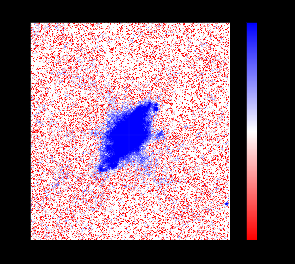

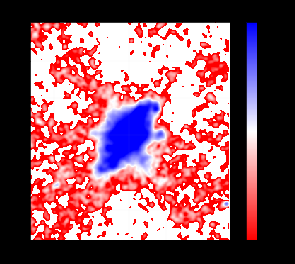

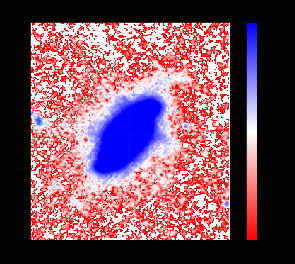

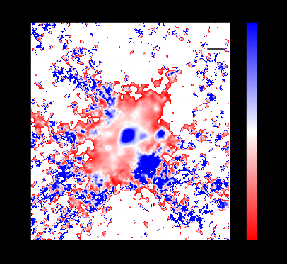

In [5]:
file1=2
file2=4
zoom=2.5

plt.figure(facecolor='white')

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']

ngc1808_70,ngc1808_160_v1 = resizing(file1,file2,zoom)
ngc1808_70,ngc1808_160_v2 = resizing(file1,file2+1,zoom)
ngc1808_160 = (ngc1808_160_v1+ngc1808_160_v2)/2
convolved_70 = convolution(ngc1808_70,2,4)
yy,xx = convolved_70.shape

yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))

#a,b = hdu_1.shape
x0 = int(xx/2)
y0 = int(yy/2)
#x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#xlocs = np.arange(-150,153,30)+x0
#y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#ylocs = np.arange(-150,153,30)+y0
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

xxlocs = xlocs-x0+int(xx/2)
yylocs = ylocs-y0+int(yy/2)

X,Y = np.meshgrid(np.linspace(0,xx-1,xx),np.linspace(0,yy-1,yy))

plt.figure(facecolor='black')
plt.imshow(np.log10(ngc1808_70),cmap='bwr_r',vmin=-4,vmax=-2.5)
plt.colorbar()
plt.title('Log 70 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.grid(lw=0.05)
#cont = plt.contour(X,Y,np.log10(ngc1808_70),levels=np.array([-2.5,-1]),colors='black')
#plt.clabel(cont,colors='black',fontsize='small')
#plt.savefig('NGC1808_log70.png',dpi=200)

plt.figure(facecolor='black')
plt.imshow(np.log10(convolved_70),cmap='bwr_r',vmin=-4,vmax=-2.5)
plt.colorbar()
plt.title('Log Convolved 70 µm (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.05)
#cont = plt.contour(X,Y,np.log10(convolved_70),levels=np.array([-2.5,-1]),colors='black')
#plt.clabel(cont,colors='black',fontsize='small')
#plt.savefig('NGC1808_logc70.png',dpi=200)

plt.figure(facecolor='black')
plt.imshow(np.log10(ngc1808_160),cmap='bwr_r',vmin=-4,vmax=-2.5)
plt.colorbar()
plt.title('Log 160 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid(lw=0.05)

'''plt.figure()
plt.imshow(ngc1808_160_v2-ngc1808_160_v1,cmap='bwr_r',vmin=-1e-3,vmax=1e-3)
plt.colorbar()
plt.title('Redidual 160 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid(lw=0.05)'''
#cont = plt.contour(X,Y,np.log10(ngc1808_160),levels=np.array([-2.5,-1]),colors='black')
#plt.clabel(cont,colors='black',fontsize='small')
#plt.savefig('NGC1808_log160.png',dpi=200)

ratio = 10.0**np.log10(convolved_70)/10.0**np.log10(ngc1808_160)
plt.figure(facecolor='black')
plt.imshow(ratio,cmap='bwr_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('Convolved 70 µm/160 µm Ratio')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.grid(lw=0.05)
#plt.contour(X,Y,np.log10(convolved_4pt5),levels=np.array([-1.5]),colors='black',linewidths=1)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
#plt.contour(X,Y,10**np.log10(convolved_8)/10**np.log10(convolved_4pt5),levels=np.array([2,7]),colors='0.35',linewidths=1)
#plt.savefig('NGC1808_mc70160ratio.png',dpi=200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


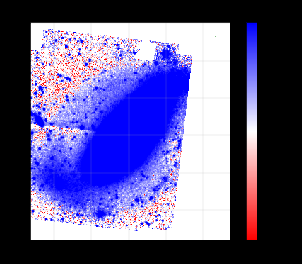

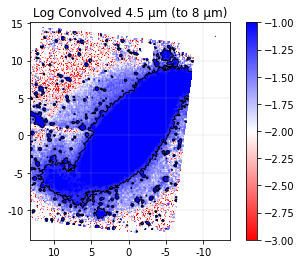

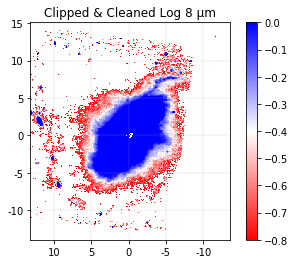

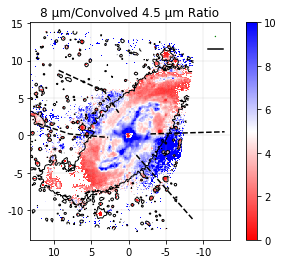

In [6]:
file1=2
file2=0
zoom=2.5

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']
elif file1==8 or file1==9:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = 1.5

data_1,ngc1808_4pt5 = resizing(file1,file2,zoom)
convolved_4pt5 = convolution(ngc1808_4pt5,0,1)
yy,xx = convolved_4pt5.shape

#a,b = hdu_1.shape
x0 = int(xx/2)
y0 = int(yy/2)
#x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#xlocs = np.arange(-150,153,30)+x0
#y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#ylocs = np.arange(-150,153,30)+y0
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

xxlocs = xlocs-x0+int(xx/2)
yylocs = ylocs-y0+int(yy/2)

vmin=0
vmax=0.001

X,Y = np.meshgrid(np.linspace(0,xx-1,xx),np.linspace(0,yy-1,yy))

plt.figure(facecolor='black')
plt.imshow(np.log10(ngc1808_4pt5),cmap='bwr_r',vmin=-3,vmax=-1)
plt.colorbar()
plt.title('Log 4.5 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_4pt5.shape[0])
plt.xlim(0,ngc1808_4pt5.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_4pt5/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_log4pt5.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_4pt5),cmap='bwr_r',vmin=-3,vmax=-1)
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
plt.title('Log Convolved 4.5 µm (to 8 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_logc4pt5.png',dpi=200)

file2=1
data_1,ngc1808_8 = resizing(file1,file2,zoom)

mask8 = np.zeros((ngc1808_8.shape),dtype=int)
for i in range(mask8.shape[0]):
    for j in range(mask8.shape[1]):
        if 0.15<ngc1808_8[i,j]: #0.025
            mask8[i,j]=1
            
clipped_8 = ngc1808_8*mask8 #Now that I'm switching the 8 µm file to my cleaned one, this line will give a different matrix

plt.figure()
plt.imshow(np.log10(clipped_8),cmap='bwr_r',vmin=-0.8,vmax=0)
plt.colorbar()
plt.title('Clipped & Cleaned Log 8 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_log8.png',dpi=200)

plt.figure()
plt.imshow(10**np.log10(clipped_8)/10**np.log10(convolved_4pt5*mask8),cmap='bwr_r',vmin=0,vmax=10)
plt.colorbar()
plt.title('8 µm/Convolved 4.5 µm Ratio')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
plt.plot([150,200+30],[120,50-21],'k--')
plt.plot([170,275],[150,153],'k--')
plt.plot([10,55,110],[165,150,145],'k--')
plt.plot([40,105,125],[240,210,180],'k--')
#plt.savefig('NGC1808_8c45ratio.png',dpi=200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-p

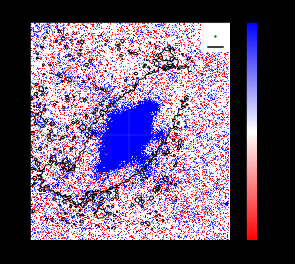

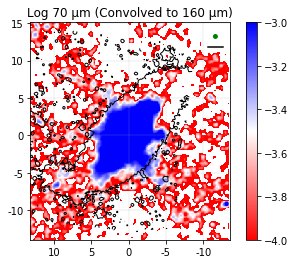

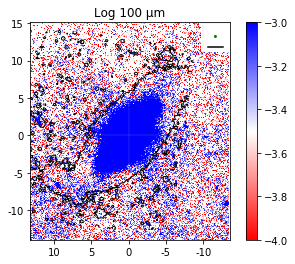

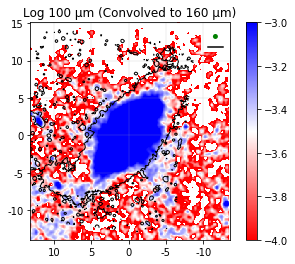

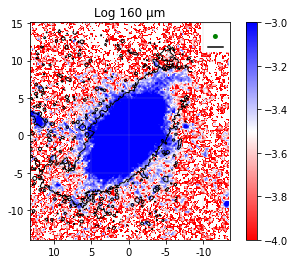

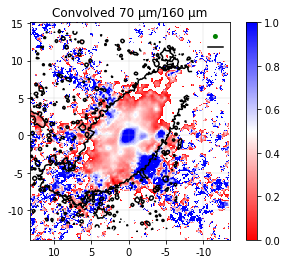

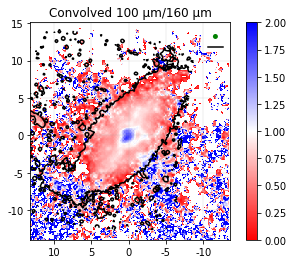

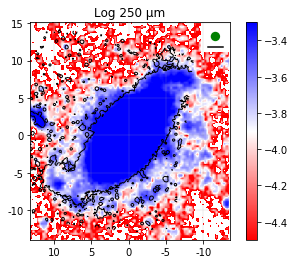

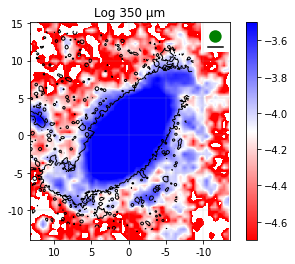

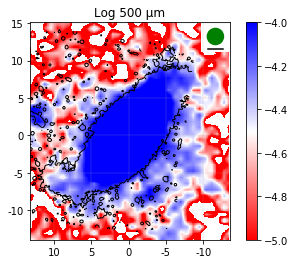

In [7]:
file1=2
file2=3
zoom=2.5

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']
elif file1==8 or file1==9:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = 1.5

ngc1808_70,ngc1808_100 = resizing(file1,file2,zoom)

convolved_70_500 = convolution(ngc1808_70,2,8)
convolved_70 = convolution(ngc1808_70,2,4)
convolved_100_500 = convolution(ngc1808_100,3,8)
convolved_100 = convolution(ngc1808_100,3,4)
yy,xx = convolved_70.shape

file2=4
data1,ngc1808_160_v1 = resizing(file1,file2,zoom)
file2=5
data1,ngc1808_160_v2 = resizing(file1,file2,zoom)
ngc1808_160 = (ngc1808_160_v1+ngc1808_160_v2)/2
convolved_160 = convolution(ngc1808_160,4,8)

file2=6
data1,ngc1808_250 = resizing(file1,file2,zoom)
convolved_250 = convolution(ngc1808_250,6,8)
convolved_250_350 = convolution(ngc1808_250,6,7)

file2=7
data1,ngc1808_350 = resizing(file1,file2,zoom)
convolved_350 = convolution(ngc1808_350,7,8)

file2=8
data1,ngc1808_500 = resizing(file1,file2,zoom)

yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

X,Y = np.meshgrid(np.linspace(0,xx-1,xx),np.linspace(0,yy-1,yy))

plt.figure(facecolor='black')
plt.imshow(np.log10(ngc1808_70),cmap='bwr_r',vmin=-4,vmax=-3)
plt.colorbar()
plt.title('Log 70 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_70/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_log70.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_70),cmap='bwr_r',vmin=-4,vmax=-3)
plt.colorbar()
plt.title('Log 70 µm (Convolved to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_logc70.png',dpi=200)

plt.figure()
plt.imshow(np.log10(ngc1808_100),cmap='bwr_r',vmin=-4,vmax=-3)
plt.colorbar()
plt.title('Log 100 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_100/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_log100.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_100),cmap='bwr_r',vmin=-4,vmax=-3)
plt.colorbar()
plt.title('Log 100 µm (Convolved to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_logc100.png',dpi=200)

plt.figure()
plt.imshow(np.log10(ngc1808_160),cmap='bwr_r',vmin=-4,vmax=-3)
plt.colorbar()
plt.title('Log 160 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_log160.png',dpi=200)

plt.figure()
plt.imshow(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),cmap='bwr_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('Convolved 70 µm/160 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.06]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
#plt.savefig('NGC1808_c70160ratio.png',dpi=200)

plt.figure()
plt.imshow(10**np.log10(convolved_100)/10**np.log10(ngc1808_160),cmap='bwr_r',vmin=0,vmax=2)
plt.colorbar()
plt.title('Convolved 100 µm/160 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.06]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
#plt.savefig('NGC1808_c100160ratio.png',dpi=200)

plt.figure()
plt.imshow(np.log10(ngc1808_250),cmap='bwr_r',vmin=-4.5,vmax=-3.3)
plt.colorbar()
plt.title('Log 250 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_250/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_log250.png',dpi=200)

plt.figure()
plt.imshow(np.log10(ngc1808_350),cmap='bwr_r',vmin=-4.7,vmax=-3.5)
plt.colorbar()
plt.title('Log 350 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_350/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_log350.png',dpi=200)

plt.figure()
plt.imshow(np.log10(ngc1808_500),cmap='bwr_r',vmin=-5,vmax=-4)
plt.colorbar()
plt.title('Log 500 µm')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
#plt.savefig('NGC1808_log500.png',dpi=200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/pyth

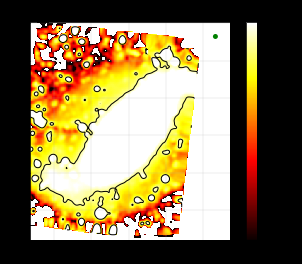

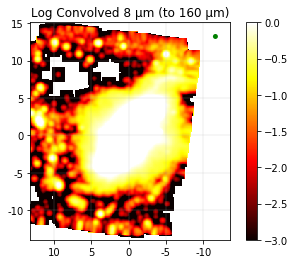

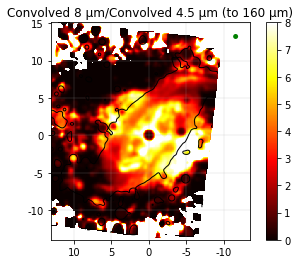

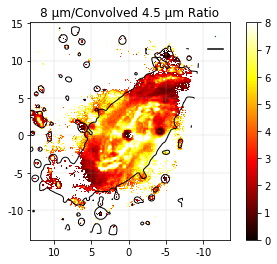

In [8]:
file1=2
file2=0
zoom=2.5

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']
elif file1==8 or file1==9:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = 1.5

data_1,ngc1808_4pt5 = resizing(file1,file2,zoom)
convolved_4pt5 = convolution(ngc1808_4pt5,0,4)
yy,xx = convolved_4pt5.shape

#a,b = hdu_1.shape
x0 = int(xx/2)
y0 = int(yy/2)
#x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#xlocs = np.arange(-150,153,30)+x0
#y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#ylocs = np.arange(-150,153,30)+y0
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

xxlocs = xlocs-x0+int(xx/2)
yylocs = ylocs-y0+int(yy/2)

plt.figure(facecolor='black')
plt.imshow(np.log10(convolved_4pt5),cmap='hot',vmin=-3,vmax=-1)
plt.colorbar()
plt.title('Log Convolved 4.5 µm (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_c4pt5_160.png',dpi=200)

file2=1
data_1,ngc1808_8 = resizing(file1,file2,zoom)
convolved_8 = convolution(clipped_8,1,4)

plt.figure()
plt.imshow(np.log10(convolved_8),cmap='hot',vmin=-3,vmax=0)
plt.colorbar()
plt.title('Log Convolved 8 µm (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_c8_160.png',dpi=200)

plt.figure()
plt.imshow(10**np.log10(convolved_8)/10**np.log10(convolved_4pt5),cmap='hot',vmin=vmin,vmax=8)
plt.colorbar()
plt.title('Convolved 8 µm/Convolved 4.5 µm (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cSpitzer160.png',dpi=200)

plt.figure()
plt.imshow(10**np.log10(clipped_8)/10**np.log10(convolved_4pt5*mask8),cmap='hot',vmin=0,vmax=8)
plt.colorbar()
plt.title('8 µm/Convolved 4.5 µm Ratio')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
#plt.savefig('NGC1808_8c45ratio.png',dpi=200)

In [9]:
def plots(img,ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top",size="5%", pad=0.05)
    fig.colorbar(img, cax,orientation='horizontal')
    cax.xaxis.set_ticks_position('top')
    
    #ax.set_ylabel('kpc')
    #ax.set_xlabel('kpc')
    x = np.arange(-15,16,5)
    y = np.arange(-15,16,5)
    xlocs = 60/(3.54*1.6)*x + xc
    ylocs = 60/(3.54*1.6)*y + yc
    
    ax.set_xticks(xlocs)
    ax.set_xticklabels(np.flip(x))
    ax.set_yticks(ylocs)
    ax.set_yticklabels(np.flip(y))
    ax.set_ylim(0,ngc1808_70.shape[0])
    ax.set_xlim(0,ngc1808_70.shape[1])
    
def draw_lines(ax):
    ax.plot([150,200+30],[120,50-21],'cyan',ls='--',lw=1.5)
    ax.plot([170,275],[150,153],'cyan',ls='--',lw=1.5)
    #ax.plot([10,55,110],[165,150,145],'cyan',ls='--',lw=1.5)
    ax.plot([55,110],[150,145],'cyan',ls='--',lw=1.5)
    ax.plot([40,105,125],[240,210,180],'cyan',ls='--',lw=1.5)
def label_lines(ax):
    ax.text(180,40,'D',size='xx-large',fontweight='bold')
    ax.text(230,165,'C',size='xx-large',fontweight='bold')
    ax.text(50,125,'A',size='xx-large',fontweight='bold')
    ax.text(100,230,'B',size='xx-large',fontweight='bold')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in log10

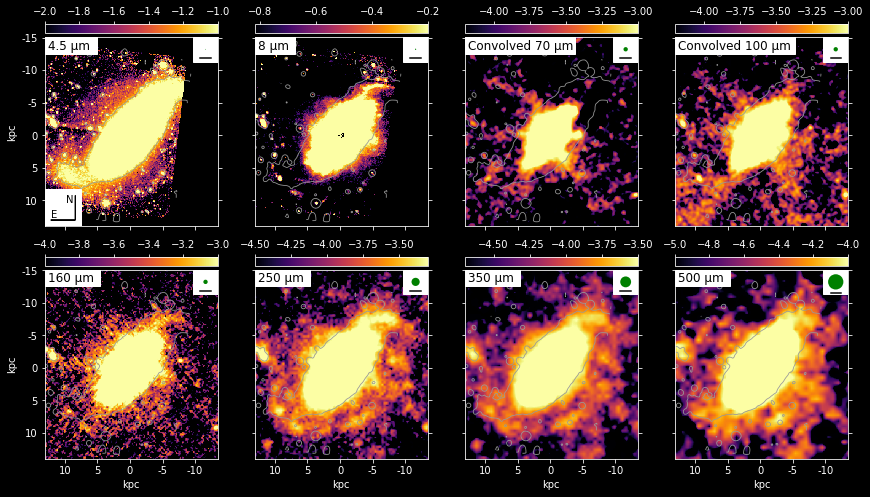

In [21]:
plt.style.use('dark_background')
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2,ncols=4,figsize=(16,8))

img1 = ax1.imshow(np.log10(ngc1808_4pt5),cmap='inferno',vmin=-2,vmax=-1)
plots(img1,ax1)
ax1.set_ylabel('kpc')
ax1.tick_params(labelbottom=False,right=True)
ax1.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_4pt5/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax1)
ax1.add_patch(bkg)
ax1.add_patch(beam)
box = Rectangle((0,yy-27),85,27,color='white')
ax1.add_patch(box)
ax1.text(5,yy-20,'4.5 µm',size='large',color='black')
ax1.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
bkg2 = Rectangle((0,0),60,60,color='white')
ax1.add_patch(bkg2)
ax1.arrow(50,10,-40,0,width=.01,color='black')
ax1.text(10,13,'E',size='medium',color='black')
ax1.arrow(50,10,0,40,width=.01,color='black')
ax1.text(35,38,'N',size='medium',color='black')

img2 = ax2.imshow(np.log10(clipped_8),cmap='inferno',vmin=-0.82,vmax=-0.2)
plots(img2,ax2)
ax2.tick_params(labelleft=False,labelbottom=False,right=True)
ax2.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax2)
ax2.add_patch(bkg)
ax2.add_patch(beam)
box = Rectangle((0,yy-27),65,27,color='white')
ax2.add_patch(box)
ax2.text(5,yy-20,'8 µm',size='large',color='black')
ax2.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')

img3 = ax3.imshow(np.log10(convolved_70),cmap='inferno',vmin=-4.2,vmax=-3)
plots(img3,ax3)
ax3.tick_params(labelleft=False,labelbottom=False,right=True)
ax3.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax3)
ax3.add_patch(bkg)
ax3.add_patch(beam)
box = Rectangle((0,yy-27),180,27,color='white')
ax3.add_patch(box)
ax3.text(5,yy-20,'Convolved 70 µm',size='large',color='black')
ax3.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')

img4 = ax4.imshow(np.log10(convolved_100),cmap='inferno',vmin=-4.2,vmax=-3)
plots(img4,ax4)
ax4.tick_params(labelleft=False,labelbottom=False,right=True)
ax4.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax4)
ax4.add_patch(bkg)
ax4.add_patch(beam)
box = Rectangle((0,yy-27),195,27,color='white')
ax4.add_patch(box)
ax4.text(5,yy-20,'Convolved 100 µm',size='large',color='black')
ax4.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')

img5 = ax5.imshow(np.log10(ngc1808_160),cmap='inferno',vmin=-4,vmax=-3)
plots(img5,ax5)
ax5.set_ylabel('kpc')
ax5.set_xlabel('kpc')
ax5.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax5)
ax5.add_patch(bkg)
ax5.add_patch(beam)
box = Rectangle((0,yy-27),90,27,color='white')
ax5.add_patch(box)
ax5.text(5,yy-20,'160 µm',size='large',color='black')
ax5.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')

img6 = ax6.imshow(np.log10(ngc1808_250),cmap='inferno',vmin=-4.5,vmax=-3.3)
plots(img6,ax6)
ax6.set_xlabel('kpc')
ax6.tick_params(labelleft=False,right=True)
ax6.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_250/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax6)
ax6.add_patch(bkg)
ax6.add_patch(beam)
box = Rectangle((0,yy-27),90,27,color='white')
ax6.add_patch(box)
ax6.text(5,yy-20,'250 µm',size='large',color='black')
ax6.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')

img7 = ax7.imshow(np.log10(ngc1808_350),cmap='inferno',vmin=-4.7,vmax=-3.5)
plots(img7,ax7)
ax7.set_xlabel('kpc')
ax7.tick_params(labelleft=False,right=True)
ax7.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_350/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax7)
ax7.add_patch(bkg)
ax7.add_patch(beam)
box = Rectangle((0,yy-27),90,27,color='white')
ax7.add_patch(box)
ax7.text(5,yy-20,'350 µm',size='large',color='black')
ax7.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')

img8 = ax8.imshow(np.log10(ngc1808_500),cmap='inferno',vmin=-5,vmax=-4)
plots(img8,ax8)
ax8.set_xlabel('kpc')
ax8.tick_params(labelleft=False,right=True)
ax8.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
#draw_lines(ax8)
ax8.add_patch(bkg)
ax8.add_patch(beam)
box = Rectangle((0,yy-27),90,27,color='white')
ax8.add_patch(box)
ax8.text(5,yy-20,'500 µm',size='large',color='black')
ax8.plot([xx-20-8.5,xx-20+8.5],[yy-38,yy-38],'k-')

#plt.tight_layout(h_pad=0.05)
fig.subplots_adjust(wspace=-0.2, hspace=0.15)
plt.savefig('IRfluxmaps.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
img1 = ax1.imshow(np.arcsinh(convolved_70),cmap='hot',vmin=6.3e-5,vmax=1e-3)
ax1.set_ylabel('kpc')
ax1.set_xlabel('kpc')
plots(img1,ax1)
#ax1.set_ylim(0,convolved_70.shape[0])
#ax1.colorbar()

img2 = ax2.imshow(np.log10(convolved_70),cmap='hot',vmin=-4.2,vmax=-3)
plots(img2,ax2)
ax2.set_ylabel('kpc')
ax2.set_xlabel('kpc')
#ax2.set_ylim(0,convolved_70.shape[0])
#ax2.colorbar()

In [ ]:
np.arcsinh(10**-3)

In [ ]:
fig = plt.figure(figsize=(16,8),facecolor='white')

fig.add_subplot(2,4,1,facecolor='black')
plt.imshow(np.log10(ngc1808_4pt5),cmap='hot',vmin=-3,vmax=-1,aspect='auto')
plt.colorbar()
plt.ylabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(bottom=False,labelbottom=False)
plt.ylim(0,ngc1808_4pt5.shape[0])
plt.xlim(0,ngc1808_4pt5.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_4pt5/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),65,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'4.5 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,2)
plt.imshow(np.log10(clipped_8),cmap='hot',vmin=-0.8,vmax=0,aspect='auto')
plt.colorbar()
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),50,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'8 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,3)
plt.imshow(np.log10(ngc1808_70),cmap='hot',vmin=-4.2,vmax=-3,aspect='auto')
plt.colorbar()
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8*1.5,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_70/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),60,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'70 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,4)
plt.imshow(np.log10(ngc1808_100),cmap='hot',vmin=-4.2,vmax=-3,aspect='auto')
plt.colorbar()
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False,right=True,labelright=True)
plt.ylabel('kpc')
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8*1.5,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_100/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),70,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'100 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,5)
plt.imshow(np.log10(ngc1808_160),cmap='hot',vmin=-4,vmax=-3,aspect='auto')
plt.colorbar()
plt.ylabel('kpc')
plt.xlabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),70,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'160 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,6)
plt.imshow(np.log10(ngc1808_250),cmap='hot',vmin=-4.5,vmax=-3.3,aspect='auto')
plt.colorbar()
plt.xlabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(left=False,labelleft=False)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_250/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),70,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'250 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,7)
plt.imshow(np.log10(ngc1808_350),cmap='hot',vmin=-4.7,vmax=-3.5,aspect='auto')
plt.colorbar()
plt.xlabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(left=False,labelleft=False)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_350/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),70,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'350 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(2,4,8)
plt.imshow(np.log10(ngc1808_500),cmap='hot',vmin=-5,vmax=-4,aspect='auto')
plt.colorbar()
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.tick_params(left=False,labelleft=False,right=True,labelright=True)
plt.ylabel('kpc')
plt.xlabel('kpc')
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='k',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
box = Rectangle((0,yy-27),70,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'500 µm',size='large',color='black')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')

#plt.subplots_adjust(wspace=0,hspace=0)
#plt.savefig('IRfluxmaps.png',dpi=600,bbox_inches='tight',pad_inches=0)

In [ ]:
pip show matplotlib

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


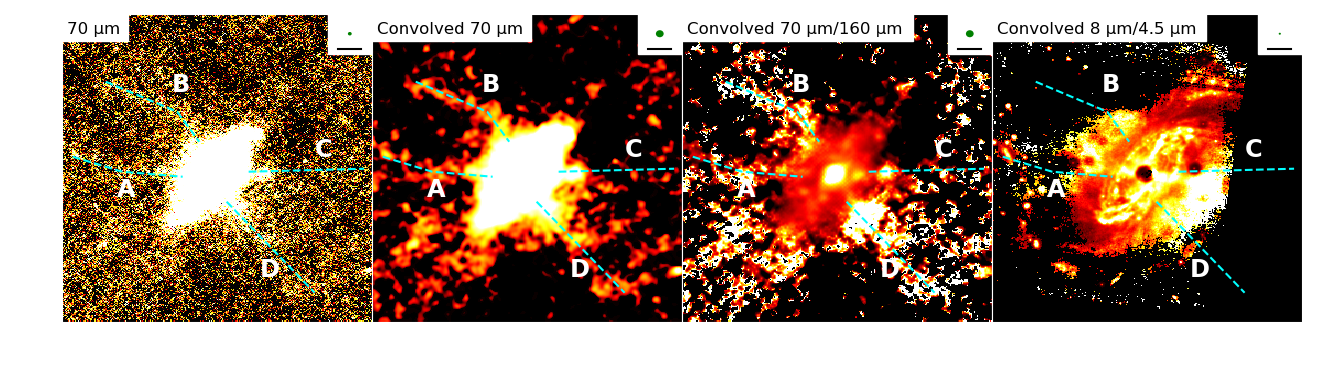

In [247]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(16,4),facecolor='white')
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))

fig.add_subplot(1,4,1,facecolor='black')
#fig.add_subplot(1,4,1,facecolor='black')
plt.imshow(np.log10(ngc1808_70),cmap='hot',vmin=-4.2,vmax=-3,aspect='auto')
#plt.imshow(np.log10(ngc1808_70),cmap='hot',vmin=-4.2,vmax=-3,aspect='auto')
plt.ylabel('kpc')
plt.xlabel('kpc')
yy,xx = convolved_70.shape
x0 = int(xx/2)
y0 = int(yy/2)
#x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#xlocs = np.arange(-150,153,30)+x0
#y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#ylocs = np.arange(-150,153,30)+y0
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.plot([150,200+30],[120,50-21],'cyan',ls='--',lw=1.5)
plt.plot([170,275],[150,153],'cyan',ls='--',lw=1.5)
plt.plot([10,55,110],[165,150,145],'cyan',ls='--',lw=1.5)
plt.plot([40,105,125],[240,210,180],'cyan',ls='--',lw=1.5)
plt.text(180,45,'D',size='xx-large',fontweight='bold')
plt.text(230,165,'C',size='xx-large',fontweight='bold')
plt.text(50,125,'A',size='xx-large',fontweight='bold')
plt.text(100,230,'B',size='xx-large',fontweight='bold')

beam = Circle((xx-20,yy-20),fwhm_70/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),60,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'70 µm',size='large',color='black')

fig.add_subplot(1,4,2)
#plt.subplot(142)
plt.imshow(np.log10(convolved_70),cmap='hot',vmin=-4.2,vmax=-3,aspect='auto')
#plt.colorbar(orientation='horizontal',fraction=0.1,shrink=0.5,pad=0)
plt.xlabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.tick_params(left=False,labelleft=False)
plt.plot([150,200+30],[120,50-21],'cyan',ls='--',lw=1.5)
plt.plot([170,275],[150,153],'cyan',ls='--',lw=1.5)
plt.plot([10,55,110],[165,150,145],'cyan',ls='--',lw=1.5)
plt.plot([40,105,125],[240,210,180],'cyan',ls='--',lw=1.5)
plt.text(180,45,'D',size='xx-large',fontweight='bold')
plt.text(230,165,'C',size='xx-large',fontweight='bold')
plt.text(50,125,'A',size='xx-large',fontweight='bold')
plt.text(100,230,'B',size='xx-large',fontweight='bold')
box = Rectangle((0,yy-27),145,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'Convolved 70 µm',size='large',color='black')

beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

fig.add_subplot(1,4,3)
#plt.subplot(143)
plt.imshow(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),cmap='hot',vmin=0,vmax=1,aspect='auto')
#plt.colorbar(orientation='horizontal',fraction=0.1,shrink=0.5,pad=0)
plt.xlabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.tick_params(left=False,labelleft=False)
plt.plot([150,200+30],[120,50-21],'cyan',ls='--',lw=1.5)
plt.plot([170,275],[150,153],'cyan',ls='--',lw=1.5)
plt.plot([10,55,110],[165,150,145],'cyan',ls='--',lw=1.5)
plt.plot([40,105,125],[240,210,180],'cyan',ls='--',lw=1.5)
plt.text(180,45,'D',size='xx-large',fontweight='bold')
plt.text(230,165,'C',size='xx-large',fontweight='bold')
plt.text(50,125,'A',size='xx-large',fontweight='bold')
plt.text(100,230,'B',size='xx-large',fontweight='bold')

beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

box = Rectangle((0,yy-27),210,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'Convolved 70 µm/160 µm',size='large',color='black')

fig.add_subplot(1,4,4)
#plt.subplot(144)
plt.imshow(10**np.log10(clipped_8)/10**np.log10(convolved_4pt5*mask8),cmap='hot',vmin=0,vmax=8,aspect='auto')
#plt.colorbar(orientation='horizontal',fraction=0.1,shrink=0.5,pad=0)
plt.xlabel('kpc')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.tick_params(left=False,labelleft=False,right=True,labelright=True)
plt.plot([150,200+30],[120,50-21],'cyan',ls='--',lw=1.5)
plt.plot([170,275],[150,153],'cyan',ls='--',lw=1.5)
plt.plot([10,55,110],[165,150,145],'cyan',ls='--',lw=1.5)
plt.plot([40,105,125],[240,210,180],'cyan',ls='--',lw=1.5)
plt.text(180,45,'D',size='xx-large',fontweight='bold')
plt.text(230,165,'C',size='xx-large',fontweight='bold')
plt.text(50,125,'A',size='xx-large',fontweight='bold')
plt.text(100,230,'B',size='xx-large',fontweight='bold')

beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')

box = Rectangle((0,yy-27),195,27,color='white')
plt.gca().add_patch(box)
plt.text(5,yy-20,'Convolved 8 µm/4.5 µm',size='large',color='black')

plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('lines.png',dpi=600,bbox_inches='tight',pad_inches=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


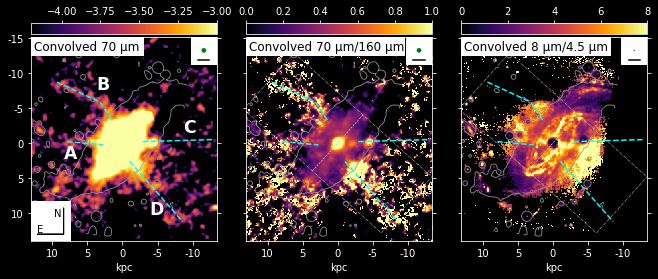

In [22]:
#plt.style.use('dark_background')
fig, (ax2,ax3,ax4) = plt.subplots(ncols=3,figsize=(12,4))

slope = np.tan((ned_pa - 90)*np.pi/180) 
ap_width=38*3
ap_thick=7
dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) 
ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)

'''img1 = ax1.imshow(np.log10(ngc1808_70),cmap='hot',vmin=-4.2,vmax=-3)
plots(img1,ax1)
ax1.set_ylabel('kpc')
ax1.set_xlabel('kpc')
draw_lines(ax1)
beam = Circle((xx-20,yy-20),fwhm_70/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax1.add_patch(bkg)
ax1.add_patch(beam)
ax1.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),70,27,color='white')
ax1.add_patch(box)
ax1.text(5,yy-20,'70 µm',size='large',color='black')
bkg2 = Rectangle((0,0),60,60,color='white')
ax1.add_patch(bkg2)
ax1.arrow(50,10,-40,0,width=.01,color='black')
ax1.text(10,13,'E',size='medium',color='black')
ax1.arrow(50,10,0,40,width=.01,color='black')
ax1.text(35,38,'N',size='medium',color='black')'''

img2 = ax2.imshow(np.log10(convolved_70),cmap='inferno',vmin=-4.2,vmax=-3)
plots(img2,ax2)
ax2.set_xlabel('kpc')
draw_lines(ax2)
label_lines(ax2)
ax2.tick_params(right=True)
ax2.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax2.add_patch(bkg)
ax2.add_patch(beam)
ax2.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),170,27,color='white')
ax2.add_patch(box)
ax2.text(5,yy-20,'Convolved 70 µm',size='large',color='black')
bkg2 = Rectangle((0,0),60,60,color='white')
ax2.add_patch(bkg2)
ax2.arrow(50,10,-40,0,width=.01,color='black')
ax2.text(10,13,'E',size='medium',color='black')
ax2.arrow(50,10,0,40,width=.01,color='black')
ax2.text(35,38,'N',size='medium',color='black')

img3 = ax3.imshow(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),cmap='inferno',vmin=0,vmax=1)
plots(img3,ax3)
ax3.set_xlabel('kpc')
draw_lines(ax3)
ax3.tick_params(right=True,labelleft=False)
ax3.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax3.add_patch(bkg)
ax3.add_patch(beam)
ax3.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),240,27,color='white')
ax3.add_patch(box)
ax3.text(5,yy-20,'Convolved 70 µm/160 µm',size='large',color='black')
ax3.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'0.8',ls='--',lw=0.6)
ax3.plot([xc-dx+20*ddx,xc+dx+20*ddx],[yc-dy-20*ddy,yc+dy-20*ddy],'0.8',ls='-.',lw=0.5) #height confines 
ax3.plot([xc-dx-20*ddx,xc+dx-20*ddx],[yc-dy+20*ddy,yc+dy+20*ddy],'0.8',ls='-.',lw=0.5) #this one is side with arrow
ax3.plot([xc-dx-20*ddx,xc-dx+20*ddx],[yc-dy+20*ddy,yc-dy-20*ddy],'0.8',ls='-.',lw=0.5) #width confines
ax3.plot([xc+dx-20*ddx,xc+dx+20*ddx],[yc+dy+20*ddy,yc+dy-20*ddy],'0.8',ls='-.',lw=0.5)

img4 = ax4.imshow(10**np.log10(clipped_8)/10**np.log10(convolved_4pt5*mask8),cmap='inferno',vmin=0,vmax=8)
plots(img4,ax4)
ax4.set_xlabel('kpc')
draw_lines(ax4)
ax4.tick_params(right=True,labelleft=False)
ax4.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax4.add_patch(bkg)
ax4.add_patch(beam)
ax4.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),225,27,color='white')
ax4.add_patch(box)
ax4.text(5,yy-20,'Convolved 8 µm/4.5 µm',size='large',color='black')
ax4.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'0.8',ls='--',lw=0.6)
ax4.plot([xc-dx+20*ddx,xc+dx+20*ddx],[yc-dy-20*ddy,yc+dy-20*ddy],'0.8',ls='-.',lw=0.5) #height confines 
ax4.plot([xc-dx-20*ddx,xc+dx-20*ddx],[yc-dy+20*ddy,yc+dy+20*ddy],'0.8',ls='-.',lw=0.5) #this one is side with arrow
ax4.plot([xc-dx-20*ddx,xc-dx+20*ddx],[yc-dy+20*ddy,yc-dy-20*ddy],'0.8',ls='-.',lw=0.5) #width confines
ax4.plot([xc+dx-20*ddx,xc+dx+20*ddx],[yc+dy+20*ddy,yc+dy-20*ddy],'0.8',ls='-.',lw=0.5)

#plt.tight_layout(h_pad=0.05)
fig.subplots_adjust(wspace=-0.10, hspace=0)
plt.savefig('lines.png',dpi=600,bbox_inches='tight',pad_inches=0.2)

In [ ]:
#plt.style.use('dark_background')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(16,4))

img1 = ax1.imshow(np.log10(convolved_4pt5),cmap='hot',vmin=-3,vmax=-1)
plots(img1,ax1)
ax1.set_ylabel('kpc')
ax1.set_xlabel('kpc')
ax1.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax1.add_patch(bkg)
ax1.add_patch(beam)
ax1.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),175,27,color='white')
ax1.add_patch(box)
ax1.text(5,yy-20,'Convolved 4.5 µm',size='large',color='black')
bkg2 = Rectangle((0,0),60,60,color='white')
ax1.add_patch(bkg2)
ax1.arrow(50,10,-40,0,width=.01,color='black')
ax1.text(10,13,'E',size='medium',color='black')
ax1.arrow(50,10,0,40,width=.01,color='black')
ax1.text(35,38,'N',size='medium',color='black')

img2 = ax2.imshow(np.log10(convolved_8),cmap='hot',vmin=-3,vmax=0)
plots(img2,ax2)
ax2.set_xlabel('kpc')
ax2.tick_params(left=False,labelleft=False)
ax2.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax2.add_patch(bkg)
ax2.add_patch(beam)
ax2.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),160,27,color='white')
ax2.add_patch(box)
ax2.text(5,yy-20,'Convolved 8 µm',size='large',color='black')

img3 = ax3.imshow(np.log10(convolved_70),cmap='hot',vmin=-4.2,vmax=-3)
plots(img3,ax3)
ax3.set_xlabel('kpc')
ax3.tick_params(left=False,labelleft=False)
ax3.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax3.add_patch(bkg)
ax3.add_patch(beam)
ax3.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),170,27,color='white')
ax3.add_patch(box)
ax3.text(5,yy-20,'Convolved 70 µm',size='large',color='black')

img4 = ax4.imshow(np.log10(convolved_100),cmap='hot',vmin=-4.2,vmax=-3)
plots(img4,ax4)
ax4.set_xlabel('kpc')
ax4.tick_params(left=False,labelleft=False)
ax4.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax4.add_patch(bkg)
ax4.add_patch(beam)
ax4.plot([xx-20-10.6,xx-20+10.6],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),180,27,color='white')
ax4.add_patch(box)
ax4.text(5,yy-20,'Convolved 100 µm',size='large',color='black')

fig.subplots_adjust(wspace=-0.15, hspace=0)
plt.savefig('convolvedIRfluxmaps.png',dpi=600,bbox_inches='tight',pad_inches=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:258: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/si

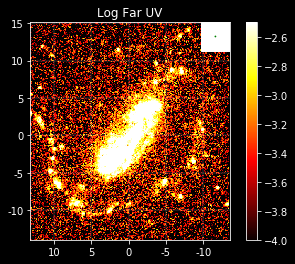

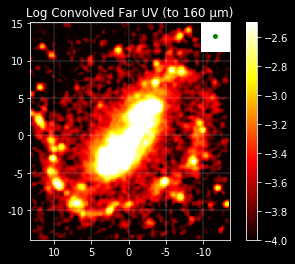

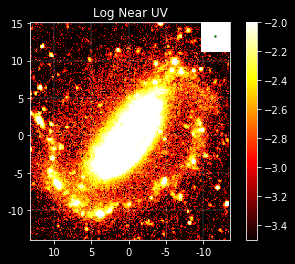

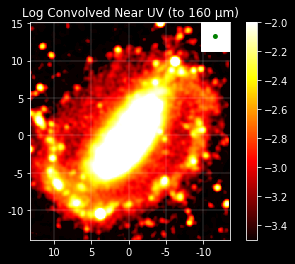

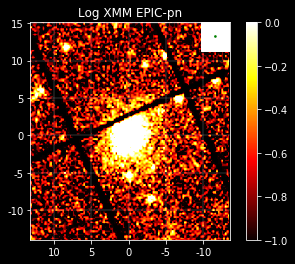

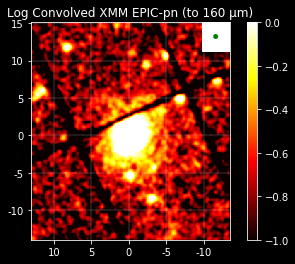

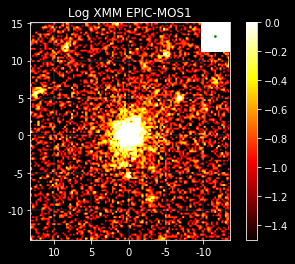

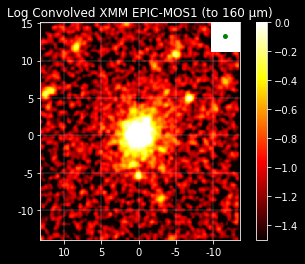

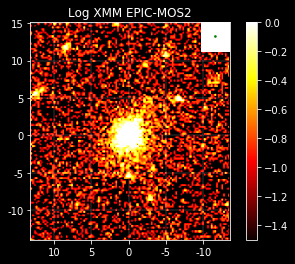

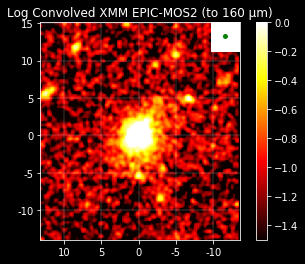

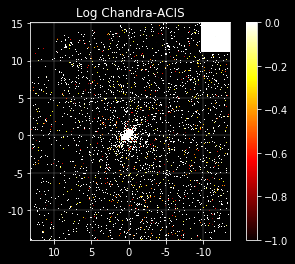

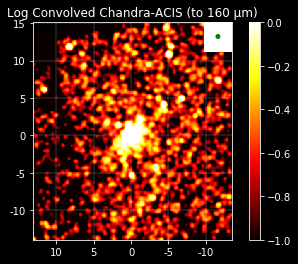

In [25]:
file1=2
file2=9
zoom=2.5

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']
elif file1==8 or file1==9:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = 1.5

data_1,data_fuv = resizing(file1,file2,zoom)
convolved_fuv = convolution(data_fuv,9,4)
convolved_fuv_500 = convolution(data_fuv,9,8)

yy,xx=data_fuv.shape
#a,b = hdu_1.shape
#x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#xlocs = np.arange(-150,153,30)+x0
#y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
#ylocs = np.arange(-150,153,30)+y0
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

xlocs = xlocs-x0+int(xx/2)
ylocs = ylocs-y0+int(yy/2)

plt.figure()
plt.imshow(np.log10(data_fuv),cmap='hot',vmin=-4,vmax=-2.5)
plt.colorbar()
plt.title('Log Far UV')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_fuv.shape[0])
plt.xlim(0,data_fuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_fuv/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_fuv.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_fuv),cmap='hot',vmin=-4,vmax=-2.5)
plt.colorbar()
plt.title('Log Convolved Far UV (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_fuv.shape[0])
plt.xlim(0,data_fuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cfuv.png',dpi=200)

#plt.figure()
#plt.imshow(np.log10(convolved_fuv_500),cmap='hot',vmin=-3,vmax=-2)
#plt.colorbar()
#plt.title('Log Convolved Far UV (to 500 µm)')
#plt.xticks(xlocs,np.flip(x))
#plt.yticks(ylocs,y)
#plt.ylim(0,data_fuv.shape[0])
#plt.xlim(0,data_fuv.shape[1])
#plt.grid(lw=0.2)
#plt.savefig('NGC1808_cfuv500.png',dpi=200)

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']
elif file1==8 or file1==9:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = 1.5

file2 = 10
data_1,data_nuv = resizing(file1,file2,zoom)
convolved_nuv = convolution(data_nuv,10,4)
convolved_nuv_500 = convolution(data_nuv,10,8)

plt.figure()
plt.imshow(np.log10(data_nuv),cmap='hot',vmin=-3.5,vmax=-2)
plt.colorbar()
plt.title('Log Near UV')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_nuv/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_nuv.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_nuv),cmap='hot',vmin=-3.5,vmax=-2)
plt.colorbar()
plt.title('Log Convolved Near UV (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cnuv.png',dpi=200)

#plt.figure()
#plt.imshow(np.log10(convolved_nuv_500),cmap='hot',vmin=-2.7,vmax=-1.2)
#plt.colorbar()
#plt.title('Log Convolved Near UV (to 500 µm)')
#plt.xticks(xlocs,np.flip(x))
#plt.yticks(ylocs,y)
#plt.ylim(0,data_nuv.shape[0])
#plt.xlim(0,data_nuv.shape[1])
#plt.grid(lw=0.2)
#plt.savefig('NGC1808_cnuv500.png',dpi=200)

sky_1 = sky[file1]
file_1 = file[file1]
if file1==0 or file1==1:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = hdu_1.header['PXSCAL2']
elif file1==2 or file1==3 or file1==4 or file1==5 or file1==6 or file1==7:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[1]
    hdr = fits.open(get_pkg_data_filename(file_1))[0].header
    scale = hdr['PIXSIZE']
elif file1==8 or file1==9:
    hdu_1 = fits.open(get_pkg_data_filename(file_1))[0]
    scale = 1.5

file2 = 11
data_1,data_xmm_pn = resizing(file1,file2,zoom)
convolved_xmm_pn = convolution(data_xmm_pn,11,4)
#convolved_xmm_500 = convolution(data_xmm_pn,11,8)

file2 = 12
data_1,data_xmm_mos1 = resizing(file1,file2,zoom)
convolved_xmm_mos1 = convolution(data_xmm_mos1,12,4)

file2 = 13
data_1,data_xmm_mos2 = resizing(file1,file2,zoom)
convolved_xmm_mos2 = convolution(data_xmm_mos2,13,4)

plt.figure()
plt.imshow(np.log10(data_xmm_pn),cmap='hot',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log XMM EPIC-pn')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm_pn/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_pn.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_xmm_pn),cmap='hot',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log Convolved XMM EPIC-pn (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cxmm_pn.png',dpi=200)

plt.figure()
plt.imshow(np.log10(data_xmm_mos1),cmap='hot',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM EPIC-MOS1')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm_pn/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_mos1.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_xmm_mos1),cmap='hot',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved XMM EPIC-MOS1 (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cxmm_mos1.png',dpi=200)

plt.figure()
plt.imshow(np.log10(data_xmm_mos2),cmap='hot',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM EPIC-MOS2')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm_pn/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_mos2.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_xmm_mos2),cmap='hot',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved XMM EPIC-MOS2 (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cxmm_mos2.png',dpi=200)

file2 = 14
data_1,data_chandra = resizing(file1,file2,zoom)
convolved_chandra = convolution(data_chandra,14,4)
#convolved_xmm_500 = convolution(data_xmm,14,8)

plt.figure()
plt.imshow(np.log10(data_chandra),cmap='hot',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log Chandra-ACIS')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_chandra/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_chandra_acis.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_chandra),cmap='hot',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log Convolved Chandra-ACIS (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cchandra_acis.png',dpi=200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log10


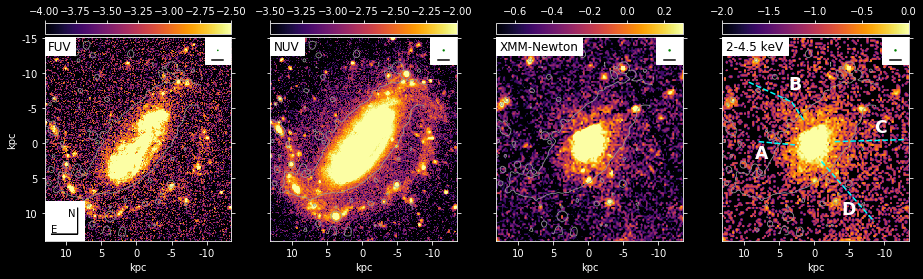

In [28]:
plt.style.use('dark_background')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(16,4))

img1 = ax1.imshow(np.log10(data_fuv),cmap='inferno',vmin=-4,vmax=-2.5)
plots(img1,ax1)
ax1.set_ylabel('kpc')
ax1.set_xlabel('kpc')
ax1.tick_params(right=True)
ax1.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_fuv/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax1.add_patch(bkg)
ax1.add_patch(beam)
ax1.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),46,27,color='white')
ax1.add_patch(box)
ax1.text(5,yy-20,'FUV',size='large',color='black')
bkg2 = Rectangle((0,0),60,60,color='white')
ax1.add_patch(bkg2)
ax1.arrow(50,10,-40,0,width=.01,color='black')
ax1.text(10,13,'E',size='medium',color='black')
ax1.arrow(50,10,0,40,width=.01,color='black')
ax1.text(35,38,'N',size='medium',color='black')

img2 = ax2.imshow(np.log10(data_nuv),cmap='inferno',vmin=-3.5,vmax=-2)
plots(img2,ax2)
ax2.set_xlabel('kpc')
ax2.tick_params(right=True,labelleft=False)
ax2.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_nuv/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax2.add_patch(bkg)
ax2.add_patch(beam)
ax2.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),50,27,color='white')
ax2.add_patch(box)
ax2.text(5,yy-20,'NUV',size='large',color='black')

img3 = ax3.imshow(np.log10(data_xmm_pn+data_xmm_mos1+data_xmm_mos2),cmap='inferno',vmin=-0.7,vmax=0.3)
plots(img3,ax3)
ax3.set_xlabel('kpc')
ax3.tick_params(right=True,labelleft=False)
ax3.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_xmm_pn/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax3.add_patch(bkg)
ax3.add_patch(beam)
ax3.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),130,27,color='white')
ax3.add_patch(box)
ax3.text(5,yy-20,'XMM-Newton',size='large',color='black')

arr,data_1 = resizing(2,16,2.5)
arr,data_2 = resizing(2,21,2.5)
arr,data_3 = resizing(2,26,2.5)
data = data_1+data_2+data_3

convolved_2_4pt5kev = convolution(data,15,4)

#img4 = ax4.imshow(np.log10(data_chandra),cmap='inferno',vmin=-1,vmax=0)
img4 = ax4.imshow(np.log10(data),cmap='inferno',vmin=-2,vmax=0)
plots(img4,ax4)
ax4.set_xlabel('kpc')
ax4.tick_params(right=True,labelleft=False)
ax4.contour(X,Y,convolved_4pt5,levels=[0.075],colors='0.6',linewidths=0.8,zorder=1)
beam = Circle((xx-20,yy-20),fwhm_xmm_mos1/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
ax4.add_patch(bkg)
ax4.add_patch(beam)
ax4.plot([xx-20-8.5,xx-20+8.5],[yy-35,yy-35],'k-')
box = Rectangle((0,yy-27),88+12,27,color='white')
ax4.add_patch(box)
draw_lines(ax4)
label_lines(ax4)
#ax4.text(5,yy-20,'Chandra',size='large',color='black')
ax4.text(5,yy-20,'2-4.5 keV',size='large',color='black')

fig.subplots_adjust(wspace=0.05, hspace=0) #(wspace=-0.15, hspace=0)
plt.savefig('ancillaryfluxmaps.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [201]:
file[26]

'pn_2.fits'

In [ ]:
plt.imshow(np.log10(data_chandra),cmap='hot',vmin=-1,vmax=0)
plt.colorbar()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


"print('Number of Unmasked Pixels in Disk: %d' % np.sum(mask4pt5*mask70*mask160)) #number of unmasked pixels\nprint('Sum of Pixels in Disk (70 µm): %f' % np.sum(convolved_70*mask4pt5*mask70*mask160)) #number of unmasked pixels\nprint('Sum of Pixels in Disk (100 µm): %f' % np.sum(ngc1808_100*mask4pt5*mask70*mask160)) #number of unmasked pixels\nprint('Sum of Pixels in Disk (160 µm): %f' % np.sum(ngc1808_160*mask4pt5*mask70*mask160)) #number of unmasked pixels\nprint('Sum of Pixels in Disk (250 µm): %f' % np.sum(ngc1808_250*mask4pt5*mask70*mask160)) #number of unmasked pixels\nprint('Sum of Pixels in Disk (350 µm): %f' % np.sum(ngc1808_350*mask4pt5*mask70*mask160)) #number of unmasked pixels\nprint('Sum of Pixels in Disk (500 µm): %f' % np.sum(ngc1808_500*mask4pt5*mask70*mask160)) #number of unmasked pixels\n#print('Sum of Pixels in Disk (FUV): %f' % np.sum(data_fuv*mask4pt5*mask70*mask160)) #number of unmasked pixels\n#print('Sum of Pixels in Disk (NUV): %f' % np.sum(data_nuv*mask4pt5*m

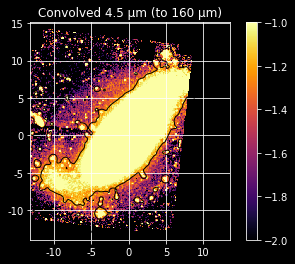

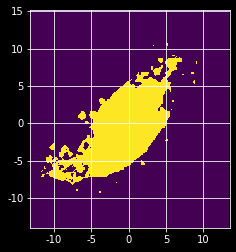

In [29]:
mask4pt5 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask4pt5.shape[0]):
    for j in range(mask4pt5.shape[1]):
        if 0.075<convolved_4pt5[i,j]:
            mask4pt5[i,j]=1
            
mask70 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask70.shape[0]):
    for j in range(mask70.shape[1]):
        if convolved_70[i,j]>0:
            mask70[i,j]=1
            
mask160 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask160.shape[0]):
    for j in range(mask160.shape[1]):
        if ngc1808_160[i,j]>0:
            mask160[i,j]=1

yi,xi = np.where(mask4pt5==1)
for i in range(yi.size):
    yj = yi[i]
    xj = xi[i]
    s = (xj - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (yj - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
    if abs(s)>60 or yj<50:
        mask4pt5[yj,xj]=0
            
plt.figure()
plt.imshow(np.log10(ngc1808_4pt5),cmap='inferno',vmin=-2,vmax=-1)
plt.colorbar()
plt.title('Convolved 4.5 µm (to 160 µm)')
plt.xticks(xlocs,x)
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid()
m,n = convolved_4pt5.shape
X,Y = np.meshgrid(np.linspace(0,n-1,n),np.linspace(0,m-1,m))
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)

plt.figure()
a = mask4pt5*mask70*mask160
plt.imshow(mask4pt5*mask70*mask160)
plt.xticks(xlocs,x)
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid()

'''print('Number of Unmasked Pixels in Disk: %d' % np.sum(mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (70 µm): %f' % np.sum(convolved_70*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (100 µm): %f' % np.sum(ngc1808_100*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (160 µm): %f' % np.sum(ngc1808_160*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (250 µm): %f' % np.sum(ngc1808_250*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (350 µm): %f' % np.sum(ngc1808_350*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (500 µm): %f' % np.sum(ngc1808_500*mask4pt5*mask70*mask160)) #number of unmasked pixels
#print('Sum of Pixels in Disk (FUV): %f' % np.sum(data_fuv*mask4pt5*mask70*mask160)) #number of unmasked pixels
#print('Sum of Pixels in Disk (NUV): %f' % np.sum(data_nuv*mask4pt5*mask70*mask160)) #number of unmasked pixels'''

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log10


(0, 308)

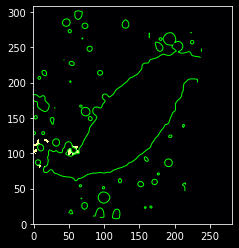

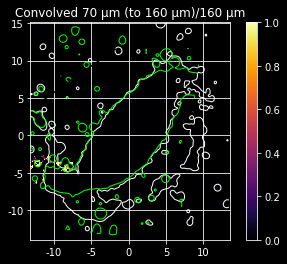

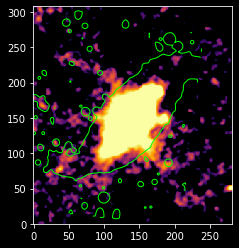

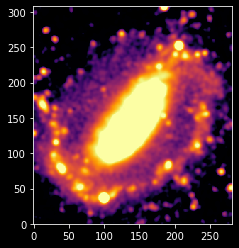

In [49]:
mask4pt5 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask4pt5.shape[0]):
    for j in range(mask4pt5.shape[1]):
        if a[i,j]!=1:
            mask4pt5[i,j]=1
            
mask70 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask70.shape[0]):
    for j in range(mask70.shape[1]):
        if convolved_70[i,j]>0:
            mask70[i,j]=1
            
mask160 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask160.shape[0]):
    for j in range(mask160.shape[1]):
        if ngc1808_160[i,j]>0:
            mask160[i,j]=1
            
maskUV = np.ones((convolved_4pt5.shape),dtype=int)
for i in range(mask160.shape[0]):
    for j in range(mask160.shape[1]):
        #if convolved_nuv[i,j]>10**-2.96 and i - 1.2*(j-230)<150 or (i-40)<(j-140)*(140-40)/(260-140) or j>220:
        if (convolved_nuv[i,j]>10**-2.96 and j<50) or (120<i<175 and j<20):# or (i-195+10)>(j-50+50)*(235+35-195+10)/(120-50+50):
            maskUV[i,j]=0

yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
yi,xi = np.where(mask4pt5==1)
for i in range(yi.size):
    yj = yi[i]
    xj = xi[i]
    t = (xj - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (yj - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
    s = (xj - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (yj - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
    #if (s<0 and yj>80) or t<-165 or yj>165 or t>-80: #t>50,-80
    if s>0 or s<-180 or t<-175 or (yj-100)>(100-125)/(100-0)*(xj-100) or t>75 or (s<0 and yj<80): #t<-30 #t<-200
        mask4pt5[yj,xj]=0

plt.figure()
bd = mask4pt5*mask70*mask160+bcUV#*maskUV#
plt.imshow(mask4pt5*mask70*mask160*maskUV,cmap='inferno')
plt.contour(X,Y,convolved_4pt5,levels=[0.075],colors='lime',linewidths=1,zorder=2)
plt.ylim(0,convolved_4pt5.shape[0])

plt.figure()
plt.imshow((10**np.log10(convolved_70)/10**np.log10(ngc1808_160)*mask4pt5*mask70*mask160),cmap='inferno',vmin=0,vmax=1)
plt.colorbar()
plt.title('Convolved 70 µm (to 160 µm)/160 µm')
plt.xticks(xlocs,x)
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid()
#plt.contour(X,Y,convolved_4pt5,levels=[0.05],colors='black',linewidths=1)
plt.contour(X,Y,convolved_nuv,levels=[10**-2.75],colors='white',linewidths=1,zorder=2)
plt.contour(X,Y,convolved_4pt5,levels=[0.075],colors='lime',linewidths=1,zorder=2)
plt.plot([50-50,120],[195-10,235+35],'k-')
#plt.plot([],[],'k')
#plt.savefig('maskdisk70.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_70),cmap='inferno',vmin=-4,vmax=-3)
plt.contour(X,Y,convolved_4pt5,levels=[0.075],colors='lime',linewidths=1,zorder=2)
plt.ylim(0,convolved_4pt5.shape[0])

plt.figure()
plt.imshow(np.log10(convolved_nuv),cmap='inferno',vmin=-3.5,vmax=-2)
plt.ylim(0,convolved_4pt5.shape[0])

(0, 308)

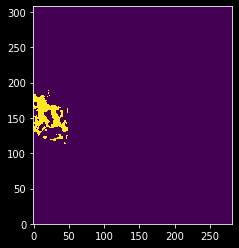

In [46]:
bcUV = mask4pt5*mask70*mask160*(np.ones((bc.shape))-maskUV) #do after setting bc region
bcUV[190:,:]=0
plt.imshow(bcUV)
plt.ylim(0,bcUV.shape[0])

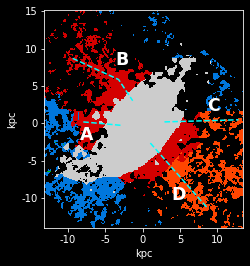

In [52]:
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))

plt.figure()
plt.imshow(2*a+0.5*bb+1.85*bc+0.5*bd+0.5*cb+1.85*cci+1.65*(cc-cci)+0.5*cd,cmap='nipy_spectral',vmax=2)
#plt.colorbar()
plt.ylabel('kpc')
plt.xlabel('kpc')
#plt.contour(X,Y,bci,levels=[1],colors='white',linestyle='--')
#plt.contour(X,Y,bc,levels=[1],colors='white',linestyle='-',linewidths=0.65)
#plt.contour(X,Y,cci,levels=[1],colors='white',linestyle='-',linewidths=0.8)
#plt.contour(X,Y,cc,levels=[1],colors='white',linestyle='-',linewidths=0.4)
#plt.colorbar()
plt.xticks(xlocs,x)
plt.yticks(ylocs,y)
plt.ylim(0,a.shape[0])
plt.xlim(0,a.shape[1]-0.5)

#plt.text(xc,yc,'a',color='1',fontsize='x-large')
#plt.text(xc,yc+100,'bb',color='1',fontsize='x-large')
#plt.text(xc-60,yc+70,'bc',color='1',fontsize='x-large')
#plt.text(xc-115,yc,'bd',color='1',fontsize='x-large')
#plt.text(xc-80,yc-110,'cb',color='1',fontsize='x-large')
#plt.text(xc+25+50,yc-75-25,'cc',color='1',fontsize='x-large')
#plt.text(xc+95,yc+20,'cd',color='1',fontsize='x-large')
plt.plot([150,200+30],[120,50-21],'cyan',ls='--')
plt.plot([170,275],[150,153],'cyan',ls='--')
plt.plot([55,110],[150,145],'cyan',ls='--')
plt.plot([40,105,125],[240,210,180],'cyan',ls='--')

plt.text(180,40,'D',size='xx-large',fontweight='bold')
plt.text(230,165,'C',size='xx-large',fontweight='bold')
plt.text(50,125,'A',size='xx-large',fontweight='bold')
plt.text(100,230,'B',size='xx-large',fontweight='bold')

plt.savefig('subregionmask_alt.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [53]:
regions = np.ndarray((7+2,convolved_70.shape[0],convolved_70.shape[1]))
regions[0,:,:]=a
regions[1,:,:]=bb
regions[2,:,:]=bc
regions[3,:,:]=bd
regions[4,:,:]=cb
regions[5,:,:]=cc
regions[6,:,:]=cd
regions[7,:,:]=cci

bands = np.ndarray((6,convolved_70.shape[0],convolved_70.shape[1]))
bands[0,:,:]=ngc1808_70
bands[1,:,:]=ngc1808_100
bands[2,:,:]=ngc1808_160
bands[3,:,:]=ngc1808_250
bands[4,:,:]=ngc1808_350
bands[5,:,:]=ngc1808_500

In [54]:
integrated_fluxes = {'70 µm': [np.sum(ngc1808_70*a)/2,np.sum(ngc1808_70*bb)/2,np.sum(ngc1808_70*bc)/2,np.sum(ngc1808_70*bd)/2,np.sum(ngc1808_70*cb)/2,np.sum(ngc1808_70*cc)/2,np.sum(ngc1808_70*cd)/2,np.sum(ngc1808_70*cci)/2,141.9/2,121.4/2,8.2/2],
                    '100 µm': [np.sum(ngc1808_100*a),np.sum(ngc1808_100*bb),np.sum(ngc1808_100*bc),np.sum(ngc1808_100*bd),np.sum(ngc1808_100*cb),np.sum(ngc1808_100*cc),np.sum(ngc1808_100*cd),np.sum(ngc1808_100*cci),232.9,202.8,15.4],
                    '160 µm': [np.sum(ngc1808_160*a),np.sum(ngc1808_160*bb),np.sum(ngc1808_160*bc),np.sum(ngc1808_160*bd),np.sum(ngc1808_160*cb),np.sum(ngc1808_160*cc),np.sum(ngc1808_160*cd),np.sum(ngc1808_160*cci),247.0,211.9,11.7],
                    '250 µm': [np.sum(ngc1808_250*a),np.sum(ngc1808_250*bb),np.sum(ngc1808_250*bc),np.sum(ngc1808_250*bd),np.sum(ngc1808_250*cb),np.sum(ngc1808_250*cc),np.sum(ngc1808_250*cd),np.sum(ngc1808_250*cci),111.4,98.3,5.8],
                    '350 µm': [np.sum(ngc1808_350*a),np.sum(ngc1808_350*bb),np.sum(ngc1808_350*bc),np.sum(ngc1808_350*bd),np.sum(ngc1808_350*cb),np.sum(ngc1808_350*cc),np.sum(ngc1808_350*cd),np.sum(ngc1808_350*cci),50.0,43.9,2.2],
                    '500 µm': [np.sum(ngc1808_500*a),np.sum(ngc1808_500*bb),np.sum(ngc1808_500*bc),np.sum(ngc1808_500*bd),np.sum(ngc1808_500*cb),np.sum(ngc1808_500*cc),np.sum(ngc1808_500*cd),np.sum(ngc1808_500*cci),19.9,17.7,0.8]}
integrated_fluxes = pd.DataFrame(integrated_fluxes,index=['Stellar Bar','bb','Northern Cone','bd','cb','Southern Cone Max.','cd','Southern Cone Min.','ngc4631','ngc4631_disk','ngc4631_bubble']).transpose()
#integrated_fluxes = integrated_fluxes.drop('100 µm')
integrated_fluxes

Stellar Bar        bb  Northern Cone        bd        cb  \
70 µm     66.946230  0.032010       0.569734  0.168565  0.306228   
100 µm   168.941562 -0.023865       0.764740  0.409259  0.817148   
160 µm   140.288180  0.058820       1.904222  0.717100  0.905896   
250 µm    71.577257  0.031753       0.857689  0.389417  0.406838   
350 µm    27.479315  0.023588       0.482337  0.212236  0.205612   
500 µm     9.291769  0.009920       0.209321  0.075227  0.104164   

        Southern Cone Max.        cd  Southern Cone Min.  ngc4631  \
70 µm             0.929578  0.053732            0.409438    70.95   
100 µm            1.999012 -0.029892            0.946020   232.90   
160 µm            2.562047  0.089486            1.302768   247.00   
250 µm            1.458409  0.082945            0.828563   111.40   
350 µm            0.871605  0.053148            0.456337    50.00   
500 µm            0.388392  0.018189            0.204222    19.90   

        ngc4631_disk  ngc4631_bubble  
70 µm           60.7             4.1  
100 µm         202.8            15.4  
160 µm         211.9            11.7  
250 µm          98.3             5.8  
350 µm          43.9             2.2  
500 µm          17.7             0.8

In [55]:
#error on mean brightness in each pixel
n = np.array([np.sum(a),np.sum(bb),np.sum(bc),np.sum(bd),np.sum(cb),np.sum(cc),np.sum(cd),np.sum(cci)])
mean_err = np.zeros((6,10+1),dtype=float)
for i in range(6):
    for j in range(7+1):
        mean_err[i,j] = np.std((regions[j]*bands[i])[(regions[j]*bands[i])!=0])/n[j]
mean_err[:,7+2:10+2] = 0

        
sigma_ν = np.array([0.00057,0.00040,0.00022,0.00522,0.00123,0.00031])
sky_err = np.zeros((6,10+1),dtype=float)
for i in range(6):
    sky_err[i,:7+1] = sigma_ν[i]
sky_err[:,7+1:10+1] = 0

calibration_err = np.zeros((6,10+1),dtype=float)
for i in range(6):
    for j in range(7+1):
        calibration_err[i,j] = np.sum(regions[j]*bands[i])/5#10
calibration_err[:,7+1] = integrated_fluxes['ngc4631']/10
calibration_err[:,8+1] = integrated_fluxes['ngc4631_disk']/10
calibration_err[:,9+1] = integrated_fluxes['ngc4631_bubble']/10
         
calibration_err[0,:7+1] = calibration_err[0,:7+1]*2.5#5
calibration_err[0,7+1:] = calibration_err[0,7+1:]*10
calibration_err[1:,1:7+1] = calibration_err[1:,1:7+1]*2#*2.5
#calibration_err[1,4:7+1] = calibration_err[1,4:7+1]*1.25#*2
calibration_err[1,1:4] = calibration_err[1,1:4]*1.25#*2
#calibration_err[1,8] = calibration_err[1,8]*2
total_error = np.sqrt(mean_err**2+sky_err**2+calibration_err**2)
#total_error[1,:] = total_error[1,:]*2
E_µi = pd.DataFrame(total_error,index=['70 µm','100 µm','160 µm','250 µm','350 µm','500 µm'],columns=['Stellar Bar','bb','Northern Cone','bd','cb','Southern Cone Max.','cd','Southern Cone Min.','ngc4631','ngc4631_disk','ngc4631_bubble'])
#E_µi = E_µi.drop('100 µm')
E_µi

Stellar Bar        bb  Northern Cone        bd        cb  \
70 µm     66.946230  0.032015       0.569734  0.168566  0.306229   
100 µm    33.788312  0.011939       0.382370  0.204630  0.326859   
160 µm    28.057636  0.023529       0.761689  0.286840  0.362359   
250 µm    14.315452  0.013732       0.343115  0.155854  0.162819   
350 µm     5.495863  0.009515       0.192939  0.084903  0.082254   
500 µm     1.858354  0.003980       0.083729  0.030092  0.041667   

        Southern Cone Max.        cd  Southern Cone Min.  ngc4631  \
70 µm             0.929578  0.053735            0.409439    70.95   
100 µm            0.799605  0.011964            0.378408    23.29   
160 µm            1.024819  0.035795            0.521107    24.70   
250 µm            0.583387  0.033586            0.331466    11.14   
350 µm            0.348644  0.021295            0.182539     5.00   
500 µm            0.155357  0.007282            0.081689     1.99   

        ngc4631_disk  ngc4631_bubble  
70 µm          60.70            4.10  
100 µm         20.28            1.54  
160 µm         21.19            1.17  
250 µm          9.83            0.58  
350 µm          4.39            0.22  
500 µm          1.77            0.08

In [56]:
E_µi/integrated_fluxes

Stellar Bar        bb  Northern Cone        bd        cb  \
70 µm           1.0  1.000159       1.000001  1.000006  1.000002   
100 µm          0.2 -0.500281       0.500000  0.500001  0.400000   
160 µm          0.2  0.400017       0.400000  0.400000  0.400000   
250 µm          0.2  0.432464       0.400046  0.400225  0.400206   
350 µm          0.2  0.403384       0.400008  0.400042  0.400045   
500 µm          0.2  0.401219       0.400003  0.400021  0.400011   

        Southern Cone Max.        cd  Southern Cone Min.  ngc4631  \
70 µm             1.000000  1.000056            1.000001      1.0   
100 µm            0.400000 -0.400224            0.400000      0.1   
160 µm            0.400000  0.400008            0.400000      0.1   
250 µm            0.400016  0.404920            0.400050      0.1   
350 µm            0.400002  0.400669            0.400009      0.1   
500 µm            0.400001  0.400363            0.400003      0.1   

        ngc4631_disk  ngc4631_bubble  
70 µm            1.0             1.0  
100 µm           0.1             0.1  
160 µm           0.1             0.1  
250 µm           0.1             0.1  
350 µm           0.1             0.1  
500 µm           0.1             0.1

In [79]:
λ = np.array([70,100,160,250,350,500])*10**-6
λλ = np.array([70,100,160,250,350,500])
def Marcio_fit(string_ornothing,ax):
    def func(v, a,T):
        return 1e19*a*(v)**3*(v/v0)**2.0/(np.exp(h*v/(k*T))-1)

    # Flux = k0*2*h*M/c^2/D^2*(nu/v0)**beta*(nu)**3/(exp(h*nu/(kb*T))-1)

    k0= 0.192 #units m^2 kg^-1
    k = 1.380648e-16 #units erg k^-1
    h = 6.626e-27  #units erg s
    c = 2.99792458e8 # units m s^-1
    D = 12.3*1e6*3.0856776e16 #units m
    v0 = c/350e-6 # units frecuency (350um ==> Hz)
    
    v = c/λ # Units Hz

    #Initial conditions
    p0 = [1e-55,21]#[1e-60,25]
    # curve fitting
    popt, pcov = curve_fit(func, v, integrated_fluxes[string_ornothing],p0,E_µi[string_ornothing], maxfev = 20000)

    # Chi^2
    if E_µi[string_ornothing] is None:
         chi2 = sum(((func(v,*popt)-integrated_fluxes[string_ornothing]))**2)
    else:
         chi2 = sum(((func(v,*popt)-integrated_fluxes[string_ornothing])/E_µi[string_ornothing])**2)
    dof = len(integrated_fluxes[string_ornothing]) - len(popt)
    rchi2 = chi2/dof
    #print i,j,chi2
    #Mass Solar Units
    mass  = np.log10(popt[0]*D**2*c**2/(k0*2*h)/1.9891e30)
    
    #print('\nMass: ',mass,'\nTemp: ',popt[1],'\nChi2: ',chi2,'\nReduced Chi2: ',rchi2)
    
    #MTX[string_ornothing]['Mass'] = mass
    #MTX[string_ornothing]['Temp'] = popt[1]
    #MTX[string_ornothing]['rchi2'] = rchi2
    
    dMh,dMl,dT = Marcio_sig(integrated_fluxes[string_ornothing],E_µi[string_ornothing])#MonteCarlo_error(mass,string_ornothing)
    
    #MTX[string_ornothing]['σ_m+'] = dMh
    #MTX[string_ornothing]['σ_m-'] = dMl
    #MTX[string_ornothing]['σ_T'] = dT
    
    print('Region: %s' % string_ornothing)
    print('Mass: %2.3f +%2.3f %2.3f' % (mass,dMh,dMl))
    print('Temp: %2.3f ± %2.3f' % (popt[1],dT))
    print('Reduced Chi2: %2.3f\n' % rchi2)
    
    #plt.figure(facecolor='white')
    x = np.arange(0,600,10)*1e-6
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(x,func(c/x,popt[0],popt[1]),label='F(λ,%2.2f,%2.2f), $χ^2_r$ = %2.1f' % (mass,popt[1],rchi2))
    ax.plot(x,func(c/x,(1.9891e30*10**mass+dMh)*(k0*2*h)/(D**2*c**2),popt[1]+dT),'k--',lw=0.75,label='$σ_M+$ = %2.2f, $σ_T$ = %2.2f' % (dMh,dT))
    ax.plot(x,func(c/x,(1.9891e30*10**mass+dMl)*(k0*2*h)/(D**2*c**2),popt[1]-dT),'k--',lw=0.75,label='$σ_M-$ = %2.2f, $σ_T$ = %2.2f' % (dMl,-dT))
    ax.errorbar(λ,integrated_fluxes[string_ornothing],yerr=E_µi[string_ornothing], xerr=None,ecolor = 'r',fmt='ro',capsize=4,label='Observed')
    ax.set_xlabel('λ (µm)',fontsize=12)
    ax.set_ylabel(r'$F_\nu (Jy)$',fontsize=12)
    #plt.title('%s SED' % string_ornothing)
    #ax.set_xticks(λ,λλ)
    ax.set_xticks(λ)
    ax.set_xticklabels(λλ)
    ax.set_xlim(50*1e-6,600*1e-6)
    #plt.ylim(np.amin(integrated_fluxes[string_ornothing])-np.amax(integrated_fluxes[string_ornothing])*0.2,np.amax(integrated_fluxes[string_ornothing])*1.2)
    ax.set_ylim(np.amin(integrated_fluxes[string_ornothing])/1.6,np.amax(integrated_fluxes[string_ornothing])*1.6)
    #plt.legend(loc=0)
    #plt.grid(lw=0.3)
    #plt.savefig('masstemp_%s.png' % string_ornothing,dpi=600,bbox_inches='tight',pad_inches=0)

In [58]:
def Marcio_sig(yn,sigma):
    def func(x, a,c):
        return a*(1/x)**3*(l0/x)**2.0/(np.exp(h*cv/(kb*x*c))-1)

    k0= 0.192 #units m^2 kg^-1
    kb = 1.380648e-16 #units erg k^-1
    h = 6.626e-27  #units erg s
    cv = 3e8 # units m s^-1
    D  = 12.3*1e6*3.0856776e16 #units m
    l0 = 350e-6 # units m (350um)

    suma = 0.0
    size = 0
    sum70 = 0.0
    numpix = 0

    #xn=np.arange(8,1000,1)
    x = np.array([70,100,160,250,350,500])*1e-6

    # In this case I am assuming the 70um as an upper limt. 
    yn = yn*1e-19#np.array([67.7,172.7,140.3,72.1,27.7,9.4])*1e-19
    sigma = sigma*1e-19#np.array([67.7,17.3,14.0,7.2,2.8,0.9])*1e-19
    masstotal = np.array([]) 
    betatotal = np.array([]) 
    temtotal  = np.array([]) 

    plt.figure(1)	
    # Number of random points (SEDs)
    for i in range(100):
    #Initial conditions
        p0 = [1e-18,21]
        error = sigma*np.random.random_sample(6)
    # curve fitting
        popt, pcov = curve_fit(func, x, yn,p0,error, maxfev = 20000)
    # Chi^2
        if sigma is None:
             chi2 = sum(((func(x,*popt)-yn))**2)
        else:
             chi2 = sum(((func(x,*popt)-yn)/sigma)**2)
        dof = len(yn) - len(popt)
        rchi2 = chi2/dof
    #Mass 
        mass  = np.log10(popt[0]*D**2/(k0*2*h*cv)/1.9891e30)
        masstotal = np.append(masstotal,[popt[0]*D**2/(k0*2*h*cv)/1.9891e30])
        temtotal  = np.append(temtotal, [popt[1]])
        
    dMh = np.log10(np.mean(masstotal)+np.std(masstotal)) - np.log10(np.mean(masstotal))
    dMl = np.log10(np.mean(masstotal)-np.std(masstotal)) - np.log10(np.mean(masstotal))
    dT = np.std(temtotal)
    
    return dMh,dMl,dT

Region: Stellar Bar
Mass: 7.716 +0.030 -0.032
Temp: 23.870 ± 0.539
Reduced Chi2: 0.071

Region: Northern Cone
Mass: 6.222 +0.099 -0.128
Temp: 18.374 ± 1.302
Reduced Chi2: 0.261



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


Region: Southern Cone Min.
Mass: 6.141 +0.099 -0.128
Temp: 18.951 ± 1.146
Reduced Chi2: 0.193

Region: Southern Cone Max.
Mass: 6.373 +0.139 -0.205
Temp: 19.481 ± 1.529
Reduced Chi2: 0.255



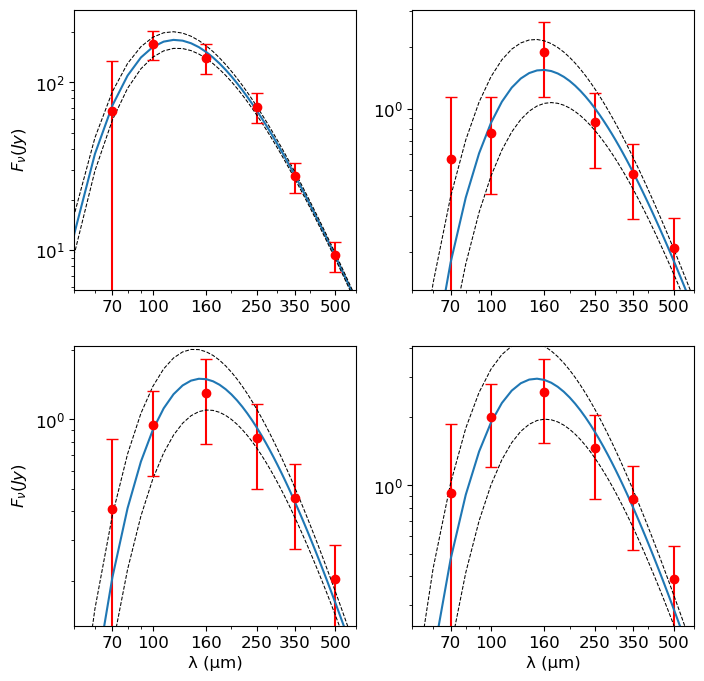

In [80]:
plt.style.use('default')
#fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2,ncols=4,figsize=(16,8))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
#fig.set_facecolor('white')
Marcio_fit('Stellar Bar',ax1)
#ax1.tick_params(bottom=False,labelbottom=False)
ax1.set_xlabel('')
ax1.tick_params(labelsize=12)
Marcio_fit('Northern Cone',ax2)
#ax2.tick_params(bottom=False,labelbottom=False)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.tick_params(labelsize=12)
Marcio_fit('Southern Cone Min.',ax3)
ax3.tick_params(labelsize=12)
Marcio_fit('Southern Cone Max.',ax4)
ax4.set_ylabel('')
ax4.tick_params(labelsize=12)
plt.savefig('SEDs.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [ ]:
def timescales(H,v,SFR,z0,f,GtD,M,xi):
    #H kpc
    #v kms
    
    #Tau_d = (H-z0)/v*1e3*1e6
    
    Omega = 1e52*10**(M-5)*(z0/.7)**2*np.log(np.cosh(H/(2*z0)))*GtD
    '''Omega_0 = 1e52*10**(M-5)*(1.6/.7)*np.log(np.cosh(1/z0))*GtD
    Omega_f = 1e52*10**(M-5)*(1.6/.7)*np.log(np.cosh(H/z0))*GtD
    delta_Omega = -(Omega_f - Omega_0)
    K0 = (GtD*2e33*10**M)*(v*1e5)**2/2
    v_z = np.sqrt(2*(K_0+delta)/(GtD*2e33*10**M))*1e-5
    Tau_d = 2*(H-1)/(v+v_z)*1e3*1e6'''
    
    const=GtD*1e52*10**(M-5)*(z0/.7)**2/(2e33*GtD*10**M) #units are ergs/g = cm^2/s^2
    const=const*(3.156e13/3.086e21)**2 #cm to kpc, s to Myr, const = 0.019 kpc^2/Myr^2
    v = v*(3.156e13/3.086e16) #km/s to kpc/Myr
    vc = v/2
    z = 0
    zc = 0
    Tau_d=2.4
    dt=0.001
    while z <= H:
        Tau_d = Tau_d + dt
        z = z + v*dt
        zc = zc + vc*dt
        z_ddot = -const/z0*np.tanh(z/z0)
        zc_ddot = -const/z0*np.tanh(zc/z0)
        v = v + z_ddot*dt
        vc = vc + zc_ddot*dt
    
    KE = 0.5*(2e33*GtD*10**M)*(vc*3.086e21/3.156e13)**2
    print('<v> (km/s): ',(vc*3.086e16/3.156e13))
    print('<z> (kpc): ',zc)
    mdot = GtD*10**M/Tau_d*1e-6
    eta = mdot/SFR
    Tau_E = (Omega+KE)*1e-51/(f*SFR*xi)*1e-6
    print('Dynamic Time (Myr): ',Tau_d)
    print('Starburst Age (Myr): ',Tau_E)
    print('η: ',eta)

8.99652562188952
-0.008077689043408458
35.54400000000786


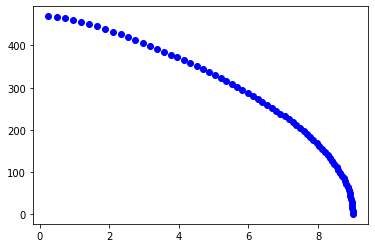

In [112]:
M=6.37#np.log10(10**6.02+10**6.13)
z0 = 1.6*np.sin(57*np.pi/180)
v=470#460/2#315*2
GtD=140
const=GtD*1e52*10**(M-5)*(z0/.7)**2/(2e33*GtD*10**M) #units are ergs/g = cm^2/s^2
const=const*(3.156e13/3.086e21)**2 #cm to kpc, s to Myr, const = 0.019 kpc^2/Myr^2
v = v*(3.156e13/3.086e16) #km/s to kpc/Myr
#vc = 180*(3.156e13/3.086e16)
z = 0
#zc = 0
Tau_d=0#2.14
dt=0.001
plt.figure()
v_arr = np.array([])
z_arr = np.array([])
while v>0:#Tau_d<34.895:
    Tau_d = Tau_d + dt
    z = z + v*dt
    #zc = zc + vc*dt
    z_ddot = -const/z0*np.tanh(z/z0)
    #zc_ddot = -const/z0*np.tanh(zc/z0)
    v = v + z_ddot*dt
    #vc = vc + zc_ddot*dt
    if int(Tau_d*1e3)%5e2==0:
        plt.plot(z,v/(3.156e13/3.086e16),'bo')
        v_arr = np.append(v_arr,v/(3.156e13/3.086e16))
        z_arr = np.append(z_arr,z)
        #plt.plot(Tau_d,zc,'ro')
print(z)
print(v/(3.156e13/3.086e16))
print(Tau_d)

In [150]:
v_arr[64]

42.61744146773206

In [89]:
below_height[6:14]*-3.54

array([4.2952, 4.956 , 5.6168, 6.2776, 6.9384, 7.5992, 8.26  , 8.9208])

In [90]:
below_flux[6:14]

array([3.20148509e-04, 2.82024277e-04, 1.94838813e-04, 4.08856279e-05,
       9.02668325e-05, 1.00059743e-04, 1.98314192e-05, 5.86618890e-05])

In [151]:
np.sum(below_flux[6:14]*np.array([357,330,302,274,239,197,141,43]))/np.sum(below_flux[6:14])

292.7660947138946

In [152]:
140*1e33*10**6.37*(290*1e5)**2

2.760095007157677e+56

In [ ]:
np.sum(below_flux[6:10]*np.array([347,319,291,256]))/np.sum(below_flux[6:10])

In [ ]:
above_height[7:12]*3.54

In [ ]:
np.sum(above_flux[7:12]*np.array([347,319,291,256,220]))/np.sum(above_flux[7:12])

In [ ]:
GtD*1e33*10**6.02*(np.mean(v_arr[14:])*10**5)**2
#GtD*1e33*10**6.02*(450*10**5)**2

In [ ]:
np.mean(v_arr[13:])

In [ ]:
150*1e33*10**6.22*(310*1e5)**2

In [ ]:
M=6.14
z0=1.6*np.sin(57*np.pi/180)
GtD=140
1e52*10**(M-5)*(z0/0.7)**2*np.log(np.cosh(5.5/z0))*GtD

In [ ]:
3.26*1e5

In [ ]:
M=6.31#np.log10(10**6.02+10**6.13)
z0 = 1.6*np.sin(57*np.pi/180)
v=470#460/2#315*2
GtD=150
const=GtD*1e52*10**(M-5)*(z0/.7)**2/(2e33*GtD*10**M) #units are ergs/g = cm^2/s^2
const=const*(3.156e13/3.086e21)**2 #cm to kpc, s to Myr, const = 0.019 kpc^2/Myr^2
v = v*(3.156e13/3.086e16) #km/s to kpc/Myr
vc = v/2
z = 0
zc = 0
Tau_d=0#2.14
dt=0.001
plt.figure()
while v>0:#Tau_d<34.895:
    Tau_d = Tau_d + dt
    z = z + v*dt
    zc = zc + vc*dt
    z_ddot = -const/z0*np.tanh(z/z0)
    zc_ddot = -const/z0*np.tanh(zc/z0)
    v = v + z_ddot*dt
    vc = vc + zc_ddot*dt
    if int(Tau_d*1e3)%5e2==0:
        plt.plot(Tau_d,z,'bo')
        plt.plot(Tau_d,zc,'ro')
print(z, zc)
print(v/(3.156e13/3.086e16))
print(Tau_d)

In [ ]:
(11*1e3)%1e4

In [ ]:
np.log10(10**6.14+10**6.22)

In [ ]:
0.5*2e33*10**6.31*(225*1e5)**2

In [11]:
M=6.14
z0=1.6*np.sin(57*np.pi/180)
GtD=140
1e52*10**(M-5)*(z0/0.7)**2*np.log(np.cosh(4.9/z0))*GtD

2.101454658163126e+56

In [12]:
M=6.22
z0=1.6*np.sin(57*np.pi/180)
GtD=140
1e52*10**(M-5)*(z0/0.7)**2*np.log(np.cosh(5.1/z0))*GtD

2.6536106444259653e+56

In [54]:
M=6.37
z0=1.6*np.sin(57*np.pi/180)
GtD=140
1e52*10**(M-5)*(z0/0.7)**2*np.log(np.cosh(5.7/z0))*GtD

4.287224010001533e+56

In [154]:
140*1e33*10**6.22*(310*1e5)**2+140*1e33*10**6.37*(290*1e5)**2

4.992903232424169e+56

In [ ]:
150*1e33*(10**6.14+10**6.22)*(300*1e5)**2

In [156]:
1e52*10**(6.37-5)*(z0/0.7)**2*np.log(np.cosh(5.7/z0))*GtD+1e52*10**(6.22-5)*(z0/0.7)**2*np.log(np.cosh(5.1/z0))*GtD+GtD*1e33*10**6.22*(310*1e5)**2+GtD*1e33*10**6.37*(290*1e5)**2


1.1933737886851668e+57

In [13]:
140*1e33*10**6.14*(320*1e5)**2+140*1e33*10**6.22*(310*1e5)**2

4.211727107001186e+56

In [157]:
np.log10(10**6.37+10**6.22)

6.602474080687586

In [168]:
10**6.48/(10**7.72+6*10**6.48)

0.04277524362650512

In [23]:
M=6.48
GtD=140
f=0.02
xi=1
SFR=3.5+1.9
Tau_d = 19.636
mdot = GtD*10**M/Tau_d*1e-6
eta = mdot/SFR
Tau_E = (4.8*1e56)*1e-51/(f*SFR*xi)*1e-6
print('Starburst Age: ',Tau_E)
print('eta: ',eta)

Starburst Age:  4.444444444444444
eta:  3.9873214811069104


In [169]:
140*10**6.48/19.6*1e-6

21.571083717157276

In [163]:
(11.9*1e56)*1e-51/(0.01*3.5*1)*1e-6

34.0

In [27]:
(140*10**6.48)/(19.6*1e6)/5.4

3.9946451328069035

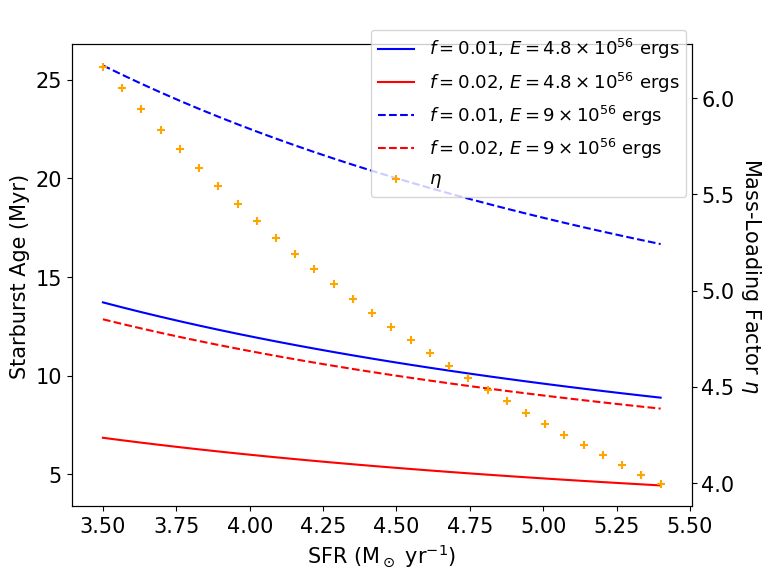

In [92]:
plt.style.use('default')
xi = 1
fig, ax1 = plt.subplots(figsize=(8,6))
SFR = np.linspace(3.5,5.4,30)
E = 4.8*1e56
f = 0.01
Tau_E = E*1e-51/(f*SFR*xi)*1e-6
ax1.plot(SFR,Tau_E,'b',label=r'$\it{f}=0.01$, $E = 4.8 \times 10^{56}$ ergs')

f = 0.02
Tau_E = E*1e-51/(f*SFR*xi)*1e-6
ax1.plot(SFR,Tau_E,'r',label=r'$\it{f}=0.02$, $E = 4.8 \times 10^{56}$ ergs')

E = 9*1e56
f = 0.01
Tau_E = E*1e-51/(f*SFR*xi)*1e-6
ax1.plot(SFR,Tau_E,'b--',label=r'$\it{f}=0.01$, $E = 9 \times 10^{56}$ ergs')

f = 0.02
Tau_E = E*1e-51/(f*SFR*xi)*1e-6
ax1.plot(SFR,Tau_E,'r--',label=r'$\it{f}=0.02$, $E = 9 \times 10^{56}$ ergs')

#ax1.text(3.6,12.7,r'$\it{f}=0.01$, $E = 5.1 \times 10^{56}$ ergs',rotation=-10)
#ax1.text(3.6,6.2,r'$\it{f}=0.02$, $E = 5.1 \times 10^{56}$ ergs',rotation=-5)
#ax1.text(4.5,17,r'$\it{f}=0.01$, $E = 9.6 \times 10^{56}$ ergs',rotation=-10)
#ax1.text(4.5,7.7,r'$\it{f}=0.02$, $E = 9.6 \times 10^{56}$ ergs',rotation=-5)
ax1.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)',fontsize=15)
ax1.set_ylabel('Starburst Age (Myr)',fontsize=15)
ax1.tick_params(labelsize=15)

ax2 = ax1.twinx()
ax2.scatter(SFR,140*10**6.48*1e-6/19.6/SFR,color='orange',marker='+',label='$\eta$')
ax2.set_ylabel(r'Mass-Loading Factor $\eta$',rotation=270,labelpad=20,fontsize=15)
ax2.tick_params(labelsize=15)

fig.legend(loc=(0.48,0.66),fontsize=13)
plt.savefig('timescale_eta.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [246]:
10**6.48/(10**7.72+10**6.48)

0.05441286043387531

In [90]:
def aper_comp(data,data_45,data_8,ned_pa,ap_thick,ap_width,scale,contour_45,vmin,vmax,yc,xc):
    slope = np.tan((ned_pa - 90)*np.pi/180) 
    dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
    dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) 
    ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
    ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)
    
    x0 = int(xx/2)
    y0 = int(yy/2)
    #x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
    #xlocs = np.arange(-150,153,30)+x0
    #y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60*3.54
    #ylocs = np.arange(-150,153,30)+y0
    x = np.arange(-15,16,5)
    y = np.arange(-15,16,5)
    xlocs = 60/(3.54*1.6)*x + xc
    ylocs = 60/(3.54*1.6)*y + yc

    fig = plt.figure(figsize=(8.25,4))

    fig.add_subplot(1,2,1)
    plt.imshow(data,cmap='rainbow',vmin=vmin,vmax=vmax)#,aspect='equal')
    plt.ylabel('kpc')
    plt.xlabel('kpc')
    plt.colorbar()
    #plt.title('Convolved 70 µm/160 µm')#, Slice %s' % title)
    plt.grid(lw=0.2)
    plt.xticks(xlocs,np.flip(x))
    plt.yticks(ylocs,y)
    plt.ylim(0,data.shape[0])
    plt.xlim(0,data.shape[1])
    
    beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green',zorder=2)
    bkg = Rectangle((xx-40,yy-40),40,40,color='white',zorder=2)
    plt.gca().add_patch(bkg)
    plt.gca().add_patch(beam)
    
    m,n = convolved_70.shape
    X,Y = np.meshgrid(np.linspace(0,n-1,n),np.linspace(0,m-1,m))
    plt.contour(X,Y,data_45,levels=np.array([.075]),colors='black',linestyles='-')
    #plt.contour(X,Y,data_8/data_45,levels=contour_ratio,colors='0.35',linewidths=1)

    plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
    i=0
    while i < 20:
        #plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k')
        #plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k')
        i+=1
    plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k') #height confines 
    plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k') #this one is side with arrow
    plt.plot([xc-dx-i*ddx,xc-dx+i*ddx],[yc-dy+i*ddy,yc-dy-i*ddy],'k') #width confines
    plt.plot([xc+dx-i*ddx,xc+dx+i*ddx],[yc+dy+i*ddy,yc+dy-i*ddy],'k')
    plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
    
    data2 = data_8/data_45
    fig.add_subplot(1,2,2)
    plt.imshow(data2,cmap='rainbow',vmin=0,vmax=8)#,aspect='equal')
    plt.ylabel('kpc')
    plt.xlabel('kpc')
    plt.colorbar()
    plt.title('Convolved 8 µm/4.5 µm')#, Slice %s' % title)
    plt.grid(lw=0.2)
    plt.xticks(xlocs,np.flip(x))
    plt.yticks(ylocs,y)
    plt.ylim(0,data.shape[0])
    plt.xlim(0,data.shape[1])
    
    beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green',zorder=2)
    bkg = Rectangle((xx-40,yy-40),40,40,color='white',zorder=2)
    plt.gca().add_patch(bkg)
    plt.gca().add_patch(beam)
    
    m,n = convolved_70.shape
    X,Y = np.meshgrid(np.linspace(0,n-1,n),np.linspace(0,m-1,m))
    plt.contour(X,Y,data_45,levels=np.array([.075]),colors='black',linestyles='-')
    #plt.contour(X,Y,data_8/data_45,levels=contour_ratio,colors='0.35',linewidths=1)

    plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
    i=0
    while i < 20:
        #plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k')
        #plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k')
        i+=1
    plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k') #height confines 
    plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k') #this one is side with arrow
    plt.plot([xc-dx-i*ddx,xc-dx+i*ddx],[yc-dy+i*ddy,yc-dy-i*ddy],'k') #width confines
    plt.plot([xc+dx-i*ddx,xc+dx+i*ddx],[yc+dy+i*ddy,yc+dy-i*ddy],'k')
    plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
    
    plt.subplots_adjust(wspace=0.25)
    #plt.savefig('ngc1808_HratioS_slice%s.png' % title,dpi=600,bbox_inches='tight',pad_inches=0)

    fig,ax1 = plt.subplots()
    #above, side with arrow
    n=0
    above_flux = np.array([data[int(yc),int(xc)]])
    above_flux2 = np.array([data2[int(yc),int(xc)]])
    #above_flux_45 = np.array([data_45[int(yc),int(xc)]])
    #above_flux_8 = np.array([data_8[int(yc),int(xc)]])
    above_height = np.append(0,(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60)
    while n<20:
        aper_n = np.array([])
        aper2_n = np.array([])
        #aper45_n = np.array([])
        #aper8_n = np.array([])
        yfloor = math.floor(yc-abs(dy)+n*abs(ddy))
        yceil = math.ceil(yc+abs(dy)+(n+1)*abs(ddy))
        xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
        xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
        i = yfloor
        while yfloor <= i < yceil:
            j = xfloor
            while xfloor <= j < xceil:
                t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
                s = -(j - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
                if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                    if np.isnan(data[i,j])==False:
                        aper_n = np.append(aper_n,data[i,j])
                        if a[i,j]==0:
                            ax1.plot(s*scale/60*3.54,data[i,j],color='0.6',marker='x',ms=1)
                        elif a[i,j]==1:
                            ax1.plot(s*scale/60*3.54,data[i,j],color='cyan',marker='x',ms=1)
                    else:
                        aper_n = np.append(aper_n,0)
                        if a[i,j]==0:
                            ax1.plot(s*scale/60*3.54,0,color='0.6',marker='x',ms=1)
                        elif a[i,j]==1:
                            ax1.plot(s*scale/60*3.54,0,color='cyan',marker='x',ms=1)
                    if np.isnan(data2[i,j])==False:
                        aper2_n = np.append(aper2_n,data2[i,j])
                    else:
                        aper2_n = np.append(aper2_n,0)
                        #ax2.plot(-s*scale/60,data2[i,j],'yx',ms=1,label='8 µm/4.5 µm  Points')
                    #if np.isnan(data_45[i,j])==False:
                        #aper45_n = np.append(aper45_n,data_45[i,j])
                    #if np.isnan(data_8[i,j])==False:
                        #aper8_n = np.append(aper8_n,data_8[i,j])
                        
                j+=1
            i+=1
        above_flux = np.append(above_flux,np.median(aper_n))
        above_flux2 = np.append(above_flux2,np.median(aper2_n))
        #above_flux_45 = np.append(above_flux_45,np.median(aper45_n))
        #above_flux_8 = np.append(above_flux_8,np.median(aper8_n))
        n+=1

    #below
    n=0
    below_flux = np.array([])
    below_flux2 = np.array([])
    #below_flux_45 = np.array([])
    #below_flux_8 = np.array([])
    below_height = -1*(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60
    while n<20:
        aper_n = np.array([])
        aper2_n = np.array([])
        #aper45_n = np.array([])
        #aper8_n = np.array([])
        yfloor = math.floor(yc-abs(dy)-(n+1)*abs(ddy))
        yceil = math.ceil(yc+abs(dy)-(n)*abs(ddy))
        xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
        xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
        i = yfloor
        while yfloor <= i < yceil:
            j = xfloor
            while xfloor <= j < xceil:
                t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
                s = (j - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
                if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                    if np.isnan(data[i,j])==False:
                        aper_n = np.append(aper_n,data[i,j])
                        if a[i,j]==0:
                            ax1.plot(-s*scale/60*3.54,data[i,j],color='0.6',marker='x',ms=1)
                        elif a[i,j]==1:
                            ax1.plot(-s*scale/60*3.54,data[i,j],color='cyan',marker='x',ms=1)
                    else:
                        aper_n = np.append(aper_n,0)
                        if a[i,j]==0:
                            ax1.plot(-s*scale/60*3.54,0,color='0.6',marker='x',ms=1)
                        elif a[i,j]==1:
                            ax1.plot(-s*scale/60*3.54,0,color='cyan',marker='x',ms=1)
                    if np.isnan(data2[i,j])==False:
                        aper2_n = np.append(aper2_n,data2[i,j])
                    else:
                        aper2_n = np.append(aper2_n,0)
                        #ax2.plot(-s*scale/60,data2[i,j],'yx',ms=1,label='8 µm/4.5 µm  Points')
                    #if np.isnan(data_45[i,j])==False:
                        #aper45_n = np.append(aper45_n,data_45[i,j])
                    #if np.isnan(data_8[i,j])==False:
                        #aper8_n = np.append(aper8_n,data_8[i,j])
                j+=1
            i+=1
        below_flux = np.append(below_flux,np.median(aper_n))
        below_flux2 = np.append(below_flux2,np.median(aper2_n))
        #below_flux_45 = np.append(below_flux_45,np.median(aper45_n))
        #below_flux_8 = np.append(below_flux_8,np.median(aper8_n))
        n+=1

    ax1.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux),above_flux),'ro-',label='70 µm/160 µm')
    ax1.set_ylabel('70 µm/160 µm',fontsize=13)
    ax1.set_xlabel('Height (kpc)',fontsize=13)
    ax1.set_xlim(left=11,right=-11)
    #ax1.set_title('Ratio Profile')
    ax1.set_ylim(bottom=0,top=np.nanmax(np.append(above_flux,below_flux))*1.1)
    ax1.invert_xaxis()
    ax1.tick_params(axis='both', labelsize=13)
    
    ax2 = ax1.twinx()
    #ax1.plot(np.append(np.flip(below_height),above_height),np.append(np.flip(below_flux_8),above_flux_8)/np.append(np.flip(below_flux_45),above_flux_45),'c-',label='8 µm/4.5 µm')
    ax2.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux2),above_flux2),'b-',label='8 µm/4.5 µm')
    ax2.set_ylabel('8 µm/4.5 µm',rotation=270,labelpad=15,fontsize=13)
    #ax2.set_ylim(bottom=np.amin(np.append(np.flip(below_flux_8),above_flux_8)/np.append(np.flip(below_flux_45),above_flux_45))-0.1*abs(np.amax(np.append(np.flip(below_flux_8),above_flux_8)/np.append(np.flip(below_flux_45),above_flux_45))),top=np.amax(np.append(np.flip(below_flux_8),above_flux_8)/np.append(np.flip(below_flux_45),above_flux_45))*1.1)
    #ax2.set_ylim(bottom=np.amin(np.append(np.flip(below_flux2),above_flux2))-0.1*abs(np.amax(np.append(np.flip(below_flux2),above_flux2))),top=np.amax(np.append(np.flip(below_flux2),above_flux2))*1.1)
    ax2.set_ylim(bottom=0,top=8)
    ax2.set_xlim(left=11,right=-11)
    ax2.tick_params(axis='both', labelsize=13)

    #plt.legend(loc=0)
    #ax1.legend(loc=0)
    #ax2.legend(loc=0)
    fig.legend(loc=2,bbox_to_anchor=(.115,.9),fontsize=13)
    plt.text(9.7,4.5,'NE',fontsize='xx-large')
    plt.text(-7.7,4.5,'SW',fontsize='xx-large')
    ax1.grid()
    plt.savefig('ngc1808_ratio_profile.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


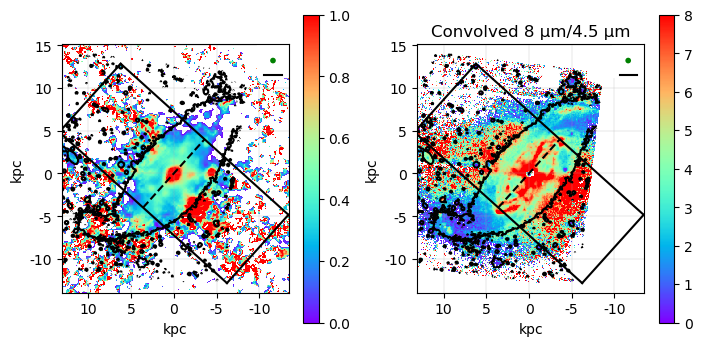

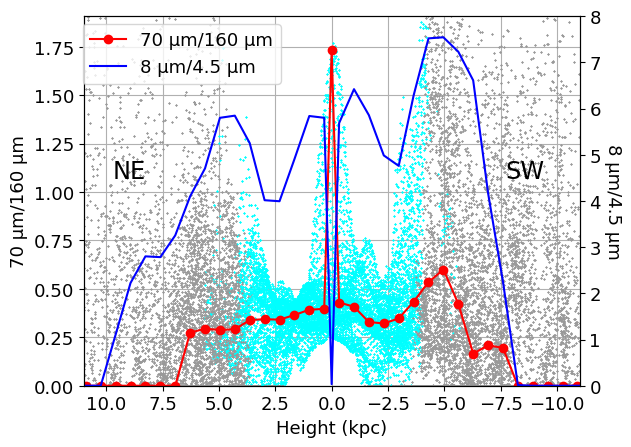

In [91]:
plt.style.use('default')

vmin_ratio=0
vmax_ratio=1
contour_45=0.075
contour_ratio=np.array([2,7])

ap_width=38*3
title='All'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 0
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
aper_comp(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),10**np.log10(ngc1808_4pt5),10**np.log10(ngc1808_8),ned_pa,ap_thick,ap_width,scale,contour_45,vmin_ratio,vmax_ratio,yc,xc)


In [ ]:
ap_width=38*3
title='All'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 0
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
aper_comp(10**np.log10(convolved_70*(ngc1808_70>0.0004))/10**np.log10(ngc1808_160*(ngc1808_160>0.0013)),10**np.log10(convolved_4pt5),10**np.log10(convolved_8),ned_pa,ap_thick,ap_width,scale,contour_45,vmin_ratio,vmax_ratio,yc,xc,x,xxlocs,y,yylocs,title)

In [ ]:
ap_width=38*3
ap_thick=7
dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) 
ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)

fig,ax1 = plt.subplots()
#above, side with arrow
n=0
above_flux = np.array([ngc1808_70[int(yc),int(xc)]])
above_flux2 = np.array([ngc1808_160[int(yc),int(xc)]])
above_ratio = np.array([ngc1808_70[int(yc),int(xc)]/ngc1808_160[int(yc),int(xc)]])
above_height = np.append(0,(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60)
while n<20:
    aper_n = np.array([])
    aper2_n = np.array([])
    aper3_n = np.array([])
    yfloor = math.floor(yc-abs(dy)+n*abs(ddy))
    yceil = math.ceil(yc+abs(dy)+(n+1)*abs(ddy))
    xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
    xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
    i = yfloor
    while yfloor <= i < yceil:
        j = xfloor
        while xfloor <= j < xceil:
            t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
            s = -(j - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
            if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                if np.isnan(ngc1808_70[i,j])==False:
                    aper_n = np.append(aper_n,ngc1808_70[i,j])
                else:
                    aper_n = np.append(aper_n,0)
                if np.isnan(ngc1808_160[i,j])==False:
                    aper2_n = np.append(aper2_n,ngc1808_160[i,j])
                else:
                    aper2_n = np.append(aper2_n,0)
                if np.isnan(ngc1808_70[i,j]/ngc1808_160[i,j])==False:
                    aper3_n = np.append(aper3_n,ngc1808_70[i,j]/ngc1808_160[i,j])
                else:
                    aper3_n = np.append(aper3_n,0)

            j+=1
        i+=1
    above_flux = np.append(above_flux,np.median(aper_n))
    above_flux2 = np.append(above_flux2,np.median(aper2_n))
    above_ratio = np.append(above_ratio,np.median(aper3_n))
    n+=1

#below
n=0
below_flux = np.array([])
below_flux2 = np.array([])
below_ratio = np.array([])
below_height = -1*(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60
while n<20:
    aper_n = np.array([])
    aper2_n = np.array([])
    aper3_n = np.array([])
    yfloor = math.floor(yc-abs(dy)-(n+1)*abs(ddy))
    yceil = math.ceil(yc+abs(dy)-(n)*abs(ddy))
    xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
    xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
    i = yfloor
    while yfloor <= i < yceil:
        j = xfloor
        while xfloor <= j < xceil:
            t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
            s = (j - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
            if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                if np.isnan(ngc1808_70[i,j])==False:
                    aper_n = np.append(aper_n,ngc1808_70[i,j])
                else:
                    aper_n = np.append(aper_n,0)
                if np.isnan(ngc1808_160[i,j])==False:
                    aper2_n = np.append(aper2_n,ngc1808_160[i,j])
                else:
                    aper2_n = np.append(aper2_n,0)
                if np.isnan(ngc1808_70[i,j]/ngc1808_160[i,j])==False:
                    aper3_n = np.append(aper3_n,ngc1808_70[i,j]/ngc1808_160[i,j])
                else:
                    aper3_n = np.append(aper3_n,0)
            j+=1
        i+=1
    below_flux = np.append(below_flux,np.median(aper_n))
    below_flux2 = np.append(below_flux2,np.median(aper2_n))
    below_ratio = np.append(below_ratio,np.median(aper3_n))
    n+=1

ax1.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux),above_flux),'ro-',label='70 µm')
ax1.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux2),above_flux2),'bo-',label='160 µm')
ax1.set_yscale('log')
ax1.set_ylabel('Flux')
ax1.set_xlabel('Height (kpc)')
ax1.set_ylim(bottom=0,top=0.1)
ax1.invert_xaxis()

ax2 = ax1.twinx()
ax2.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_ratio),above_ratio),'g-',label='Ratio')
ax2.set_ylabel('Ratio',labelpad=5.5,rotation=270)
ax2.set_ylim(bottom=-0.1,top=1)

fig.legend(loc=2,bbox_to_anchor=(.1,.9-.03))
plt.text(12,0.5,'NE',fontsize='xx-large')
plt.text(-10.5,0.5,'SW',fontsize='xx-large')
ax1.grid()

In [ ]:
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

#plt.imshow(np.log10(convolved_70),cmap='rainbow_r',vmin=-4.4,vmax=-3)
plt.imshow(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),cmap='inferno',vmin=0,vmax=2)
plt.ylabel('kpc')
plt.xlabel('kpc')
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=np.array([.075]),colors='white')
#plt.title('Convolved 70 µm/160 µm')#, Slice %s' % title)
#plt.grid(lw=0.2)
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
i=0
while i < 20:
    #plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k')
    #plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k')
    i+=1
plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k') #height confines 
plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k') #this one is side with arrow
plt.plot([xc-dx-i*ddx,xc-dx+i*ddx],[yc-dy+i*ddy,yc-dy-i*ddy],'k') #width confines
plt.plot([xc+dx-i*ddx,xc+dx+i*ddx],[yc+dy+i*ddy,yc+dy-i*ddy],'k')
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
pix_per_kpc = (1/1.6)*60/3.54
z=4
plt.plot([xc,xc+z*pix_per_kpc*np.sin((ned_pa - 90)*np.pi/180)],[yc,yc-z*pix_per_kpc*np.cos((ned_pa - 90)*np.pi/180)],'lime') #width confines

In [45]:
below_height[6:13]*-3.54

array([4.2952, 4.956 , 5.6168, 6.2776, 6.9384, 7.5992, 8.26  ])

In [37]:
np.sum(below_flux[7:10])

1.4550594937140424

In [ ]:
above_flux[7:12]

In [ ]:
np.sum(np.ones(4)*below_height[0:4]*(-3.54))/np.sum(np.ones(4))

In [ ]:
(below_height+below_height[0])*-3.54

In [ ]:
below_flux[0:4]*below_height[0:4]*(-3.54)/np.sum(below_flux[0:4])

In [ ]:
np.sum(below_flux[6:10]*below_height[6:10]*(-3.54))/np.sum(below_flux[6:10])

In [52]:
np.sum(below_flux[6:13]*below_height[6:13]*(-3.54))/np.sum(below_flux[6:13])

5.713344066939998

In [ ]:
np.sum(above_flux[7:12]*above_height[7:12]*(3.54))/np.sum(above_flux[7:12])

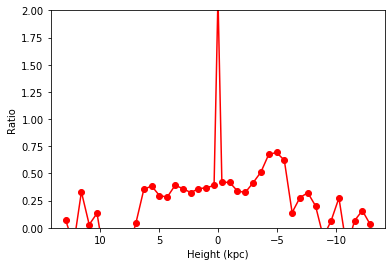

In [36]:
fig,ax1 = plt.subplots()
ap_width=38*3
ap_thick=7
dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) 
ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)
#above, side with arrow
n=0
above_flux = np.array([ngc1808_70[int(yc),int(xc)]])
above_height = np.append(0,(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60)
while n<20:
    aper_n = np.array([])
    yfloor = math.floor(yc-abs(dy)+n*abs(ddy))
    yceil = math.ceil(yc+abs(dy)+(n+1)*abs(ddy))
    xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
    xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
    i = yfloor
    while yfloor <= i < yceil:
        j = xfloor
        while xfloor <= j < xceil:
            t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
            s = -(j - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
            if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                if np.isnan(ngc1808_70[i,j]/ngc1808_160[i,j])==False:
                    aper_n = np.append(aper_n,ngc1808_70[i,j]/ngc1808_160[i,j])
                else:
                    aper_n = np.append(aper_n,0)

            j+=1
        i+=1
    above_flux = np.append(above_flux,np.median(aper_n))
    n+=1

#below
n=0
below_flux = np.array([])
below_height = -1*(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60
while n<20:
    aper_n = np.array([])
    yfloor = math.floor(yc-abs(dy)-(n+1)*abs(ddy))
    yceil = math.ceil(yc+abs(dy)-(n)*abs(ddy))
    xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
    xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
    i = yfloor
    while yfloor <= i < yceil:
        j = xfloor
        while xfloor <= j < xceil:
            t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
            s = (j - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
            if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                if np.isnan(ngc1808_70[i,j]/ngc1808_160[i,j])==False:
                    aper_n = np.append(aper_n,ngc1808_70[i,j]/ngc1808_160[i,j])
                else:
                    aper_n = np.append(aper_n,0)
            j+=1
        i+=1
    below_flux = np.append(below_flux,np.median(aper_n))
    n+=1

ax1.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux),above_flux),'ro-',label='70 µm')
#ax1.set_yscale('log')
ax1.set_ylabel('Ratio')
ax1.set_xlabel('Height (kpc)')
ax1.set_ylim(bottom=0,top=2)
ax1.invert_xaxis()

In [ ]:
cnr = a*(((X-xc)**2+(Y-yc)**2<10**2)==True)
bar_minus_cnr = a - cnr
arr = np.array([])
for i in range(np.where(bar_minus_cnr==1)[0].size):
    arr = np.append(arr,convolved_70[np.where(bar_minus_cnr==True)[0][i],np.where(bar_minus_cnr==True)[1][i]]/ngc1808_160[np.where(bar_minus_cnr==True)[0][i],np.where(bar_minus_cnr==True)[1][i]])
#np.mean((((X-xc)**2+(Y-yc)**2<10**2)==True)*convolved_70/ngc1808_160)
np.mean(arr)
#plt.imshow(cnr)
#plt.colorbar()

In [ ]:
cnr

In [ ]:
(((X-xc)**2+(Y-yc)**2<10**2)==True)*convolved_70/ngc1808_160

In [ ]:
np.mean(convolved_70/ngc1808_160*a)

In [ ]:
plt.figure()
plt.imshow(np.log10(data_xmm_pn+data_xmm_mos1+data_xmm_mos2),cmap='rainbow',vmin=-0.7,vmax=0.3)
plt.colorbar()
plt.title('Log Composite XMM EPIC')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_xmm_pn.shape[0])
plt.xlim(0,data_xmm_pn.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_chandra/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([150,200+30],[120,50-21],'k--')
plt.plot([170,275],[150,153],'k--')
plt.plot([10,55,110],[165,150,145],'k--')
plt.plot([40,105,125],[240,210,180],'k--')

In [ ]:
np.log10(0.15)

In [ ]:
plt.figure()
plt.imshow(10**np.log10(clipped_8)/10**np.log10(convolved_4pt5*mask8),cmap='rainbow',vmin=0,vmax=10)
plt.colorbar()
plt.title('8 µm/Convolved 4.5 µm Ratio')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
plt.grid(lw=0.2)
plt.contour(X,Y,convolved_4pt5,levels=[0.05],colors='black',linewidths=1)
beam = Circle((xx-20,yy-20),fwhm_8/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.plot([xx-20-10.6,xx-20+10.6],[yy-38,yy-38],'k-')
plt.plot([150,200+30],[120,50-21],'k--')
plt.plot([170,275],[150,153],'k--')
plt.plot([10,55,110],[165,150,145],'k--')
plt.plot([40,105,125],[240,210,180],'k--')
#plt.savefig('NGC1808_8c45ratio.png',dpi=200)

In [ ]:
np.flip(x)

In [ ]:
ratio = 10.0**np.log10(convolved_70)/10.0**np.log10(ngc1808_160)
plt.figure()
plt.imshow(ratio*bc,cmap='rainbow',vmin=0,vmax=1)
plt.colorbar()
plt.title('Convolved 70 µm/160 µm Ratio')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,ngc1808_70.shape[0])
plt.xlim(0,ngc1808_70.shape[1])
plt.grid(lw=0.05)
#plt.contour(X,Y,np.log10(convolved_4pt5),levels=np.array([-1.5]),colors='yellow',linewidths=1)
plt.contour(X,Y,convolved_nuv,levels=[10**-2.75],colors='black',linewidths=1,zorder=2)
ellipse = Ellipse((xc,yc),140,50,45)
plt.gca().add_artist(ellipse)

In [ ]:
ratio.shape

In [ ]:
def aper(data,ned_pa,ap_thick,ap_width,scale,vmin,vmax,yc,xc,x,xlocs,y,ylocs,title):
    slope = np.tan((ned_pa - 90)*np.pi/180) 
    dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
    dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) #dx always positive because ned_pa < 180
    ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
    ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)

    plt.figure()
    plt.imshow(data,cmap='bwr',vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.title('%s: Slice %s' % (title[0], title[1]))
    plt.grid()
    plt.xticks(xlocs,x)
    plt.yticks(ylocs,y)
    plt.ylim(0,data.shape[0])
    plt.xlim(0,data.shape[1])

    plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
    #plt.arrow(xc[0],yc[0],-2*ap_thick*ddx,2*ap_thick*ddy,color='g') #arrow goes through above
    i=0
    while i < 10:
        #plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k')
        #plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k')
        i+=1
    plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k') #height confines 
    plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k') #this one is side with arrow
    plt.plot([xc-dx-i*ddx,xc-dx+i*ddx],[yc-dy+i*ddy,yc-dy-i*ddy],'k') #width confines
    plt.plot([xc+dx-i*ddx,xc+dx+i*ddx],[yc+dy+i*ddy,yc+dy-i*ddy],'k')
    #plt.savefig('ngc1808_mSpitzerslice%s.png' % title[1],dpi=200)

    plt.figure()
    #above, side with arrow
    n=0
    above_flux = np.array([])
    above_height = (np.arange(ap_thick,11*ap_thick,ap_thick)-ap_thick/2)*scale/60
    while n<10:
        aper_n = np.array([])
        yfloor = math.floor(yc-abs(dy)+n*abs(ddy))
        yceil = math.ceil(yc+abs(dy)+(n+1)*abs(ddy))
        xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
        xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
        i = yfloor
        while yfloor <= i < yceil:
            j = xfloor
            while xfloor <= j < xceil:
                t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
                s = -(j - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
                if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:
                    if np.isnan(data[i,j])==False:
                        aper_n = np.append(aper_n,data[i,j])
                        plt.plot(s*scale/60,data[i,j],'kx',ms=1)
                j+=1
            i+=1
        above_flux = np.append(above_flux,np.median(aper_n))
        n+=1

    #below
    n=0
    below_flux = np.array([])
    below_height = -1*(np.arange(ap_thick,11*ap_thick,ap_thick)-ap_thick/2)*scale/60
    while n<10:
        aper_n = np.array([])
        yfloor = math.floor(yc-abs(dy)-(n+1)*abs(ddy))
        yceil = math.ceil(yc+abs(dy)-(n)*abs(ddy))
        xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
        xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
        i = yfloor
        while yfloor <= i < yceil:
            j = xfloor
            while xfloor <= j < xceil:
                t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
                s = (j - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
                if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:
                    if np.isnan(data[i,j])==False:
                        aper_n = np.append(aper_n,data[i,j])
                        plt.plot(-s*scale/60,data[i,j],'kx',ms=1)
                j+=1
            i+=1
        below_flux = np.append(below_flux,np.median(aper_n))
        n+=1

    real = np.where(np.isnan(np.append(above_flux,below_flux))==False)[0]
    vals = np.array([])
    for i in range(real.size):
        vals = np.append(vals,np.append(above_flux,below_flux)[real[i]])
        
    plt.plot(above_height,above_flux,'ro')
    plt.plot(below_height,below_flux,'ro')
    plt.ylim((np.amin(vals)-0.1*abs(np.amax(vals)),np.amax(vals)*1.1))
    plt.xlabel('Height (Arcmin)')
    plt.ylabel('Flux')
    plt.title('%s: Slice %s Profile' % (title[0], title[1]))
    plt.grid()
    #plt.savefig('ngc1808_mSpitzerslice%s_profile.png' % title[1],dpi=200)

In [ ]:
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))

In [ ]:
ned_pa = 138

plt.figure()
plt.imshow(ngc1808_4pt5,cmap='bwr',vmin=0,vmax=0.025)
plt.ylim(0,ngc1808_4pt5.shape[0])
plt.colorbar()

#yc,xc = np.where(ngc1808_4pt5==np.amax(np.nan_to_num(ngc1808_4pt5)))
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
slope = np.tan((ned_pa - 90)*np.pi/180) 
dy = 150 * np.sin((ned_pa - 90)*np.pi/180)
dx = 150 * np.cos((ned_pa - 90)*np.pi/180)
plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')

In [ ]:
plt.figure()
plt.imshow(np.log10(data_xmm_pn+data_xmm_mos1+data_xmm_mos2),cmap='rainbow',vmin=-0.7,vmax=0.3)
plt.colorbar()
plt.title('Log Composite XMM EPIC')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm_pn/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_comp.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_xmm_pn+convolved_xmm_mos1+convolved_xmm_mos2),cmap='rainbow',vmin=-0.7,vmax=0.3)
plt.colorbar()
plt.title('Log Composite Convolved XMM EPIC (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_cxmm_comp.png',dpi=200)

In [ ]:
plt.figure()
plt.imshow(np.log10(data_chandra),cmap='rainbow',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log Chandra-ACIS')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_chandra_acis.png',dpi=200)

plt.figure()
plt.imshow(np.log10(convolved_chandra),cmap='rainbow',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log Convolved Chandra-ACIS (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_cchandra_acis.png',dpi=200)

In [ ]:
convolved_70.shape

In [ ]:
mask4pt5 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if a[i,j]!=1:
            mask4pt5[i,j]=1
            
mask70 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask70.shape[0]):
    for j in range(mask70.shape[1]):
        if ngc1808_70[i,j]>0:
            mask70[i,j]=1
            
mask160 = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask160.shape[0]):
    for j in range(mask160.shape[1]):
        if ngc1808_160[i,j]>0:
            mask160[i,j]=1

yi,xi = np.where(mask4pt5==1)
for i in range(yi.size):
    yj = yi[i]
    xj = xi[i]
    t = (xj - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (yj - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
    s = (xj - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (yj - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
    if (s<0) or t<-175 or t>125:# and yj>80
    #if 0<s or s<-180 or t<-175 or t>125 or (s<0 and yj<80):
        mask4pt5[yj,xj]=0
            
plt.figure()
plt.imshow(np.log10(convolved_4pt5),cmap='rainbow',vmin=-3,vmax=-1)
plt.colorbar()
plt.title('Convolved 4.5 µm (to 160 µm)')
plt.xticks(xlocs,x)
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid()
m,n = convolved_4pt5.shape
X,Y = np.meshgrid(np.linspace(0,n-1,n),np.linspace(0,m-1,m))
plt.contour(X,Y,convolved_4pt5,levels=[0.05],colors='black',linewidths=1)

plt.figure()
#b = mask4pt5*mask70*mask160
plt.imshow(mask4pt5*mask70*mask160)
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.grid()

print('Number of Unmasked Pixels in Disk: %d' % np.sum(mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (70 µm): %f' % np.sum(convolved_70*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (100 µm): %f' % np.sum(ngc1808_100*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (160 µm): %f' % np.sum(ngc1808_160*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (250 µm): %f' % np.sum(ngc1808_250*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (350 µm): %f' % np.sum(ngc1808_350*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (500 µm): %f' % np.sum(ngc1808_500*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (FUV): %f' % np.sum(data_fuv*mask4pt5*mask70*mask160)) #number of unmasked pixels
print('Sum of Pixels in Disk (NUV): %f' % np.sum(data_nuv*mask4pt5*mask70*mask160)) #number of unmasked pixels

In [ ]:
plt.figure()
plt.imshow(a+2*b+3*c)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
#plt.savefig('regionmask.png',dpi=200)

In [ ]:
a.shape

In [ ]:
yn,xn = np.where((cci==1))
cc_dummy = np.zeros((cci.shape),dtype=int)+cci
low_edge_S = np.array([0,0,0,0,0,0],dtype=float)
middle_S = np.array([0,0,0,0,0,0],dtype=float)
high_edge_S = np.array([0,0,0,0,0,0],dtype=float)

n1 = np.where((yn-120)<(xn-150+15)*(29-120)/(230-150))[0]
for i in range(len(n1)):
    yi = yn[n1[i]]
    xi = xn[n1[i]]
    cc_dummy[yi,xi]-=1
    low_edge_S[0] = low_edge_S[0] + ngc1808_70[yi,xi]
    low_edge_S[1] = low_edge_S[1] + ngc1808_100[yi,xi]
    low_edge_S[2] = low_edge_S[2] + ngc1808_160[yi,xi]
    low_edge_S[3] = low_edge_S[3] + ngc1808_250[yi,xi]
    low_edge_S[4] = low_edge_S[4] + ngc1808_350[yi,xi]
    low_edge_S[5] = low_edge_S[5] + ngc1808_500[yi,xi]
    
n2 = np.where((yn-110-10)>(xn-170)*(153-150)/(275-170))[0]
for i in range(len(n2)):
    yi = yn[n2[i]]
    xi = xn[n2[i]]
    cc_dummy[yi,xi]-=1
    high_edge_S[0] = high_edge_S[0] + ngc1808_70[yi,xi]
    high_edge_S[1] = high_edge_S[1] + ngc1808_100[yi,xi]
    high_edge_S[2] = high_edge_S[2] + ngc1808_160[yi,xi]
    high_edge_S[3] = high_edge_S[3] + ngc1808_250[yi,xi]
    high_edge_S[4] = high_edge_S[4] + ngc1808_350[yi,xi]
    high_edge_S[5] = high_edge_S[5] + ngc1808_500[yi,xi]

low_edge_S[0] = low_edge_S[0]/2
high_edge_S[0] = high_edge_S[0]/2

middle_S[0] = np.sum(ngc1808_70*cc_dummy)/2
middle_S[1] = np.sum(ngc1808_100*cc_dummy)
middle_S[2] = np.sum(ngc1808_160*cc_dummy)
middle_S[3] = np.sum(ngc1808_250*cc_dummy)
middle_S[4] = np.sum(ngc1808_350*cc_dummy)
middle_S[5] = np.sum(ngc1808_500*cc_dummy)

def error_S(array):
    err = np.array([0,0,0,0,0,0],dtype=float)
    err[0] = array[0]
    err[1] = array[1]/2
    err[2:] = array[2:]*0.4
    return err
    
yn,xn = np.where((bc==1))
bc_dummy = np.zeros((bc.shape),dtype=int)+bc
low_edge_N = np.array([0,0,0,0,0,0],dtype=float)
middle_N = np.array([0,0,0,0,0,0],dtype=float)
high_edge_N = np.array([0,0,0,0,0,0],dtype=float)

n1 = np.where((yn-165-15)<(xn-10)*(145-165)/(110-10))[0]
for i in range(len(n1)):
    yi = yn[n1[i]]
    xi = xn[n1[i]]
    bc_dummy[yi,xi]-=1
    low_edge_N[0] = low_edge_N[0] + ngc1808_70[yi,xi]
    low_edge_N[1] = low_edge_N[1] + ngc1808_100[yi,xi]
    low_edge_N[2] = low_edge_N[2] + ngc1808_160[yi,xi]
    low_edge_N[3] = low_edge_N[3] + ngc1808_250[yi,xi]
    low_edge_N[4] = low_edge_N[4] + ngc1808_350[yi,xi]
    low_edge_N[5] = low_edge_N[5] + ngc1808_500[yi,xi]
    
n2 = np.where((yn-180)>(xn-125)*(230-180)/(40-125))[0]
for i in range(len(n2)):
    yi = yn[n2[i]]
    xi = xn[n2[i]]
    bc_dummy[yi,xi]-=1
    high_edge_N[0] = high_edge_N[0] + ngc1808_70[yi,xi]
    high_edge_N[1] = high_edge_N[1] + ngc1808_100[yi,xi]
    high_edge_N[2] = high_edge_N[2] + ngc1808_160[yi,xi]
    high_edge_N[3] = high_edge_N[3] + ngc1808_250[yi,xi]
    high_edge_N[4] = high_edge_N[4] + ngc1808_350[yi,xi]
    high_edge_N[5] = high_edge_N[5] + ngc1808_500[yi,xi]

low_edge_N[0] = low_edge_N[0]/2
high_edge_N[0] = high_edge_N[0]/2

middle_N[0] = np.sum(ngc1808_70*bc_dummy)/2
middle_N[1] = np.sum(ngc1808_100*bc_dummy)
middle_N[2] = np.sum(ngc1808_160*bc_dummy)
middle_N[3] = np.sum(ngc1808_250*bc_dummy)
middle_N[4] = np.sum(ngc1808_350*bc_dummy)
middle_N[5] = np.sum(ngc1808_500*bc_dummy)

def error_N(array):
    err = np.array([0,0,0,0,0,0],dtype=float)
    err[0] = array[0]
    err[1:] = array[1:]*0.4
    return err
    
plt.imshow(np.log10(convolved_70*(a+bc+cc)),cmap='rainbow',vmin=-4,vmax=-3)
#plt.imshow(10**np.log10(convolved_70*(a+bc+cc))/10**np.log10(ngc1808_160*(a+bc+cc)),cmap='rainbow',vmin=0,vmax=1)
plt.ylim(0,convolved_4pt5.shape[0])

#plt.plot([150,200+30],[120,50-21],'k--')
plt.plot([150+15,200+30+15],[120,50-21],'k-')

#plt.plot([170,275],[150,153],'k--')
plt.plot([170,275],[150-10,153-10],'k-')

#plt.plot([10,55,110],[165,150,145],'k--')
plt.plot([10,110],[165+15,145+10],'k-')

#plt.plot([40,105,125],[240,210,180],'k--')
plt.plot([40,125],[240-10,180],'k-')

m1,t1,r1 = find_mass_temp(low_edge_S,error_S(low_edge_S))
m2,t2,r2 = find_mass_temp(middle_S,error_S(middle_S))
m3,t3,r3 = find_mass_temp(high_edge_S,error_S(high_edge_S))
m4,t4,r4 = find_mass_temp(low_edge_N,error_N(low_edge_N))
m5,t5,r5 = find_mass_temp(middle_N,error_N(middle_N))
m6,t6,r6 = find_mass_temp(high_edge_N,error_N(high_edge_N))
print(m1,m2,m3,m4,m5,m6)
print(t1,t2,t3,t4,t5,t6)
#print(r1,r2,r3,r4,r5,r6)

In [ ]:
print((10**m2)/(10**m1+10**m2+10**m3))
print((10**m5)/(10**m4+10**m5+10**m6))

In [ ]:
plt.figure()
plt.imshow(cb+2*cc+3*cd+4*cf)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])

In [ ]:
13.24*155/175

In [ ]:
plt.figure()
plt.imshow(10**np.log10(convolved_250_350)/10**np.log10(ngc1808_350),cmap='rainbow',vmin=0,vmax=3)
plt.colorbar()
plt.title('Convolved 250 µm/350 µm')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid()
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_350/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('ngc1808_c250350ratio.png',dpi=200)

In [ ]:
plt.figure()
plt.imshow(10**np.log10(convolved_250)/10**np.log10(ngc1808_500),cmap='rainbow',vmin=0,vmax=7)
plt.colorbar()
plt.title('Convolved 250 µm/500 µm')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid()
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('ngc1808_c250500ratio.png',dpi=200)

In [ ]:
plt.figure()
plt.plot((bc*convolved_250/ngc1808_500).flatten(),(bc*convolved_100_500/convolved_250).flatten(),'rx')
plt.plot((cc*convolved_250/ngc1808_500).flatten(),(cc*convolved_100_500/convolved_250).flatten(),'gx')
plt.plot((a*convolved_250/ngc1808_500).flatten(),(a*convolved_100_500/convolved_250).flatten(),'kx')
plt.plot(MBB(250*1e-6,1,np.arange(15,41,5/2),2)/MBB(500*1e-6,1,np.arange(15,41,5/2),2),MBB(100*1e-6,1,np.arange(15,41,5/2),2)/MBB(250*1e-6,1,np.arange(15,41,5/2),2),'b-o')
plt.title('100/250 Ratio vs. 250/500 Ratio')
plt.ylabel('100 µm/250 µm')
plt.xlabel('250 µm/500 µm')
plt.xlim(2,11)
plt.ylim(0,9)
plt.grid()

plt.figure()
plt.plot((bc*convolved_350/ngc1808_500).flatten(),(bc*convolved_250/convolved_350).flatten(),'rx')
plt.plot((cc*convolved_350/ngc1808_500).flatten(),(cc*convolved_250/convolved_350).flatten(),'gx')
plt.plot((a*convolved_350/ngc1808_500).flatten(),(a*convolved_250/convolved_350).flatten(),'kx')
plt.plot(MBB(350*1e-6,1,np.arange(15,41,5/2),2)/MBB(500*1e-6,1,np.arange(15,41,5/2),2),MBB(250*1e-6,1,np.arange(15,41,5/2),2)/MBB(350*1e-6,1,np.arange(15,41,5/2),2),'b-o')
plt.title('250/350 Ratio vs. 350/500 Ratio')
plt.xlabel('350 µm/500 µm')
plt.ylabel('250 µm/350 µm')
plt.xlim(1.5,4)
plt.ylim(1.4,3.2)
plt.grid()

plt.show()

In [ ]:
#h1 = plt.hist2d((a*convolved_350/ngc1808_500).flatten(),(a*convolved_250/convolved_350).flatten(),bins=10,range=[[1.5,4],[1.4,3.2]],cmap='gray')[0]
#h2 = plt.hist2d((bc*convolved_350/ngc1808_500).flatten(),(bc*convolved_250/convolved_350).flatten(),bins=10,range=[[1.5,4],[1.4,3.2]],cmap='gray')[0]
#h3 = plt.hist2d((cc*convolved_350/ngc1808_500).flatten(),(cc*convolved_250/convolved_350).flatten(),bins=10,range=[[1.5,4],[1.4,3.2]],cmap='gray')[0]

#ha = plt.hist2d((a*convolved_250/ngc1808_500).flatten(),(a*convolved_100_500/convolved_250).flatten(),bins=10,range=[[2,11],[0,9]],cmap='gray')[0]
#hb = plt.hist2d((bc*convolved_250/ngc1808_500).flatten(),(bc*convolved_100_500/convolved_250).flatten(),bins=10,range=[[2,11],[0,9]],cmap='gray')[0]
#hc = plt.hist2d((cc*convolved_250/ngc1808_500).flatten(),(cc*convolved_100_500/convolved_250).flatten(),bins=10,range=[[2,11],[0,9]],cmap='gray')[0]

#rgb1 = make_lupton_rgb(h1,h2,h3)
#rgba = make_lupton_rgb(ha,hb,hc)

#from astropy.visualization import make_lupton_rgb
plt.figure(1)
plt.imshow(rgb1)
plt.plot(MBB(350*1e-6,1,np.arange(15,41,5/2),2)/MBB(500*1e-6,1,np.arange(15,41,5/2),2),MBB(250*1e-6,1,np.arange(15,41,5/2),2)/MBB(350*1e-6,1,np.arange(15,41,5/2),2),'b-o')
plt.title('250/350 Ratio vs. 350/500 Ratio')
plt.ylim(-0.5,rgb1.shape[0]-0.5)
#plt.xticks(np.linspace(0,10,6)-0.5,np.linspace(1.5,4,6))
#plt.yticks(np.linspace(0,10,7)-0.5,np.linspace(1.4,3.2,7))
plt.colorbar()

plt.figure(2)
plt.imshow(rgba)
plt.plot(MBB(250*1e-6,1,np.arange(15,41,5/2),2)/MBB(500*1e-6,1,np.arange(15,41,5/2),2),MBB(100*1e-6,1,np.arange(15,41,5/2),2)/MBB(250*1e-6,1,np.arange(15,41,5/2),2),'b-o')
plt.title('100/250 Ratio vs. 250/500 Ratio')
plt.ylim(-0.5,rgba.shape[0]-0.5)
plt.xticks(np.linspace(0,10,10)-0.5,np.linspace(2,11,10))
plt.yticks(np.linspace(0,10,10)-0.5,np.linspace(0,9,10))
plt.colorbar()



In [ ]:
from astropy.visualization import make_lupton_rgb
rgb1 = make_lupton_rgb(h1,h2,h3)
plt.imshow(rgb)
plt.title('250/350 Ratio vs. 350/500 Ratio')
plt.ylim(-0.5,rgb.shape[0]-0.5)
plt.xticks(np.linspace(0,10,6)-0.5,np.linspace(1.5,4,6))
plt.yticks(np.linspace(0,10,7)-0.5,np.linspace(1.4,3.2,7))

In [ ]:
h1.shape

In [ ]:
plt.figure()
plt.imshow(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),cmap='rainbow',vmin=0,vmax=1)
plt.colorbar()
plt.title('Convolved 70 µm/160 µm')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,ngc1808_160.shape[0])
plt.xlim(0,ngc1808_160.shape[1])
plt.grid()
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
slope = np.tan((ned_pa - 90)*np.pi/180) 
dy = 170 * np.sin((ned_pa - 90)*np.pi/180)
dx = 170 * np.cos((ned_pa - 90)*np.pi/180)
plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
plt.contour(X,Y,np.log10(convolved_4pt5),levels=np.array([-2]),colors='black')

In [ ]:
np.log10(np.sum(10**np.nan_to_num(mass_map*cci)))

In [ ]:
E_µi/integrated_fluxes

In [ ]:
np.std((ngc1808_70*regions[0])[(ngc1808_70*regions[0])!=0])

In [ ]:
integrated_fluxes.transpose()['Pixels'][1]*sigma_ν[2:8]

In [15]:
def B(λ,T): #SI
    h=6.626*10**-34
    k=1.38*10**-23
    c=3*10**8
    ν = c/λ

    B = (2*h*ν**3/c**2)/(np.exp(h*ν/(k*T))-1)
    return B

In [ ]:
def Bv(ν,T):
    h=6.626*10**-34
    k=1.38*10**-23
    c=3*10**8
    B = (2*h*ν**3/c**2)/(np.exp(h*ν/(k*T))-1)
    return B

In [ ]:
def MBB(λ,M_d,T,β):
    K0 = 0.192 #m^2 kg^-1, dust emissivity at 350 µm
    c=3*10**8
    v = c/λ
    v0 = c/(350*10**-6)
    #β = 2
    K = K0*(v/v0)**β
    
    D = 7.4*3.086*10**22 #12.8 Mpc tranfsormed to m
    F = K*B(λ,T)*M_d/D**2
    return F

In [ ]:
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))

plt.figure()
plt.imshow(Ta*a+Tbb*bb+Tbc*bc+Tbd*bd+Tcb*cb+Tcc*cc+Tcd*cd,cmap='inferno',vmin=10,vmax=22)
plt.colorbar()
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
plt.text(xc,yc,'a',color='0',fontsize='x-large')
plt.text(xc,yc+100,'bb',color='1',fontsize='x-large')
plt.text(xc-60,yc+70,'bc',color='1',fontsize='x-large')
plt.text(xc-115,yc,'bd',color='1',fontsize='x-large')
plt.text(xc-80,yc-110,'cb',color='1',fontsize='x-large')
plt.text(xc+25,yc-75,'cc',color='1',fontsize='x-large')
plt.text(xc+95,yc+20,'cd',color='1',fontsize='x-large')

In [ ]:
mask8 = np.zeros((ngc1808_8.shape),dtype=int)
for i in range(mask8.shape[0]):
    for j in range(mask8.shape[1]):
        if 0.1<ngc1808_8[i,j]: #0.025
            mask8[i,j]=1
            
clipped_8 = ngc1808_8*mask8 #Now that I'm switching the 8 µm file to my cleaned one, this line will give a different matrix
            
plt.figure()
plt.imshow(np.log10(clipped_8),cmap='rainbow',vmin=-1,vmax=0)
plt.colorbar()
plt.title('Log 8 µm (Cleaned & Clipped)')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,ngc1808_8.shape[0])
plt.xlim(0,ngc1808_8.shape[1])
#plt.grid()
#plt.contour(X,Y,convolved_4pt5,levels=[0.01],colors='black',linewidths=1)
#plt.savefig('clipped_8.png',dpi=200)

In [ ]:
np.log10(0.7)

In [ ]:
k0= 0.192 #units m^2 kg^-1
k = 1.380648e-16 #units erg k^-1
h = 6.626e-27  #units erg s
c = 2.99792458e8 # units m s^-1
D  = 12.3*1e6*3.0856776e16 #units m

np.log10(1e-54*D**2*c**2/(k0*2*h)/1.9891e30)

In [18]:
F_fuv = np.sum(a*data_fuv)*1.4e-15 #ct/s to ergs s^-1 cm^-2 Å^-1
D = 12.3*3.086*10**24 #Mpc to cm
wavelength = 1550 #Å
Lsun = 3.83*1e33 #ergs s^-1
L_fuv = wavelength*F_fuv*4*np.pi*D**2
#np.log10(L_fuv)
Lfuv_corr = np.log10(L_fuv+0.46*10**43.96)
10**(Lfuv_corr - 43.35)

1.94152908257121

In [19]:
F_nuv = np.sum(a*data_nuv)*2.06e-16 #ct/s to ergs s^-1 cm^-2 Å^-1
D = 12.3*3.086*10**24 #Mpc to cm
wavelength = 2275 #Å
Lsun = 3.83*1e33 #ergs s^-1
L_nuv = wavelength*F_nuv*4*np.pi*D**2
#np.log10(L_nuv)
Lnuv_corr = np.log10(L_nuv+0.27*10**43.96)
10**(Lnuv_corr - 43.17)

1.8134988527177918

In [ ]:
10**np.log10(Lnuv_corr)

In [16]:
M_d = 10**(7.72)*2e30 #kg
T = 23.87
λ = np.arange(3,1101,1)*1e-6
D=12.3

K0 = 0.192 #m^2 kg^-1, dust emissivity at 350 µm
c=3*10**8
Lsun = 3.83*1e26
v = c/λ
#v = np.linspace(5.9e11,3e14,1000)
dv = np.zeros((v.size))
for i in range(dv.size-1):
    dv[i] = v[i] - v[i+1]
v0 = c/(350*10**-6)
β = 2
K = K0*(v/v0)**β

D = 12.3*3.086*10**22 #12.8 Mpc tranfsormed to m
F_ir = K*B(λ,T)*M_d/D**2
L = np.log10(np.sum(dv*F_ir*4*np.pi*D**2)/Lsun)
L

10.383523815259942

In [ ]:
(Lsun*10**10.42)/((4.4e36+7e35)*(c/100e-6))

In [ ]:
142*1e26*4*np.pi*D**2#*(c/100e-6)

In [17]:
L = 10.38
SFR = (L/10.30)*3.47
#SFR = (L/10.04)*3.38
SFR

3.4969514563106796

In [ ]:
#(4.5e-44)*Lsun*1e7*10**10.378
np.log10(Lsun*1e7*10**10.378)

In [ ]:
10**.55 #Cx = 43.41

In [ ]:
z0/.7

In [ ]:
Marcio_fit('a')
Marcio_fit('bb')
Marcio_fit('bc')
Marcio_fit('bd')
Marcio_fit('cb')
Marcio_fit('cc')
Marcio_fit('cd')

In [ ]:
λ = np.array([70,100,160,250,350,500])*10**-6
def find_mass_temp(integrated_fluxes,E_µi):
    def func(v, a,T):
        return 1e19*a*(v)**3*(v/v0)**2.0/(np.exp(h*v/(k*T))-1) 

    # Flux = k0*2*h*M/c^2/D^2*(nu/v0)**beta*(nu)**3/(exp(h*nu/(kb*T))-1)

    k0= 0.192 #units m^2 kg^-1
    k = 1.380648e-16 #units erg k^-1
    h = 6.626e-27  #units erg s
    c = 2.99792458e8 # units m s^-1
    D  = 12.3*1e6*3.0856776e16 #units m
    v0 = c/350e-6 # units frecuency (350um ==> Hz)
    
    v = c/λ # Units Hz

    #Initial conditions
    p0 = [1e-55,21]
    # curve fitting
    popt, pcov = curve_fit(func, v, integrated_fluxes,p0,E_µi, maxfev = 20000)

    # Chi^2
    if E_µi is None:
         chi2 = sum(((func(v,*popt)-integrated_fluxes))**2)
    else:
         chi2 = sum(((func(v,*popt)-integrated_fluxes)/E_µi)**2)
    dof = len(integrated_fluxes) - len(popt)
    rchi2 = chi2/dof
    #print i,j,chi2
    #Mass Solar Units
    mass  = np.log10(popt[0]*D**2*c**2/(k0*2*h)/1.9891e30)
    return mass,popt[1],rchi2

In [ ]:
mask = np.zeros((convolved_4pt5.shape),dtype=int)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if convolved_70_500[i,j]>0 and convolved_100_500[i,j]>0 and convolved_160[i,j]>0 and convolved_250[i,j]>0 and convolved_350[i,j]>0 and ngc1808_500[i,j]>0:
            mask[i,j]=1

            
mass_map = np.zeros((convolved_4pt5.shape),dtype=float)
temp_map = np.zeros((convolved_4pt5.shape),dtype=float)
rchi2_map = np.zeros((convolved_4pt5.shape),dtype=float)

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i,j]==1:
            fluxes = np.array([convolved_70_500[i,j],convolved_100_500[i,j],convolved_160[i,j],convolved_250[i,j],convolved_350[i,j],ngc1808_500[i,j]])
            errors = np.array([fluxes[0]/2,fluxes[1]/4,fluxes[2]/4,fluxes[3]/4,fluxes[4]/4,fluxes[5]/4])
            if cb[i,j]==1 or cc[i,j]==1 or cd[i,j]==1:
                errors = np.array([fluxes[0]/2,fluxes[1]/2,fluxes[2]/4,fluxes[3]/4,fluxes[4]/4,fluxes[5]/4])
            mass,temp,rchi2 = find_mass_temp(fluxes,errors)
            mass_map[i,j] = mass
            temp_map[i,j] = temp
            rchi2_map[i,j] = rchi2
            
yy,xx = temp_map.shape
            
plt.figure()
plt.imshow(mass_map,cmap='hot',vmin=0,vmax=5)
plt.title('Mass')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.xlim(0,mass_map.shape[1])
plt.ylim(0,mass_map.shape[0])
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
plt.gca().add_patch(beam)
plt.savefig('ngc1808_massmap.png',dpi=200)

plt.figure()
plt.imshow(temp_map,cmap='hot',vmin=0,vmax=30)
plt.title('Temp')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.xlim(0,temp_map.shape[1])
plt.ylim(0,temp_map.shape[0])
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
plt.gca().add_patch(beam)
plt.savefig('ngc1808_tempmap.png',dpi=200)
#plt.contour(X,Y,bc,levels=np.array([1]),colors='black')
#plt.contour(X,Y,cc,levels=np.array([1]),colors='black')

plt.figure()
plt.imshow(rchi2_map,cmap='hot')
plt.title('$χ^2_r$')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.xlim(0,rchi2_map.shape[1])
plt.ylim(0,rchi2_map.shape[0])
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
plt.gca().add_patch(beam)
plt.savefig('ngc1808_rchi2map.png',dpi=200)

ir_map = 1e-26*mask*(convolved_70_500*v[0]+convolved_100_500*v[1]+convolved_160*v[2]+convolved_250*v[3]+convolved_350*v[4]+ngc1808_500*v[5])*4*np.pi*D**2/Lsun

plt.figure()
plt.imshow(np.log10(ir_map),cmap='hot',vmin=6)
plt.title('IR Map')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.xlim(0,ir_map.shape[1])
plt.ylim(0,ir_map.shape[0])
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
beam = Circle((xx-20,yy-20),fwhm_500/scale/2,fc='green')
plt.gca().add_patch(beam)
plt.savefig('ngc1808_irmap.png',dpi=200)

In [ ]:
def temp_uv(data,data2,ned_pa,ap_thick,ap_width,scale,vmin,vmax,y2min,y2max,yc,xc,x,xxlocs,y,yylocs,title):
    slope = np.tan((ned_pa - 90)*np.pi/180) 
    dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
    dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) 
    ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
    ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)

    plt.figure()
    plt.imshow(data,cmap='hot',vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.title('Temp Map, Slice %s' % title)
    plt.grid()
    plt.xticks(xxlocs,np.flip(x))
    plt.yticks(yylocs,y)
    plt.ylim(0,data.shape[0])
    plt.xlim(0,data.shape[1])
    
    m,n = convolved_70.shape
    X,Y = np.meshgrid(np.linspace(0,n-1,n),np.linspace(0,m-1,m))
    plt.contour(X,Y,convolved_4pt5,levels=np.array([0.05]),colors='black')
    beam = Circle((n-20,m-20),fwhm_500/scale/2,fc='green')
    plt.gca().add_artist(beam)

    plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
    i=0
    while i < 20:
        i+=1
    plt.plot([xc-dx+i*ddx,xc+dx+i*ddx],[yc-dy-i*ddy,yc+dy-i*ddy],'k') #height confines 
    plt.plot([xc-dx-i*ddx,xc+dx-i*ddx],[yc-dy+i*ddy,yc+dy+i*ddy],'k') #this one is side with arrow
    plt.plot([xc-dx-i*ddx,xc-dx+i*ddx],[yc-dy+i*ddy,yc-dy-i*ddy],'k') #width confines
    plt.plot([xc+dx-i*ddx,xc+dx+i*ddx],[yc+dy+i*ddy,yc+dy-i*ddy],'k')
    plt.savefig('ngc1808_TempIR_slice%s.png' % title,dpi=200)

    fig,ax1 = plt.subplots()
    #above, side with arrow
    n=0
    above_flux = np.array([data[int(yc),int(xc)]])
    above_flux2 = np.array([data2[int(yc),int(xc)]])
    #above_flux_45 = np.array([data_45[int(yc),int(xc)]])
    #above_flux_8 = np.array([data_8[int(yc),int(xc)]])
    above_height = np.append(0,(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60)
    while n<20:
        aper_n = np.array([])
        aper2_n = np.array([])
        #aper45_n = np.array([])
        #aper8_n = np.array([])
        yfloor = math.floor(yc-abs(dy)+n*abs(ddy))
        yceil = math.ceil(yc+abs(dy)+(n+1)*abs(ddy))
        xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
        xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
        i = yfloor
        while yfloor <= i < yceil:
            j = xfloor
            while xfloor <= j < xceil:
                t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
                s = -(j - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
                if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                    if np.isnan(data[i,j])==False:
                        aper_n = np.append(aper_n,data[i,j])
                        if a[i,j]==0:
                            ax1.plot(s*scale/60*3.73,data[i,j],'kx',ms=1)
                        elif a[i,j]==1:
                            ax1.plot(s*scale/60*3.73,data[i,j],'gx',ms=1)
                    if np.isnan(data2[i,j])==False:
                        aper2_n = np.append(aper2_n,data2[i,j])
                j+=1
            i+=1
        above_flux = np.append(above_flux,np.median(aper_n))
        above_flux2 = np.append(above_flux2,np.median(aper2_n))
        n+=1

    #below
    n=0
    below_flux = np.array([])
    below_flux2 = np.array([])
    below_height = -1*(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60
    while n<20:
        aper_n = np.array([])
        aper2_n = np.array([])
        yfloor = math.floor(yc-abs(dy)-(n+1)*abs(ddy))
        yceil = math.ceil(yc+abs(dy)-(n)*abs(ddy))
        xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
        xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
        i = yfloor
        while yfloor <= i < yceil:
            j = xfloor
            while xfloor <= j < xceil:
                t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
                s = (j - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
                if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                    if np.isnan(data[i,j])==False:
                        aper_n = np.append(aper_n,data[i,j])
                        if a[i,j]==0:
                            ax1.plot(-s*scale/60*3.73,data[i,j],'kx',ms=1)
                        elif a[i,j]==1:
                            ax1.plot(-s*scale/60*3.73,data[i,j],'gx',ms=1)
                    if np.isnan(data2[i,j])==False:
                        aper2_n = np.append(aper2_n,data2[i,j])
                j+=1
            i+=1
        below_flux = np.append(below_flux,np.median(aper_n))
        below_flux2 = np.append(below_flux2,np.median(aper2_n))
        n+=1

    ax1.plot(np.append(np.flip(below_height),above_height)*3.73,np.append(np.flip(below_flux),above_flux),'r-',label='Temp')
    ax1.set_ylabel('Temp (K)')
    ax1.set_xlabel('Height (kpc)')
    ax1.set_title('Slice %s' % title)
    ax1.set_ylim(bottom=18,top=30)
    ax1.invert_xaxis()
    
    ax2 = ax1.twinx()
    ax2.plot(np.append(np.flip(below_height),above_height)*3.73,np.append(np.flip(below_flux2),above_flux2),'b-',label='$L_IR$')
    ax2.set_ylabel('Log $L_IR$ ($L_Sun$)')
    ax2.set_ylim(bottom=y2min,top=y2max)

    fig.legend(loc=0)
    ax1.grid()
    plt.savefig('ngc1808_TempIR_slice%s_profile.png' % title,dpi=200)

In [ ]:
uv_ratio = convolved_fuv_500/convolved_nuv_500

title='A'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = -40
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,uv_ratio,ned_pa,ap_thick,ap_width,scale,35,0,0.1,0.45,yc,xc,x,xxlocs,y,yylocs,title)

title='B'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = -20
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,uv_ratio,ned_pa,ap_thick,ap_width,scale,35,0,0.1,0.45,yc,xc,x,xxlocs,y,yylocs,title)

title='C'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 0
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,uv_ratio,ned_pa,ap_thick,ap_width,scale,35,0,0.1,0.45,yc,xc,x,xxlocs,y,yylocs,title)

title='D'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 20
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,uv_ratio,ned_pa,ap_thick,ap_width,scale,35,0,0.1,0.45,yc,xc,x,xxlocs,y,yylocs,title)

title='E'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 40
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,uv_ratio,ned_pa,ap_thick,ap_width,scale,35,0,0.1,0.45,yc,xc,x,xxlocs,y,yylocs,title)

In [ ]:
plt.imshow(np.log10(clipped_8*a),cmap='rainbow',vmin=-1.5,vmax=-1)
plt.xlim(9,ngc1808_8.shape[1])
plt.ylim(9,ngc1808_8.shape[0])
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.01]),colors='black',linestyles='-')

In [ ]:
ir_map = 1e-26*mask*(convolved_70_500*v[0]+convolved_100_500*v[1]+convolved_160*v[2]+convolved_250*v[3]+convolved_350*v[4]+ngc1808_500*v[5])*4*np.pi*D**2/Lsun

plt.imshow(np.log10(ir_map),cmap='hot')
plt.title('IR Map')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.xlim(0,ir_map.shape[1])
plt.ylim(0,ir_map.shape[0])
plt.colorbar()
plt.contour(X,Y,a,levels=np.array([1]),colors='black')
plt.savefig('ngc1808_irmap.png',dpi=200)

In [ ]:
#60 arcsec = 1 arcmin = 12.8*60*10^6 AU/12.8Mpc
12.8*60*10**6*AU/(Mpc*1e-3)

In [ ]:
title='A'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = -40
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,np.log10(ir_map),ned_pa,ap_thick,ap_width,scale,0,35,5.5,9,yc,xc,x,xxlocs,y,yylocs,title)

title='B'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = -20
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,np.log10(ir_map),ned_pa,ap_thick,ap_width,scale,0,35,5.5,9,yc,xc,x,xxlocs,y,yylocs,title)

title='C'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 0
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,np.log10(ir_map),ned_pa,ap_thick,ap_width,scale,0,35,5.5,9,yc,xc,x,xxlocs,y,yylocs,title)

title='D'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 20
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,np.log10(ir_map),ned_pa,ap_thick,ap_width,scale,0,35,5.5,9,yc,xc,x,xxlocs,y,yylocs,title)

title='E'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 40
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
temp_uv(temp_map,np.log10(ir_map),ned_pa,ap_thick,ap_width,scale,0,35,5.5,9,yc,xc,x,xxlocs,y,yylocs,title)

In [ ]:
D

In [ ]:
12.8*1e6*3.0856776e16

In [ ]:
12.8*1e6*AU/(3.0856776e19)*60

In [ ]:
plt.figure()
plt.imshow((1-a)*convolved_100,vmin=0.0002,vmax=0.0003)
plt.colorbar()
plt.title('Convolved 100 µm')
plt.grid()
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,convolved_100.shape[0])
plt.xlim(0,convolved_100.shape[1])

In [ ]:
data = fits.getdata('ngc1808_250.fits')
window = data[149:232,135:211]/((fwhm_250/6)**2*np.pi/4)
plt.figure()
plt.imshow(np.log10(window),cmap='rainbow',vmin=-4.5)
plt.ylim(0,window.shape[0])
plt.colorbar()

plt.figure()
plt.imshow(np.log10(ngc1808_250),cmap='rainbow',vmin=-4.5,vmax=-3.3)
plt.colorbar()
plt.title('Log 250 µm')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,convolved_70.shape[0])
plt.xlim(0,convolved_70.shape[1])
plt.grid()

np.sum(window)/np.sum(ngc1808_250)

In [ ]:
np.where(data==np.nanmax(data))

In [ ]:
Masses = np.array([7.75,4.86,5.81,5.90,5.43,6.34,5.49])
Temps = np.array([23.94,21.27,22.89,22.13,24.27,19.23,21.80])
X = np.array([0.34,1.19,0.40,0.28,0.78,0.95,0.22])
m_errh = np.array([0.025,0.065,0.059,0.054,0.076,0.125,0.078])
m_errl = np.array([-0.026,-0.077,-0.069,-0.062,-0.092,-0.176,-0.095])
t_err = np.array([0.389,0.789,0.842,0.762,1.423,1.801,1.209])
mtx = np.ndarray((6,7))
mtx[0,:7] = Masses
mtx[1,:7] = Temps
mtx[2,:7] = X
mtx[3,:7] = m_errh
mtx[4,:7] = m_errl
mtx[5,:7] = t_err
#MTX = pd.DataFrame(mtx,index=['Mass','Temp','rchi2','σ_m+','σ_m-','σ_T'],columns=['a','bb','bc','bd','cb','cc','cd'])
MTX

In [ ]:
def MonteCarlo_error(m0,string_ornothing):
    n=200
    flux_70 = np.array([])
    flux_100 = np.array([])
    flux_160 = np.array([])
    flux_250 = np.array([])
    flux_350 = np.array([])
    flux_500 = np.array([])
    while flux_70.size<n:
        point = np.random.normal(141.9/2,14.2*5,1)
        #point = np.random.uniform(141.9-14.2,141.2+14.2,200)#(integrated_fluxes[string_ornothing]['70 µm'],E_µi[string_ornothing]['70 µm'],1)
        if abs(141.9/2-point)<14.2*5:#(integrated_fluxes[string_ornothing]['70 µm'] - point) < E_µi[string_ornothing]['70 µm']:
            flux_70 = np.append(flux_70,point)
    while flux_100.size<n:
        point = np.random.normal(integrated_fluxes[string_ornothing]['100 µm'],E_µi[string_ornothing]['100 µm'],1)
        #point = np.random.uniform(integrated_fluxes[string_ornothing]['100 µm']-E_µi[string_ornothing]['100 µm'],integrated_fluxes[string_ornothing]['100 µm']+E_µi[string_ornothing]['100 µm'],200)
        if abs(integrated_fluxes[string_ornothing]['100 µm'] - point) < E_µi[string_ornothing]['100 µm']:
            flux_100 = np.append(flux_100,point)
    while flux_160.size<n:
        point = np.random.normal(integrated_fluxes[string_ornothing]['160 µm'],E_µi[string_ornothing]['160 µm'],1)
        #point = np.random.uniform(integrated_fluxes[string_ornothing]['160 µm']-E_µi[string_ornothing]['160 µm'],integrated_fluxes[string_ornothing]['160 µm']+E_µi[string_ornothing]['160 µm'],200)
        if abs(integrated_fluxes[string_ornothing]['160 µm'] - point) < E_µi[string_ornothing]['160 µm']:
            flux_160 = np.append(flux_160,point)
    while flux_250.size<n:
        point = np.random.normal(integrated_fluxes[string_ornothing]['250 µm'],E_µi[string_ornothing]['250 µm'],1)
        #point = np.random.uniform(integrated_fluxes[string_ornothing]['250 µm']-E_µi[string_ornothing]['250 µm'],integrated_fluxes[string_ornothing]['250 µm']+E_µi[string_ornothing]['250 µm'],200)
        if abs(integrated_fluxes[string_ornothing]['250 µm'] - point) < E_µi[string_ornothing]['250 µm']:
            flux_250 = np.append(flux_250,point)
    while flux_350.size<n:
        point = np.random.normal(integrated_fluxes[string_ornothing]['350 µm'],E_µi[string_ornothing]['350 µm'],1)
        #point = np.random.uniform(integrated_fluxes[string_ornothing]['350 µm']-E_µi[string_ornothing]['350 µm'],integrated_fluxes[string_ornothing]['350 µm']+E_µi[string_ornothing]['350 µm'],200)
        if abs(integrated_fluxes[string_ornothing]['350 µm'] - point) < E_µi[string_ornothing]['350 µm']:
            flux_350 = np.append(flux_350,point)
    while flux_500.size<n:
        point = np.random.normal(integrated_fluxes[string_ornothing]['500 µm'],E_µi[string_ornothing]['500 µm'],1)
        #point = np.random.uniform(integrated_fluxes[string_ornothing]['500 µm']-E_µi[string_ornothing]['500 µm'],integrated_fluxes[string_ornothing]['500 µm']+E_µi[string_ornothing]['500 µm'],200)
        if abs(integrated_fluxes[string_ornothing]['500 µm'] - point) < E_µi[string_ornothing]['500 µm']:
            flux_500 = np.append(flux_500,point)
            
    M = np.array([])
    T = np.array([])
    #X = np.array([])
    for i in range(flux_70.size):
        arr = np.array([flux_70[i]/2,flux_100[i],flux_160[i],flux_250[i],flux_350[i],flux_500[i]])
        mass,temp,rchi2 = find_mass_temp(arr,None)#np.array([flux_70[i]/2,flux_100[i]/10,flux_160[i]/10,flux_250[i]/10,flux_350[i]/10,flux_500[i]/10]))#np.array([14.2*5,23.3,24.7,11.1,5,2]))#E_µi[string_ornothing]
        M = np.append(M,mass)
        T = np.append(T,temp)
        #X = np.append(X,rchi2)
        
    dM = np.std(2e30*10**M)
    print('dM: ',dM)
    dM_up = np.log10(1+dM/(2e30*10**m0))#MTX[string_ornothing]['Mass']))
    dM_low = np.log10(1-dM/(2e30*10**m0))#MTX[string_ornothing]['Mass']))
    dT = np.std(T)
    
    #print('Region: %s' % string_ornothing)
    #print('Mass: %2.2f^+%2.3f_%2.3f' % (MTX[string_ornothing]['Mass'],dM_up,dM_low))
    #print('Temp: %2.2f ± %2.3f\n' % (MTX[string_ornothing]['Temp'],dT))
    return dM_up,dM_low,dT

In [ ]:
mask4pt5 = np.zeros((ngc1808_4pt5.shape),dtype=int)
yc,xc = np.where(ngc1808_70==np.amax(np.nan_to_num(ngc1808_70)))
X,Y=np.meshgrid(np.arange(0,ngc1808_4pt5.shape[1],1),np.arange(0,ngc1808_4pt5.shape[0],1))
T=(X - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (Y - yc[0])*np.sin((ned_pa-90)*np.pi/180)
S=-(X - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (Y - yc[0])*np.cos((ned_pa-90)*np.pi/180)
XS0=np.where(np.round(S)==0)[1]
YS0=np.where(np.round(S)==0)[0]
TS0 = (XS0 - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (YS0 - yc[0])*np.sin((ned_pa-90)*np.pi/180)
tmin = int(np.amin(TS0))+45
tmax = int(np.amax(TS0))-45
t=tmin+1
h1 = np.array([])
while tmin<t<tmax:
    s=0
    j = xc[0] + int(t*np.cos((ned_pa-90)*np.pi/180) - s*np.sin((ned_pa-90)*np.pi/180))
    i = yc[0] + int(t*np.sin((ned_pa-90)*np.pi/180) + s*np.cos((ned_pa-90)*np.pi/180))
    I0 = ngc1808_350[i,j]
    switch=True
    while switch==True:
        j = xc[0] + int(t*np.cos((ned_pa-90)*np.pi/180) - s*np.sin((ned_pa-90)*np.pi/180))
        i = yc[0] + int(t*np.sin((ned_pa-90)*np.pi/180) + s*np.cos((ned_pa-90)*np.pi/180))
        if ngc1808_4pt5[i,j]*np.exp(3)>I0:
            #mask4pt5[i,j]=1
            s+=1
        else:
            h1 = np.append(h1,abs(s))
            t+=1
            switch=False
h2 = np.array([])
t=tmin+1
while tmin<t<tmax:
    s=0
    j = xc[0] + int(t*np.cos((ned_pa-90)*np.pi/180) - s*np.sin((ned_pa-90)*np.pi/180))
    i = yc[0] + int(t*np.sin((ned_pa-90)*np.pi/180) + s*np.cos((ned_pa-90)*np.pi/180))
    I0 = ngc1808_350[i,j]
    switch=True
    while switch==True:
        j = xc[0] + int(t*np.cos((ned_pa-90)*np.pi/180) - s*np.sin((ned_pa-90)*np.pi/180))
        i = yc[0] + int(t*np.sin((ned_pa-90)*np.pi/180) + s*np.cos((ned_pa-90)*np.pi/180))
        if ngc1808_4pt5[i,j]*np.exp(3)>I0:
            #mask4pt5[i,j]=1
            s-=1
        else:
            h2 = np.append(h2,abs(s))
            t+=1
            switch=False      

H = np.median((h1+h2)/2)
diskY,diskX = np.where(abs(S)<=H)
for i in range(diskY.size):
    y = diskY[i]
    x = diskX[i]
    t = (x - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (y - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
    if tmin<=t<=tmax:
        mask4pt5[y,x]=1
        
z0 = H*scale*3.54/60        
print('z0: %2.2f kpc' % z0) #pix*(arcsec/pix)*(kpc/arcsec)

plt.figure()
plt.title('Scale Height: %2.2f kpc' % z0)
plt.imshow(np.log10(ngc1808_4pt5),cmap='rainbow',vmin=-3,vmax=-1)
#dy = 200 * np.sin((ned_pa - 90)*np.pi/180)
#dx = 200 * np.cos((ned_pa - 90)*np.pi/180)
#plt.plot([xc-dx,xc+dx],[yc-dy,yc+dy],'k--')
#x = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60
#y = np.arange(-5*scale*30,5.1*scale*30,scale*30)/60

x = np.arange(-15,16,5)
y = np.arange(-15,16,5)
xlocs = 60/(3.54*1.6)*x + xc
ylocs = 60/(3.54*1.6)*y + yc

plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.xlim(0,ngc1808_4pt5.shape[1])
plt.ylim(0,ngc1808_4pt5.shape[0])
plt.colorbar()
beam = Circle((xx-20,yy-20),fwhm_4pt5/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.contour(X,Y,mask4pt5,np.array([1]),ms='k--')
plt.contour(X,Y,convolved_4pt5,levels=np.array([0.075]),colors='black')
plt.grid(lw=0.2)
#plt.savefig('scale_height.png',dpi=200)

ratio = convolved_70/ngc1808_160
disk = ratio*mask4pt5

plt.figure()
plt.title('Disk, Ratio')
plt.imshow(disk,cmap='rainbow',vmin=0,vmax=1)
plt.ylim(0,ngc1808_160.shape[0])
plt.colorbar()

In [ ]:
z0*np.sin(57*np.pi/180)

In [ ]:
tmax-tmin

In [ ]:
x=271
y=308
print((x - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (y - yc[0])*np.sin((ned_pa-90)*np.pi/180))
print(-(x - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (y - yc[0])*np.cos((ned_pa-90)*np.pi/180))

In [ ]:
1e52*10**(6.34-5)*(z0*10**3/700)*np.log(np.cosh(6/z0))

In [ ]:
Marcio_fit('ngc4631_disk')

In [ ]:
d = 4.73e36/(2e30)
np.log10(10**7.61+d) - np.log10(10**7.61-d)

In [ ]:
arr = np.array([1,2,3,4,5])
np.std(arr)

In [ ]:
np.sqrt(2)

In [ ]:
np.log10(10**7.72 + 10**6.38 + 10**5.83 + 10**5.91 + 10**4.95 + 10**5.48 + 10**5.55)

In [ ]:
10**(6.13-5.97)

In [ ]:
#def func(x, a,c):
 #   return a*(1/x)**3*(l0/x)**2.0/(np.exp(h*cv/(kb*x*c))-1)


k0= 0.192 #units m^2 kg^-1
kb = 1.380648e-16 #units erg k^-1
h = 6.626e-27  #units erg s
cv = 3e8 # units m s^-1
D  = 12.8*1e6*3.0856776e16 #units m
l0 = 350e-6 # units m (350um)

suma = 0.0
size = 0
sum70 = 0.0
numpix = 0

xn=np.arange(8,800,1)
x = np.array([70,100,160,250,350,500])*1e-6
# Obs. 
# Bubble
#yn = np.array([8.22*0.5,15.43,11.65,5.75,2.22,0.76])*1e-19 # Units from Jy ==> erg/s/m^2/Hz
#sigma = np.array([8.22*0.5,1.54,1.17,0.58,0.22,0.08])*1e-19 

# Disk
#yn = np.array([121.4*0.5,202.8,211.9,98.3,43.9,17.7])*1e-19 # Units from Jy ==> erg/s/m^2/Hz
#sigma = np.array([121.4*0.5,20.3,21.2,9.8,4.4,1.8])*1e-19 

# In this case I am assuming the 70um as an upper limt. 
yn = np.array([67.7,172.7,140.3,72.1,27.7,9.4])*1e-19#np.array([141.9*0.5,232.9,247.0,111.4,50.0,19.9])*1e-19 # Units from Jy ==> erg/s/m^2/Hz
sigma = np.array([67.7,17.3,14.0,7.2,2.8,0.9])*1e-19#([141.9*0.5,23.3,24.7,11.1,5.0,2.0])*1e-19 
#sigma = yn*0.1
masstotal = np.array([]) 
betatotal = np.array([]) 
temtotal  = np.array([]) 

plt.figure(1)	
# Number of random points (SEDs)
for i in range(300):
#Initial conditions
    p0 = [1e-18,20]
    error = sigma*np.random.random_sample(6)
# curve fitting
    #print(error)
    popt, pcov = curve_fit(func, x, yn,p0,error, maxfev = 20000)
    plt.plot(xn,func(xn*1e-6,popt[0],popt[1])/1e-19,'k-')
    plt.errorbar(np.array([70,100,160,250,350,500]),yn/1e-19,yerr=error/1e-19, xerr=None,ecolor = 'k',marker='o',ms=10,mec='k',mfc='k',fmt='o')
# Chi^2
    if sigma is None:
         chi2 = sum(((func(x,*popt)-yn))**2)
    else:
         chi2 = sum(((func(x,*popt)-yn)/sigma)**2)
    dof = len(yn) - len(popt)
    rchi2 = chi2/dof
#print i,j,chi2
#Mass 
    mass  = np.log10(popt[0]*D**2/(k0*2*h*cv)/1.9891e30)
    masstotal = np.append(masstotal,[popt[0]*D**2/(k0*2*h*cv)/1.9891e30])
    temtotal  = np.append(temtotal, [popt[1]])
#    print mass,popt[1],popt[2],'Chi2: ',chi2,' Reduced Chi2: ',rchi2

    #plt.plot(x*1e6,yn,'ro')
#    x=np.arange(8,800,1)
print('Mass = ',np.log10(np.mean(masstotal)),' +',np.log10(np.mean(masstotal)+np.std(masstotal))-np.log10(np.mean(masstotal)),\
'- ',np.log10(np.mean(masstotal)) - np.log10(np.mean(masstotal)-np.std(masstotal)) ,\
'Temp= ',np.mean(temtotal),' +/- ',np.std(temtotal))

#plt.plot(x,func(x*1e-6,popt[0],popt[1],popt[2])/1e-19,'k-')
#plt.errorbar(np.array([24,70,100,160,250,350,500]),yn/1e-19,yerr=sigma/1e-19, xerr=None,ecolor = 'k',marker='o',ms=10,mec='k',mfc='k',fmt='o')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'$F_\nu (Jy)$')
#plt.savefig('single_comp.eps')
plt.xlim([60,600])
plt.ylim([5,500])
plt.xscale('log')
plt.yscale('log')        

plt.show()

In [ ]:
seaborn.heatmap(ngc1808_70,vmin=0,vmax=0.005)

In [ ]:
ap_width=38
vmin_ratio=0
vmax_ratio=1
contour_45=0.4
contour_ratio=np.array([2,7])

convolved_xmm = convolved_xmm_pn+convolved_xmm_mos1+convolved_xmm_mos2

title='A'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = -38
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
aper_comp(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),10**np.log10(convolved_xmm),np.ones(convolved_70.shape),ned_pa,ap_thick,ap_width,scale,contour_45,contour_ratio,vmin_ratio,vmax_ratio,yc,xc,x,xxlocs,y,yylocs,title)

title='B'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 0
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
aper_comp(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),10**np.log10(convolved_xmm),np.ones(convolved_70.shape),ned_pa,ap_thick,ap_width,scale,contour_45,contour_ratio,vmin_ratio,vmax_ratio,yc,xc,x,xxlocs,y,yylocs,title)

title='C'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 38
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
aper_comp(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),10**np.log10(convolved_xmm),np.ones(convolved_70.shape),ned_pa,ap_thick,ap_width,scale,contour_45,contour_ratio,vmin_ratio,vmax_ratio,yc,xc,x,xxlocs,y,yylocs,title)

ap_width=38*3
title='All'
ap_thick=7
yc,xc = np.where(ngc1808_70==np.amax(ngc1808_70))
delta = 0
yc=yc + delta*np.sin((ned_pa-90)*np.pi/180)
xc=xc + delta*np.cos((ned_pa-90)*np.pi/180)
aper_comp(10**np.log10(convolved_70)/10**np.log10(ngc1808_160),10**np.log10(convolved_xmm),np.ones(convolved_70.shape),ned_pa,ap_thick,ap_width,scale,contour_45,contour_ratio,vmin_ratio,vmax_ratio,yc,xc,x,xxlocs,y,yylocs,title)


In [ ]:
file2 = 15
data_1,mos1_1 = resizing(file1,file2,zoom)
cmos1_1 = convolution(mos1_1,14,4)

file2 = 16
data_1,mos1_2 = resizing(file1,file2,zoom)
cmos1_2 = convolution(mos1_1,15,4)

file2 = 17
data_1,mos1_3 = resizing(file1,file2,zoom)
cmos1_3 = convolution(mos1_1,16,4)

file2 = 18
data_1,mos1_4 = resizing(file1,file2,zoom)
cmos1_4 = convolution(mos1_1,17,4)

file2 = 19
data_1,mos1_5 = resizing(file1,file2,zoom)
cmos1_5 = convolution(mos1_1,18,4)

file2 = 20
data_1,mos2_1 = resizing(file1,file2,zoom)
cmos2_1 = convolution(mos2_1,19,4)

file2 = 21
data_1,mos2_2 = resizing(file1,file2,zoom)
cmos2_2 = convolution(mos2_2,20,4)

file2 = 22
data_1,mos2_3 = resizing(file1,file2,zoom)
cmos2_3 = convolution(mos2_3,21,4)

file2 = 23
data_1,mos2_4 = resizing(file1,file2,zoom)
cmos2_4 = convolution(mos2_4,22,4)

file2 = 24
data_1,mos2_5 = resizing(file1,file2,zoom)
cmos2_5 = convolution(mos2_5,23,4)

file2 = 25
data_1,pn_1 = resizing(file1,file2,zoom)
cpn_1 = convolution(pn_1,24,4)

file2 = 26
data_1,pn_2 = resizing(file1,file2,zoom)
cpn_2 = convolution(pn_1,25,4)

file2 = 27
data_1,pn_3 = resizing(file1,file2,zoom)
cpn_3 = convolution(pn_1,26,4)

file2 = 28
data_1,pn_4 = resizing(file1,file2,zoom)
cpn_4 = convolution(pn_1,27,4)

file2 = 29
data_1,pn_5 = resizing(file1,file2,zoom)
cpn_5 = convolution(pn_1,28,4)

band1 = mos1_1 + mos2_1 + pn_1
cband1 = cmos1_1 + cmos2_1 + cpn_1

band2 = mos1_2 + mos2_2 + pn_2
cband2 = cmos1_2 + cmos2_2 + cpn_2

band3 = mos1_3 + mos2_3 + pn_3
cband3 = cmos1_3 + cmos2_3 + cpn_3

band4 = mos1_4 + mos2_4 + pn_4
cband4 = cmos1_4 + cmos2_4 + cpn_4

band5 = mos1_5 + mos2_5 + pn_5
cband5 = cmos1_5 + cmos2_5 + cpn_5

In [ ]:
data_xmm_pn = pn = pn_1+pn_2+pn_3+pn_4+pn_5
plt.imshow(np.log10(data_xmm_pn),cmap='rainbow',vmin=-0.7,vmax=0.3)

In [ ]:
plt.figure()
plt.imshow(np.log10(band1),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM 0.2-0.5 keV')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_1.png',dpi=200)

plt.figure()
plt.imshow(np.log10(cband1),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved 0.2-0.5 keV (to 160 µm)')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_cxmm_1.png',dpi=200)

plt.figure()
plt.imshow(np.log10(band2),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM 0.5-2 keV')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_2.png',dpi=200)

plt.figure()
plt.imshow(np.log10(cband2),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved 0.5-2 keV (to 160 µm)')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_cxmm_2.png',dpi=200)

plt.figure()
plt.imshow(np.log10(band3),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM 2-4.5 keV')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_3.png',dpi=200)

plt.figure()
plt.imshow(np.log10(cband3),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved 2-4.5 keV (to 160 µm)')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_cxmm_3.png',dpi=200)

plt.figure()
plt.imshow(np.log10(band4),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM 4.5-7.5 keV')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_4.png',dpi=200)

plt.figure()
plt.imshow(np.log10(cband4),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved 4.5-7.5 keV (to 160 µm)')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_cxmm_4.png',dpi=200)

plt.figure()
plt.imshow(np.log10(band5),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log XMM 7.5-12 keV')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_xmm/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
#plt.savefig('NGC1808_xmm_5.png',dpi=200)

plt.figure()
plt.imshow(np.log10(cband5),cmap='rainbow',vmin=-1.5,vmax=0)
plt.colorbar()
plt.title('Log Convolved 7.5-12 keV (to 160 µm)')
plt.xticks(xxlocs,np.flip(x))
plt.yticks(yylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])
plt.grid(lw=0.2)
beam = Circle((xx-20,yy-20),fwhm_160/scale/2,fc='green')
bkg = Rectangle((xx-40,yy-40),40,40,color='white')
plt.gca().add_patch(bkg)
plt.gca().add_patch(beam)
plt.savefig('NGC1808_cxmm_5.png',dpi=200)

In [ ]:
def GPE(M,z0,z):
    return 1e52*10**(M-5)*(z0/0.7)*np.log(np.cosh(z/z0))

In [ ]:
delta = GPE(6.38-.55,1.58,3.5) - GPE(6.38-.55,1.58,1.58)
SNeII = delta/4e53*6e4
SNR = 3.5*.02
SNeII/SNR

In [ ]:
resid = fits.getdata('ngc1808_160_v1.fits') - fits.getdata('ngc1808_160.fits')
plt.imshow(resid)

In [ ]:
zoom=2.5

data_1 = fits.getdata('ngc1808_70.fits')
hdu_1 = fits.open(get_pkg_data_filename('ngc1808_70.fits'))[1]

data_2 = fits.getdata('ngc1808_160_v1.fits')
hdu_2 = fits.open(get_pkg_data_filename('ngc1808_160_v1.fits'))[1]


rescale = data_2.size/data_1.size
scale_1 = abs(hdu_1.header['CDELT1'])*60**2
FOV_area_1 = (scale_1*np.shape(data_1)[0]/60)*(scale_1*np.shape(data_1)[1]/60)

scale_2 = abs(hdu_2.header['CDELT1'])*60**2
FOV_area_2 = (scale_2*np.shape(data_2)[0]/60)*(scale_2*np.shape(data_2)[1]/60)

coords_1 = WCS(hdu_1.header)
coords_2 = WCS(hdu_2.header)
reproject = np.ndarray(data_1.shape)
array, footprint = reproject_interp((data_2,coords_2),coords_1,shape_out=data_1.shape,output_array=reproject)
data_2 = array*rescale*FOV_area_1/FOV_area_2

data_1 = data_1[int((data_1.shape[0]/2)*(1-1/zoom)):int((data_1.shape[0]/2)*(1+1/zoom)),int((data_1.shape[1]/2)*(1-1/zoom)):int((data_1.shape[1]/2)*(1+1/zoom))]
aor_61 = data_2[int((data_2.shape[0]/2)*(1-1/zoom)):int((data_2.shape[0]/2)*(1+1/zoom)),int((data_2.shape[1]/2)*(1-1/zoom)):int((data_2.shape[1]/2)*(1+1/zoom))]


plt.imshow(aor_63-aor_61)

In [ ]:
data_1 = fits.getdata('ngc1808_70.fits')
hdu_1 = fits.open(get_pkg_data_filename('ngc1808_70.fits'))[1]

data_2 = fits.getdata('ngc1808_160.fits')
hdu_2 = fits.open(get_pkg_data_filename('ngc1808_160.fits'))[1]


rescale = data_2.size/data_1.size
scale_1 = abs(hdu_1.header['CDELT1'])*60**2
FOV_area_1 = (scale_1*np.shape(data_1)[0]/60)*(scale_1*np.shape(data_1)[1]/60)

scale_2 = abs(hdu_2.header['CDELT1'])*60**2
FOV_area_2 = (scale_2*np.shape(data_2)[0]/60)*(scale_2*np.shape(data_2)[1]/60)

coords_1 = WCS(hdu_1.header)
coords_2 = WCS(hdu_2.header)
reproject = np.ndarray(data_1.shape)
array, footprint = reproject_interp((data_2,coords_2),coords_1,shape_out=data_1.shape,output_array=reproject)
data_2 = array*rescale*FOV_area_1/FOV_area_2

data_1 = data_1[int((data_1.shape[0]/2)*(1-1/zoom)):int((data_1.shape[0]/2)*(1+1/zoom)),int((data_1.shape[1]/2)*(1-1/zoom)):int((data_1.shape[1]/2)*(1+1/zoom))]
aor_63 = data_2[int((data_2.shape[0]/2)*(1-1/zoom)):int((data_2.shape[0]/2)*(1+1/zoom)),int((data_2.shape[1]/2)*(1-1/zoom)):int((data_2.shape[1]/2)*(1+1/zoom))]


In [ ]:
plt.imshow(data_1/((aor_63+aor_61)/2-8e-4),vmin=0,vmax=1)
plt.colorbar()

In [ ]:
E = 1e52*10**(6.13-5)*(z0/.7)*np.log(np.cosh(7/(2*z0)))*GtD + 1e52*10**(6.31-5)*(z0/.7)*np.log(np.cosh(9/(2*z0)))*GtD
E*1e-51/(0.01*3.5*1)*1e-6

In [ ]:
timescales(7,450,3.5+1.9,1.6*np.sin(57*np.pi/180),0.02,150,np.log10(10**6.02+10**6.13),1)

In [ ]:
v*3.086e16/3.156e13

In [ ]:
timescales(9,400,3.5,1.6,0.01,150,np.log10(10**6.31),1)

In [ ]:
timescales(7,400,3.5,1.6,0.01,150,np.log10(10**6.13),1)

In [ ]:
np.sin(57*np.pi/180)
#np.sqrt(3)/2

In [ ]:
(10**6.31+10**6.13)

In [ ]:
(150*1e33*10**6.38*(90*1e5)**2)/1e51#/(1e52*(150*10**(6.38-5))*(1.6/.7)*np.log(np.cosh(3.5/1.6)))

In [ ]:
Omega_0 = -1e52*10**(6.3795-5)*(1.6/.7)*np.log(np.cosh(1/(1.6)))*150
Omega = -1e52*10**(6.3795-5)*(1.6/.7)*np.log(np.cosh(7/(1.6)))*150
delta = Omega - Omega_0
print('Omega_0:', Omega_0)
print('Omega:', Omega)
print('Delta_Omega:', delta)

In [ ]:
K_0 = 0.5*(150*2e33*10**6.3795)*(400*1e5)**2
v_w = np.sqrt(2*(K_0+delta)/(150*2e33*10**6.3795))*1e-5
v_w

In [ ]:
1e52*10**(6.38-5)*(1.6/.7)*(1/1.6)*np.tanh(3.5/1.6)*150

In [ ]:
#1 kpc/1 Myr = 1000 km/s
#6 kpc = (400 + 280 km/s)/2 * t = 340 km/s * t
6/340*1e3

In [ ]:
np.log10(10**6.02+10**6.00)

In [ ]:
(z0/.7)**2

In [ ]:
M=6.38
GtD=150
z0=1.6*np.sin(57*np.pi/180) #kpc
const=GtD*1e52*10**(M-5)*(z0/.7)**2/(2e33*GtD*10**M) #units are ergs/g = cm^2/s^2
const=const*(3.156e13/3.086e21)**2 #cm to kpc, s to Myr const = 7.97e-5
v = 450*(3.156e13/3.086e16) #km/s to kpc/Myr
vc = v/2#200*(3.156e13/3.086e16)
z = 1
zc=1
t=0
dt=0.001
plt.figure()
while vc > 0:
    t = t + dt
    if t == 0:
        print('Time: %d Myr \nHeight: %1.2f kpc \nVelocity: %3.0f km/s')
    z = z + v*dt
    zc = zc + vc*dt
    z_ddot = -const/z0*np.tanh(z/z0)
    zc_ddot = -const/z0*np.tanh(zc/z0)
    v = v + z_ddot*dt
    vc = vc + zc_ddot*dt
    if t%1<dt:
        plt.plot(t,z,'bo')
        plt.plot(t,zc,'ro')
print('Time: ',t,'Myr')
print('z: ',z,'kpc')
print('<z>: ',zc,'kpc')
print('<v>: ',vc/(3.156e13/3.086e16),'km/s')
#const

In [ ]:
1.6*np.sin(57*np.pi/180)

In [ ]:
24.7-17.04

In [ ]:
v = 160*(3.156e13/3.086e16) #km/s to kpc/Myr
z = 1
t=0
dt=0.001
while t < 24.7:
    t = t + dt
    z = z + v*dt
    z_ddot = -const/z0*np.tanh(z/z0)
    v = v + z_ddot*dt
print(t,z,v/(3.156e13/3.086e16))

In [ ]:
1e33*(10**6.31)*(1.79*1e5)**2

In [ ]:
1.124+.87

In [ ]:
6/24.7*1e3

In [ ]:
12.3/12.8*59*10

In [ ]:
z = np.linspace(1,7,60)
z_ddot = -const/z0*np.tanh(z/z0)
plt.plot(z,z_ddot,'bo')

In [ ]:
150*10**6.16*1e-6/3.5

In [ ]:
np.log10(GtD*1e52*10**(M-5)*(z0/.7)*np.log(np.cosh(1/z0))/(2e33*GtD*10**M) + 0.5*(400*1e5)**2)#

In [ ]:
np.log10(GtD*1e52*10**(M-5)*(z0/.7)*np.log(np.cosh(7/z0))/(2e33*GtD*10**M) + 0.5*(*1e5)**2)

In [ ]:
np.log10(0.5*(400*1e5)**2)

In [ ]:
0.5*(2e33*10**6.38)*(200*1e5)**2 + 1e52*10**(6.38-5)*(1.6/.7)*np.log10(np.cosh(1/1.6))

In [ ]:
0.5*(2e33*10**6.38)*(90*1e5)**2 + 1e52*10**(6.38-5)*(1.6/.7)*np.log10(np.cosh(3.5/1.6))

In [ ]:
def Ω(M,z0,rho,z):
    return 1e56*10**(M-9)*(z0/.7)**2*(rho/.097)*np.log(np.cosh(z/z0))
#Ω(9,0.38,.097,3)# - Ω(9,0.38,.097,0.38))#*(.097/.185)#

In [ ]:
1.11/1.04

In [ ]:
1.6*np.sin(57*np.pi/180)

In [ ]:
def S70_S160(T):
    K0 = 0.192 #m^2 kg^-1, dust emissivity at 350 µm
    h=6.626*10**-34
    k=1.38*10**-23
    c=3*10**8
    v0 = c/(350*10**-6)
    β = 2

    v_70 = c/(70*1e-6)
    F_70 = K0*(v_70/v0)**β*(2*h*v_70**3/c**2)/(np.exp(h*v_70/(k*T))-1)

    v_160 = c/(160*1e-6)
    F_160 = K0*(v_160/v0)**β*(2*h*v_160**3/c**2)/(np.exp(h*v_160/(k*T))-1)

    return F_70/F_160

T = np.linspace(0,40,100)
plt.plot(T,S70_S160(T))

In [ ]:
(S70_S160(50)-S70_S160(49))/(S70_S160(55)-S70_S160(54))

In [ ]:
S70_S160(21)

In [ ]:
T=40
((2*h*v_70**3/c**2)/(np.exp(h*v_70/(k*T))-1))/((2*h*v_160**3/c**2)/(np.exp(h*v_160/(k*T))-1))

In [ ]:
plt.figure()
plt.imshow(np.log10(convolved_xmm_mos1+convolved_xmm_mos2+convolved_xmm_pn),cmap='hot',vmin=-0.7,vmax=0.3)
plt.colorbar()
plt.title('Log Convolved Composite XMM (to 160 µm)')
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,data_nuv.shape[0])
plt.xlim(0,data_nuv.shape[1])

In [ ]:
plt.figure()
plt.imshow(np.log10(convolved_4pt5),cmap='bwr_r',vmin=-3,vmax=-1)
plt.colorbar()
plt.contour(X,Y,convolved_4pt5,levels=[0.02],colors='yellow',linewidths=1)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
plt.contour(X,Y,convolved_4pt5,levels=[0.1],colors='magenta',linewidths=1)
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])

In [ ]:
plt.figure()
plt.imshow(np.log10(convolved_70),cmap='bwr_r',vmin=-4.2,vmax=-3)
plt.colorbar()
#plt.contour(X,Y,convolved_70,levels=[0.02],colors='yellow',linewidths=1)
plt.contour(X,Y,convolved_70,levels=[0.0015],colors='yellow',linewidths=1)
#plt.contour(X,Y,convolved_4pt5,levels=[0.25],colors='black',linewidths=1)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='black',linewidths=1)
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])
#ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
#ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)
pix_per_kpc = (1/1.6)*60/3.54
z=4
plt.plot([xc+z*pix_per_kpc*np.sin((ned_pa - 90)*np.pi/180),xc+(z+3)*pix_per_kpc*np.sin((ned_pa - 90)*np.pi/180)],[yc-z*pix_per_kpc*np.cos((ned_pa - 90)*np.pi/180),yc-(z+3)*pix_per_kpc*np.cos((ned_pa - 90)*np.pi/180)],'lime') #width confines
plt.plot()

In [ ]:
ddx**2+ddy**2

In [ ]:
ddx/np.sqrt(ddx**2+ddy**2)

In [ ]:
ddy/np.sqrt(ddx**2+ddy**2)

In [ ]:
.74314**2+.66913**2

In [ ]:
np.sin((ned_pa - 90)*np.pi/180)

In [ ]:
np.log10(.00042)

In [ ]:
dummy_ratio = np.zeros(ngc1808_70.shape)
for i in range(ngc1808_70.shape[0]):
    for j in range(ngc1808_70.shape[1]):
        if ngc1808_70[i,j]>0.0004/5 and ngc1808_160[i,j]>0.0013/5:
            dummy_ratio[i,j]=ngc1808_70[i,j]/ngc1808_160[i,j]
        else:
            dummy_ratio[i,j]=0

plt.figure()
#plt.imshow(np.log10(dummy_array),cmap='bwr',vmin=-3.4,vmax=-3)
plt.imshow(dummy_ratio,cmap='hot',vmin=0,vmax=1)
plt.colorbar()
#plt.contour(X,Y,convolved_70,levels=[0.02],colors='yellow',linewidths=1)
#plt.contour(X,Y,convolved_70,levels=[0.0015],colors='yellow',linewidths=1)
#plt.contour(X,Y,convolved_4pt5,levels=[0.25],colors='black',linewidths=1)
plt.contour(X,Y,convolved_4pt5,levels=[0.06],colors='lime',linewidths=1)
plt.xticks(xlocs,np.flip(x))
plt.yticks(ylocs,y)
plt.ylim(0,convolved_4pt5.shape[0])
plt.xlim(0,convolved_4pt5.shape[1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


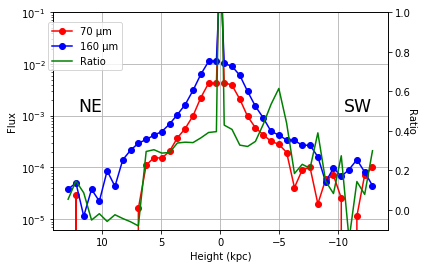

In [84]:
dummy_ratio = convolved_70/ngc1808_160
ap_width=38*3
ap_thick=7
dy = ap_width/2 * np.sin((ned_pa - 90)*np.pi/180)
dx = ap_width/2 * np.cos((ned_pa - 90)*np.pi/180) 
ddy = ap_thick * np.cos((ned_pa - 90)*np.pi/180)
ddx = ap_thick * np.sin((ned_pa - 90)*np.pi/180)

fig,ax1 = plt.subplots()
#above, side with arrow
n=0
above_flux = np.array([ngc1808_70[int(yc),int(xc)]])
above_flux2 = np.array([ngc1808_160[int(yc),int(xc)]])
above_ratio = np.array([dummy_ratio[int(yc),int(xc)]])
above_height = np.append(0,(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60)
while n<20:
    aper_n = np.array([])
    aper2_n = np.array([])
    aper3_n = np.array([])
    yfloor = math.floor(yc-abs(dy)+n*abs(ddy))
    yceil = math.ceil(yc+abs(dy)+(n+1)*abs(ddy))
    xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
    xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
    i = yfloor
    while yfloor <= i < yceil:
        j = xfloor
        while xfloor <= j < xceil:
            t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
            s = -(j - xc[0])*np.sin((ned_pa-90)*np.pi/180) + (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
            if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                if np.isnan(ngc1808_70[i,j])==False:
                    aper_n = np.append(aper_n,ngc1808_70[i,j])
                else:
                    aper_n = np.append(aper_n,0)
                if np.isnan(ngc1808_160[i,j])==False:
                    aper2_n = np.append(aper2_n,ngc1808_160[i,j])
                else:
                    aper2_n = np.append(aper2_n,0)
                if np.isnan(dummy_ratio[i,j])==False:
                    aper3_n = np.append(aper3_n,dummy_ratio[i,j])
                else:
                    aper3_n = np.append(aper3_n,0)

            j+=1
        i+=1
    above_flux = np.append(above_flux,np.median(aper_n))
    above_flux2 = np.append(above_flux2,np.median(aper2_n))
    above_ratio = np.append(above_ratio,np.median(aper3_n))
    n+=1

#below
n=0
below_flux = np.array([])
below_flux2 = np.array([])
below_ratio = np.array([])
below_height = -1*(np.arange(ap_thick,21*ap_thick,ap_thick)-ap_thick/2)*scale/60
while n<20:
    aper_n = np.array([])
    aper2_n = np.array([])
    aper3_n = np.array([])
    yfloor = math.floor(yc-abs(dy)-(n+1)*abs(ddy))
    yceil = math.ceil(yc+abs(dy)-(n)*abs(ddy))
    xfloor = math.floor(xc-dx-(n+1)*abs(ddx))
    xceil = math.ceil(xc+dx+(n+1)*abs(ddx))
    i = yfloor
    while yfloor <= i < yceil:
        j = xfloor
        while xfloor <= j < xceil:
            t = (j - xc[0])*np.cos((ned_pa-90)*np.pi/180) + (i - yc[0])*np.sin((ned_pa-90)*np.pi/180) #x' axis
            s = (j - xc[0])*np.sin((ned_pa-90)*np.pi/180) - (i - yc[0])*np.cos((ned_pa-90)*np.pi/180) #y' axis
            if  n*ap_thick <= s < (n+1)*ap_thick and -ap_width/2 <= t <= ap_width/2:  #and sn threshold:
                if np.isnan(ngc1808_70[i,j])==False:
                    aper_n = np.append(aper_n,ngc1808_70[i,j])
                else:
                    aper_n = np.append(aper_n,0)
                if np.isnan(ngc1808_160[i,j])==False:
                    aper2_n = np.append(aper2_n,ngc1808_160[i,j])
                else:
                    aper2_n = np.append(aper2_n,0)
                if np.isnan(dummy_ratio[i,j])==False:
                    aper3_n = np.append(aper3_n,dummy_ratio[i,j])
                else:
                    aper3_n = np.append(aper3_n,0)
            j+=1
        i+=1
    below_flux = np.append(below_flux,np.median(aper_n))
    below_flux2 = np.append(below_flux2,np.median(aper2_n))
    below_ratio = np.append(below_ratio,np.median(aper3_n))
    n+=1

ax1.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux),above_flux),'ro-',label='70 µm')
ax1.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_flux2),above_flux2),'bo-',label='160 µm')
ax1.set_yscale('log')
ax1.set_ylabel('Flux')
ax1.set_xlabel('Height (kpc)')
ax1.set_ylim(bottom=0,top=0.1)
ax1.invert_xaxis()

ax2 = ax1.twinx()
ax2.plot(np.append(np.flip(below_height),above_height)*3.54,np.append(np.flip(below_ratio),above_ratio),'g-',label='Ratio')
ax2.set_ylabel('Ratio',labelpad=5.5,rotation=270)
ax2.set_ylim(bottom=-0.1,top=1)

fig.legend(loc=2,bbox_to_anchor=(.1,.9-.03))
plt.text(12,0.5,'NE',fontsize='xx-large')
plt.text(-10.5,0.5,'SW',fontsize='xx-large')
ax1.grid()

In [ ]:
plt.imshow(ngc1808_70-(ngc1808_70>0.0004)*ngc1808_70,cmap='rainbow')
plt.colorbar()

In [ ]:
np.amax((ngc1808_70>0.0004)*ngc1808_70)

In [174]:
file[15]

'mos1_1.fits'

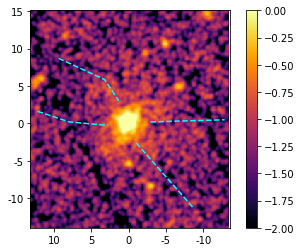

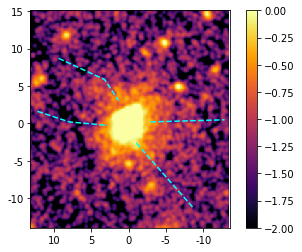

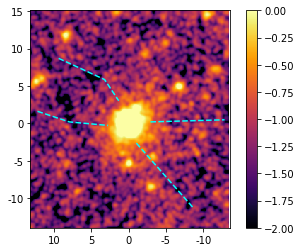

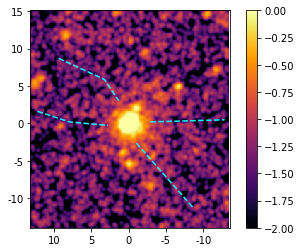

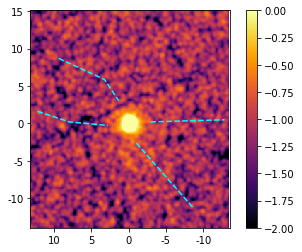

In [195]:
for i in range(5):
    arr,data_1 = resizing(2,15+i,2.5)
    arr,data_2 = resizing(2,20+i,2.5)
    arr,data_3 = resizing(2,25+i,2.5)
    data = data_1+data_2+data_3
    
    data = convolution(data,15,4)
    
    plt.figure()
    plt.imshow(np.log10(data),cmap='inferno',vmin=-2,vmax=0)
    plt.colorbar()
    
    plt.xticks(xlocs,np.flip(x))
    plt.yticks(ylocs,y)
    plt.ylim(0,convolved_70.shape[0])
    plt.xlim(0,convolved_70.shape[1])
    
    plt.plot([150,200+30],[120,50-21],'cyan',ls='--',lw=1.5)
    plt.plot([170,275],[150,153],'cyan',ls='--',lw=1.5)
    plt.plot([10,55,110],[165,150,145],'cyan',ls='--',lw=1.5)
    plt.plot([40,105,125],[240,210,180],'cyan',ls='--',lw=1.5)

In [211]:
file[12]

'ngc1808_xmm_mos1.fits'

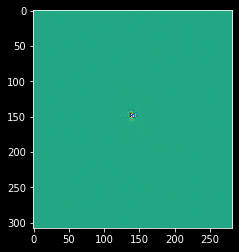

In [212]:
arr = resizing(2,15,2.5)[1]+resizing(2,16,2.5)[1]+resizing(2,17,2.5)[1]+resizing(2,18,2.5)[1]+resizing(2,19,2.5)[1] - resizing(2,12,2.5)[1]
plt.imshow(arr)


In [214]:
np.amin(arr)

-1.0658141036401503e-14